In [1]:
# Imports for NumPy, pandas, matplotlib, and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Notebook magic to inline plots
%matplotlib inline
# Store matplotlib plots as both png and pdf --> for 
# better quality graphics when exporting the notebook
# to pdf.
from IPython.display import set_matplotlib_formats
from IPython.display import Image, Video
set_matplotlib_formats('png', 'pdf')
# Load seaborn defaults
sns.set(rc={'figure.dpi':300})
sns.set_style("ticks")
sns.set_context("talk")

In [3]:
from scipy.stats import norm, rv_histogram

In [4]:
from scipy.optimize import minimize

In [5]:
from galibrate.sampled_parameter import SampledParameter
from galibrate import GAO

/home/blake/src/python/GAlibrate/galibrate/gao.py:11: RuntimeWarning: ------Running GAO with numba optimization.------
  warnings.warn("------Running GAO with numba optimization.------", RuntimeWarning)


In [6]:
def fragment_frequency(fragments):
    frag_counts, _edges = np.histogram(fragments, bins=edges)
    frag_freq = 100 * frag_counts / len(fragments)
    return frag_freq
    

In [7]:
def surface_ablation(initial, Pfrag, fsl, Ndsl):
    """The surface layer of particles is ablated and forms fragments.
    """
    rads = initial / 2
    Nfrag = int(Pfrag*len(rads))
    shell_width = fsl * rads[:Nfrag]
    rcore = rads[:Nfrag] - shell_width
    Dcore = 2 * rcore
    rsl = ( rads[:Nfrag]**3 - rcore**3)**(1/3)
    rfrag = rsl/(Ndsl)**(1/3)
    Dfrag = 2 * rfrag
    frag_list = list()
    for i in range(Ndsl):
        frag_list.append(Dfrag)
    frag_list.append(initial[Nfrag:])    
    fragments = np.concatenate(frag_list)
    return fragments

In [8]:
def cost_surface_ablation(params):
    Pfrag, fsl, Ndsl = params
    Ndsl = int(Ndsl)
    fragments = surface_ablation(sample_sizes, Pfrag, fsl, Ndsl)
    frequencies = fragment_frequency(fragments)
    sse = np.sum((dist['laser'] - frequencies)**2)
    if np.isnan(sse):
        return np.inf
    return sse

In [9]:
def fitness_surface_ablation(theta):
    return -cost_surface_ablation(10**theta)

In [10]:
sampled_parameters_sa = [SampledParameter(name="Pfrag", loc=np.log10(1e-2), width=2),
                         SampledParameter(name="fsl", loc=np.log10(1e-2), width=1),
                         SampledParameter(name="Ndsl", loc=np.log10(1), width=1)]

In [11]:
def particle_split(initial, Pfrag, Nd):
    """Particles get split into equal volume fragments.
    """    
    rads = initial / 2
    Vo = (4/3)*np.pi*rads**3
    Nfrag = int(Pfrag*len(rads))
    Vfrag = Vo[:Nfrag] / Nd
    rfrag = ((3/4)*Vfrag/np.pi)**(1/3) 
    Dfrag = rfrag*2
    for i in range(Ndsl):
        frag_list.append(Dfrag)
    frag_list.append(initial[Nfrag:])    
    fragments = np.concatenate(frag_list)
    return fragments

In [12]:
def cost_particle_split(params):
    Pfrag, Nd = params
    Nd = int(Nd)
    fragments = particle_split(sample_sizes, Pfrag, Nd)
    frequencies = fragment_frequency(fragments)
    sse = np.sum((dist['initial'] - frequencies)**2)
    if np.isnan(sse):
        return np.inf
    return sse

In [13]:
def fitness_particle_split(theta):
    return -cost_particle_split(10**theta)

In [14]:
sampled_parameters_ps = [SampledParameter(name="Pfrag", loc=np.log10(1e-2), width=2),
                         SampledParameter(name="Nd", loc=np.log10(1), width=2)]

# 5 nm

In [15]:
# Load the data
dist = pd.read_csv('5nm_distribution.csv')
dist.head()

size  initial     laser
0   0.4      0.0   0.00000
1   0.8      0.0   0.00000
2   1.2      0.0   0.64103
3   1.6      0.0   5.76923
4   2.0      0.0  10.89744

In [16]:
# Get the histogram bin centers
centers = dist['size'].to_numpy()
centers

array([ 0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,  4.4,
        4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,
        9.2,  9.6, 10. ])

In [17]:
# Histogram bin width
bw = centers[1] - centers[0]
bw

0.4

In [18]:
# Create the corresponding edges for the histogram
edges = np.linspace(centers[0] - 0.5*bw, centers[-1] + 0.5*bw, len(centers)+1, endpoint=True)
edges

array([ 0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,
        4.6,  5. ,  5.4,  5.8,  6.2,  6.6,  7. ,  7.4,  7.8,  8.2,  8.6,
        9. ,  9.4,  9.8, 10.2])

In [19]:
# Create a distribution object from the histogrammed frequencies.
rv_initial = rv_histogram((dist['initial'].to_numpy(), edges))
rv_initial

In [20]:
sample_sizes = rv_initial.rvs(size=10000)
sample_sizes[:10]

array([4.252085  , 5.71762615, 5.2059878 , 5.57182411, 5.33320974,
       4.58066262, 5.34619034, 4.64196044, 4.88635159, 5.70005781])

[0. 0. 0. 0. 0.]


(0, 40)

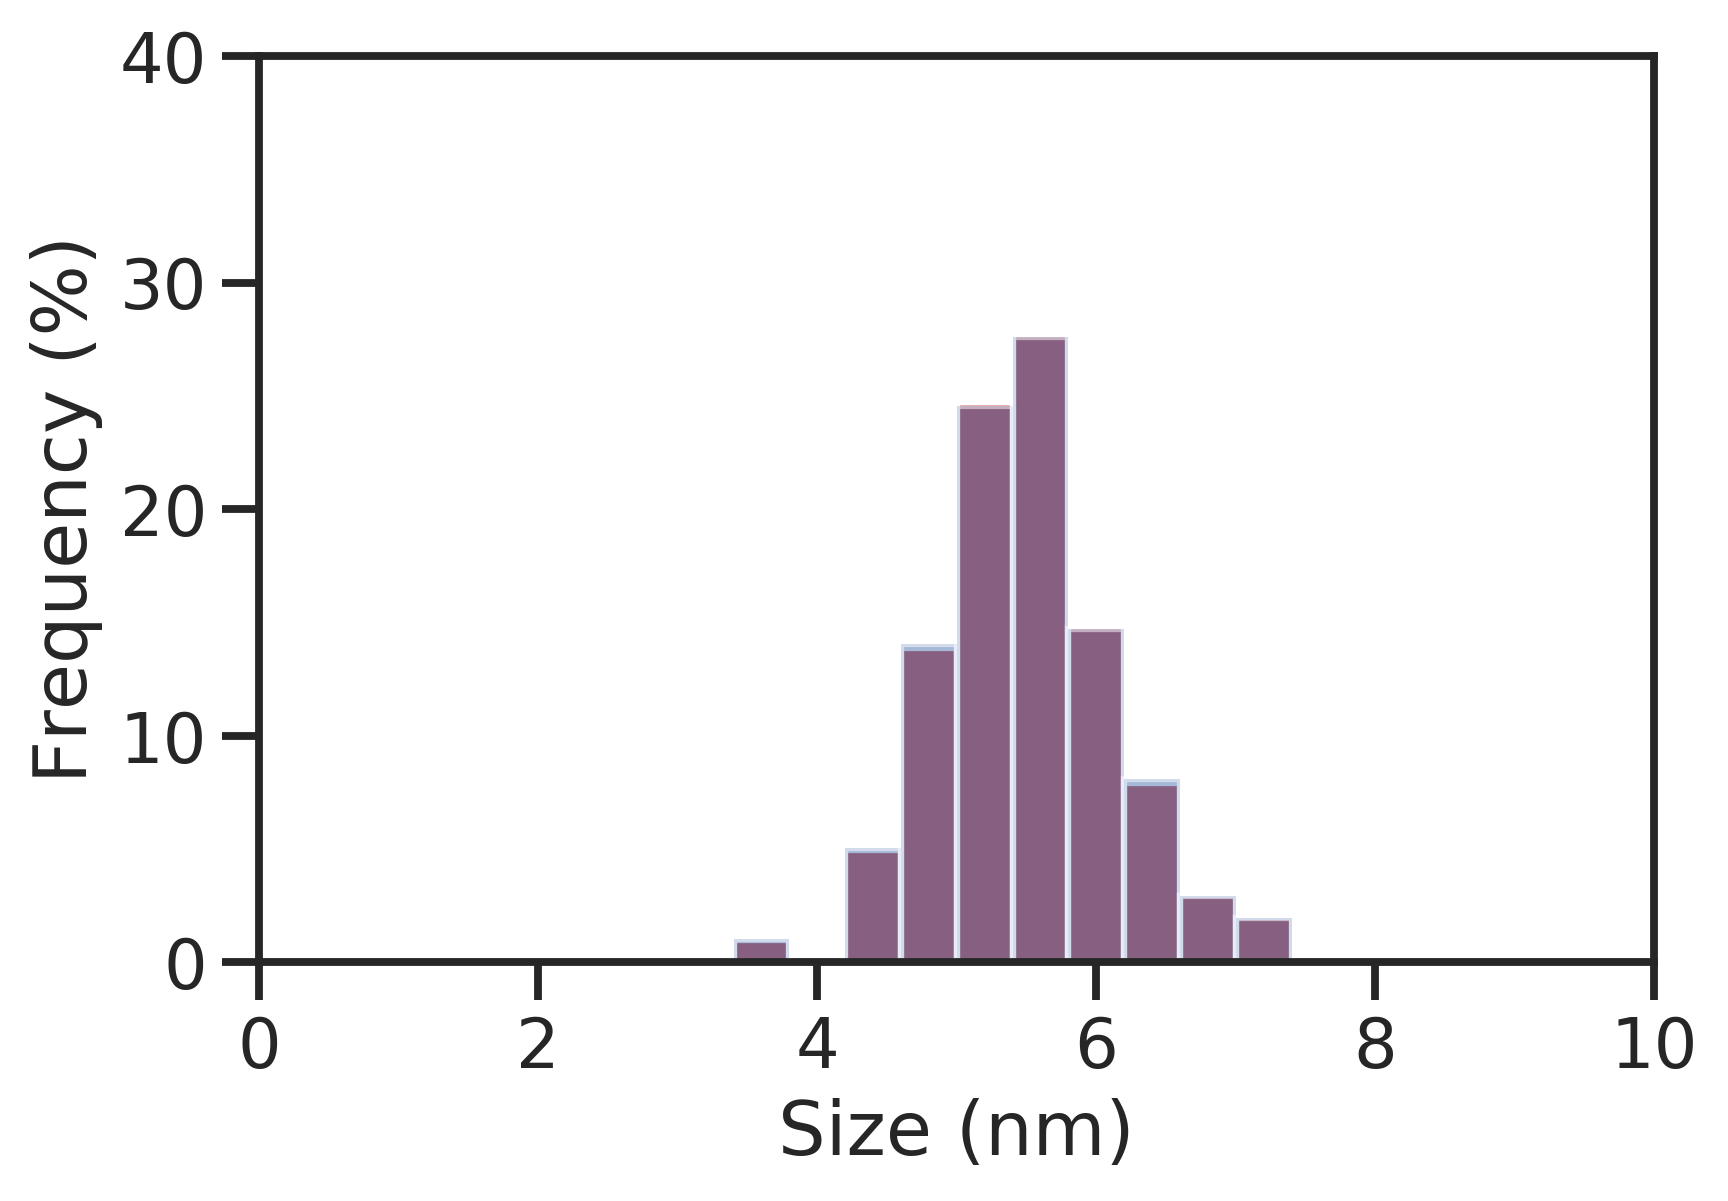

In [21]:
counts, _edges = np.histogram(sample_sizes, bins=edges)

freq = 100 * counts / len(sample_sizes)
print(freq[:5])
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.hist(centers, bins=edges, weights=freq, color='b', alpha=0.5)
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

## Surface Layer Ablation - Single Particle

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [22]:
rads = sample_sizes / 2
shell_width = 0.06 * rads
#shell_width = norm(loc=0.03, scale=0.01).rvs(size=len(rads)) * rads
print(shell_width[:5])
rcore = rads - shell_width
Dcore = 2 * rcore
rsl = ( rads**3 - rcore**3)**(1/3)
print(rsl[:5])
Dsl = 2 * rsl
print(Dsl[:5])

[0.12756255 0.17152878 0.15617963 0.16715472 0.15999629]
[1.1764047  1.58186919 1.44031657 1.54153082 1.47551448]
[2.35280939 3.16373838 2.88063315 3.08306163 2.95102896]


In [23]:
frag_sizes = np.concatenate((Dsl, Dcore))

In [24]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[  0   0   0   0 104]
[0.   0.   0.   0.   0.52]


(0, 25)

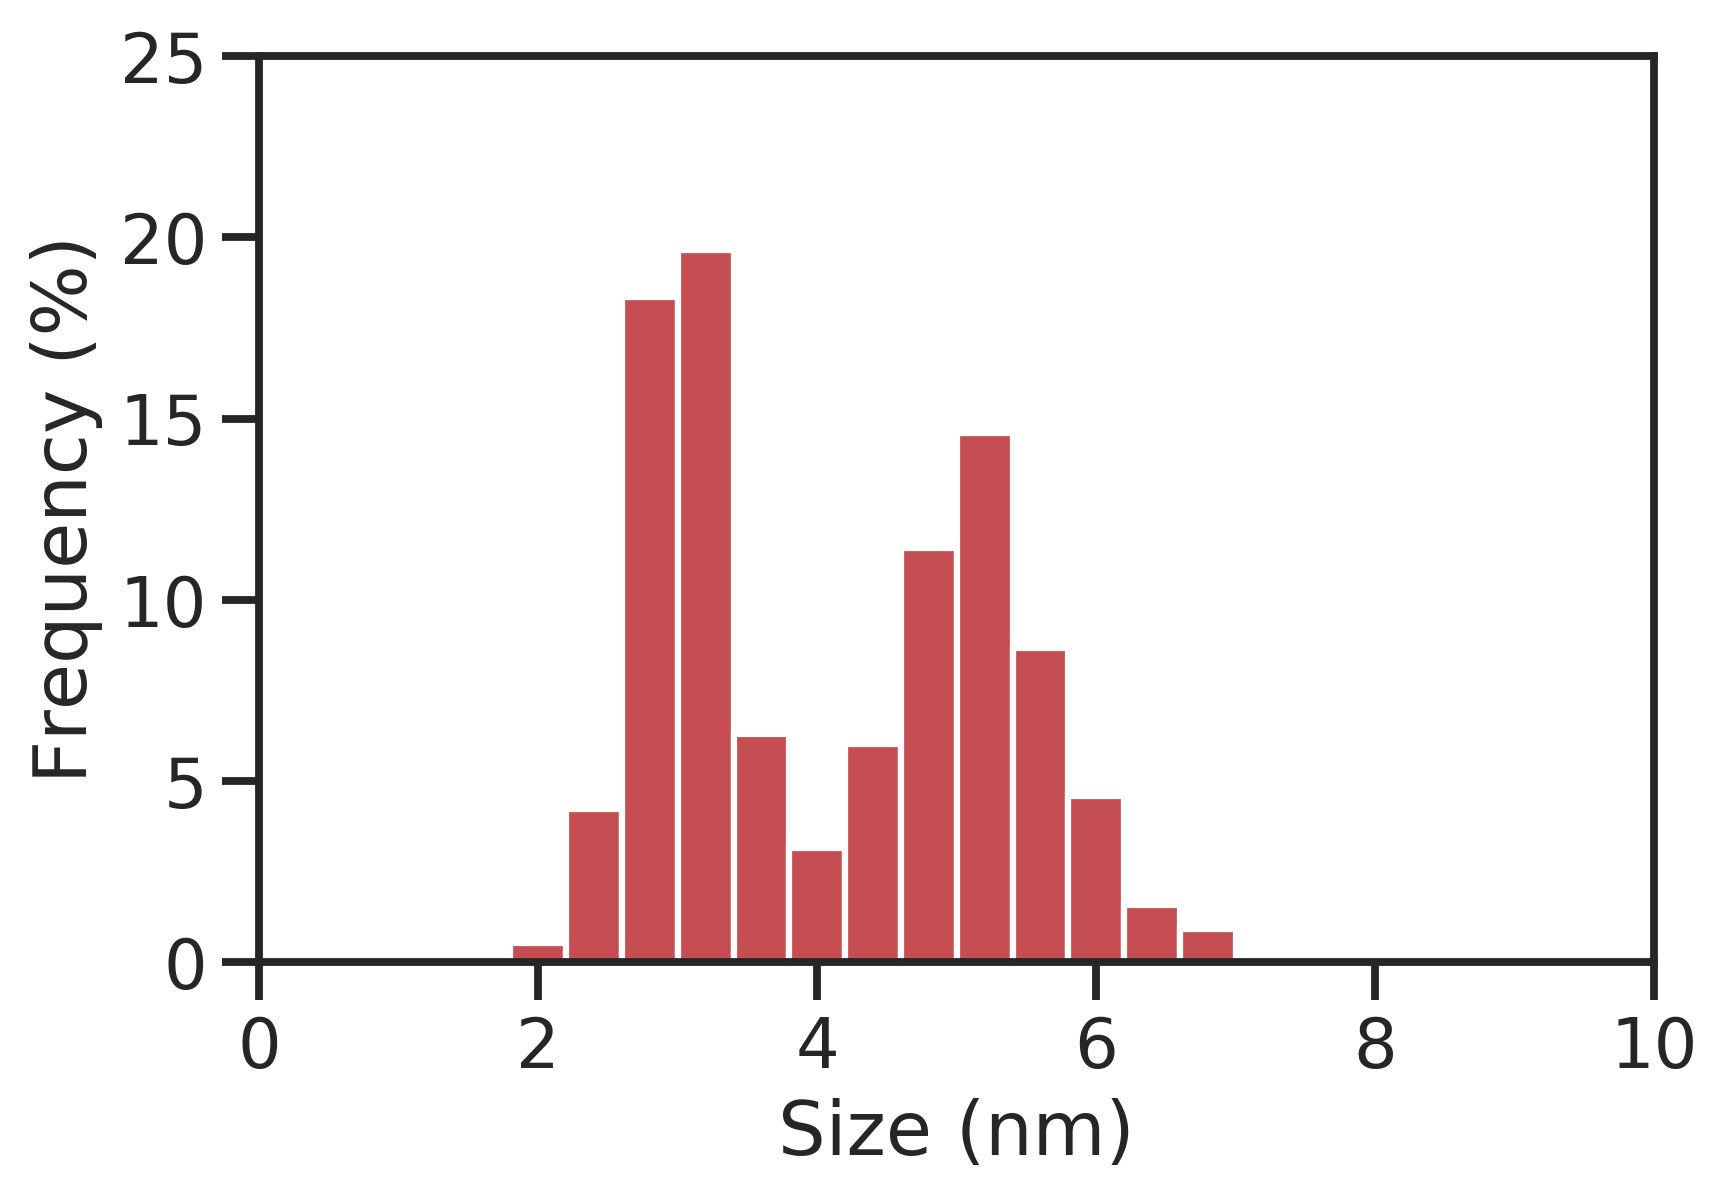

In [25]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,25))

In [26]:
np.savetxt('5nm_explore_centers.txt', centers)
np.savetxt('5nm_explore_edges.txt', edges)
np.savetxt('5nm_explore_frequency_sa_1part.txt', frag_freq)

(0, 25)

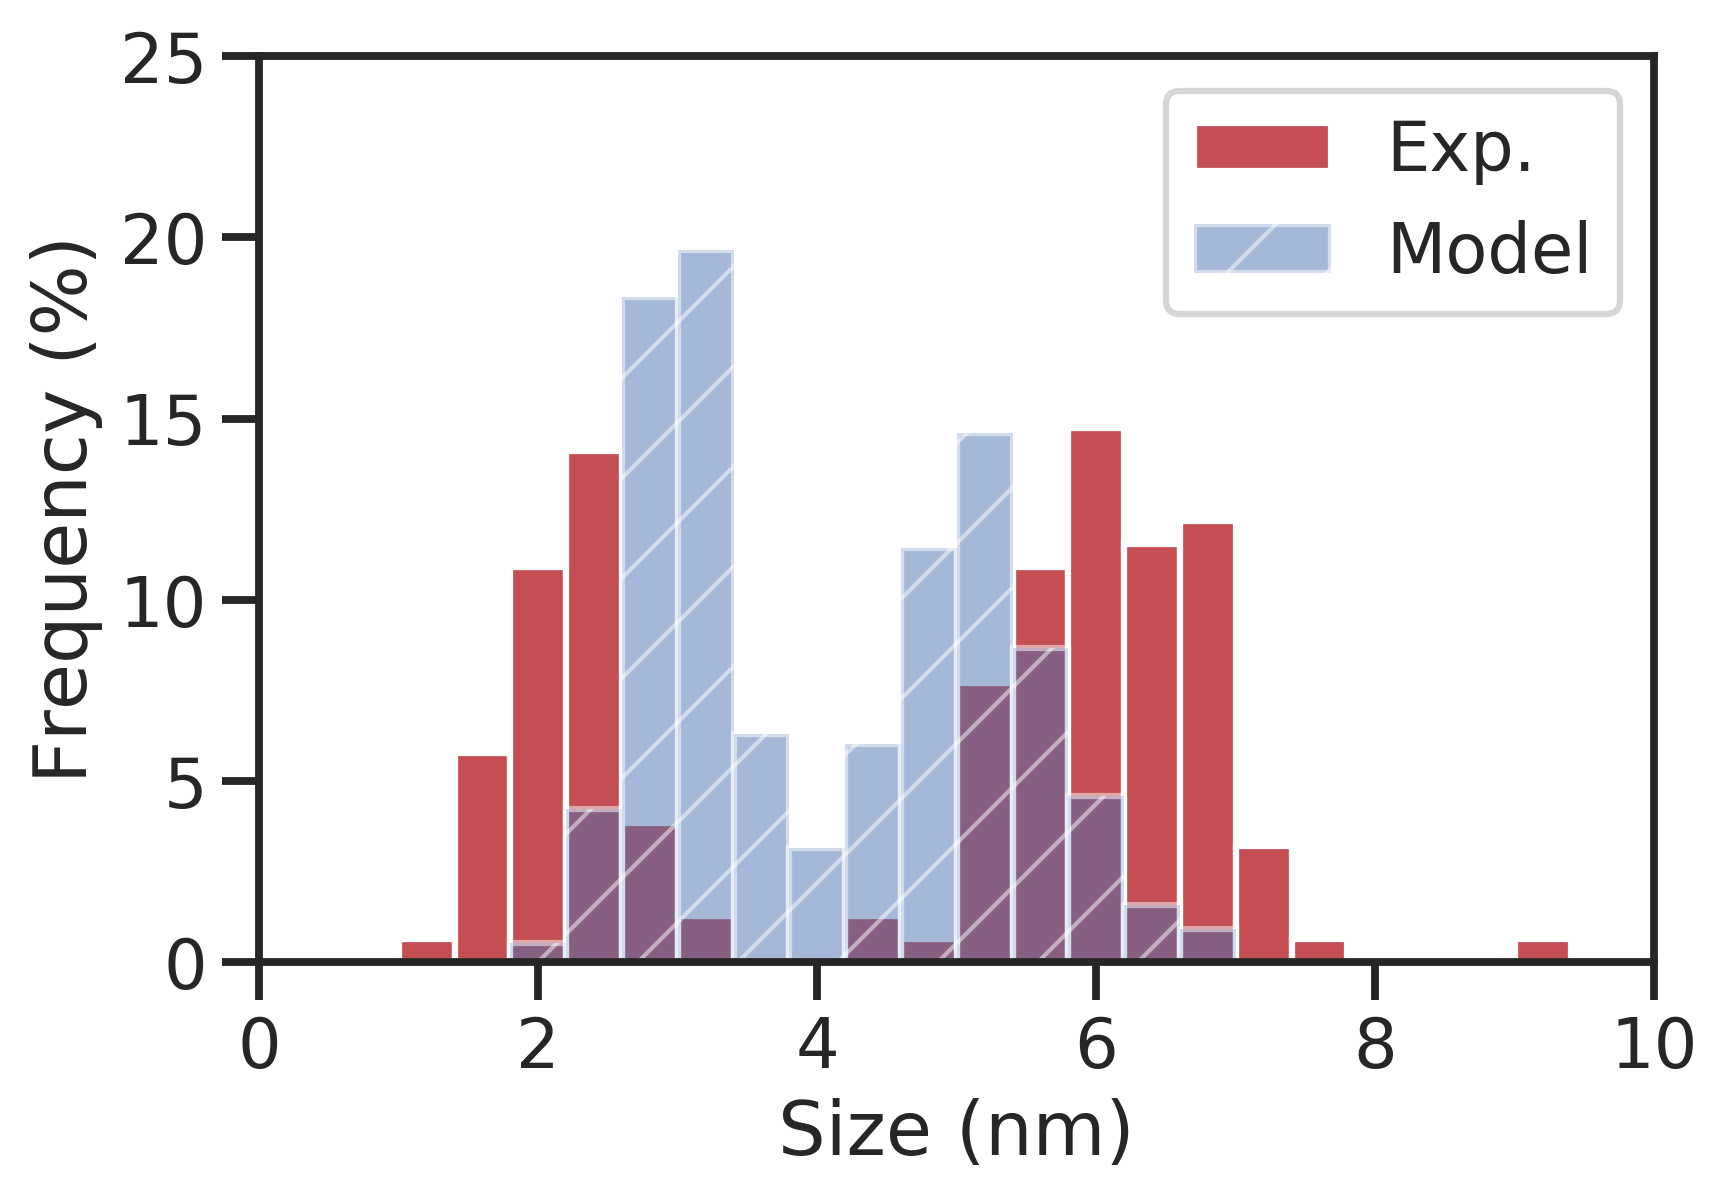

In [27]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,25))

## Surface Layer Ablation - Two Particles

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms two equal volume particles so that there are three daughter particles: two corresponding to the surface layer and one for the remaining particle core.

In [28]:
shell_width = 0.06 * rads
print(shell_width[:5])
rcore = rads - shell_width
Dcore = 2 * rcore
rsl = ( rads**3 - rcore**3)**(1/3)
rfrag = rsl/(2)**(1/3)
print(rsl[:5])
Dfrag = 2 * rfrag
print(Dsl[:5])

[0.12756255 0.17152878 0.15617963 0.16715472 0.15999629]
[1.1764047  1.58186919 1.44031657 1.54153082 1.47551448]
[2.35280939 3.16373838 2.88063315 3.08306163 2.95102896]


In [29]:
frag_sizes = np.concatenate((Dfrag, Dfrag, Dcore))

In [30]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[   0    0    0  208 3938]
[ 0.          0.          0.          0.69333333 13.12666667]


(0, 40)

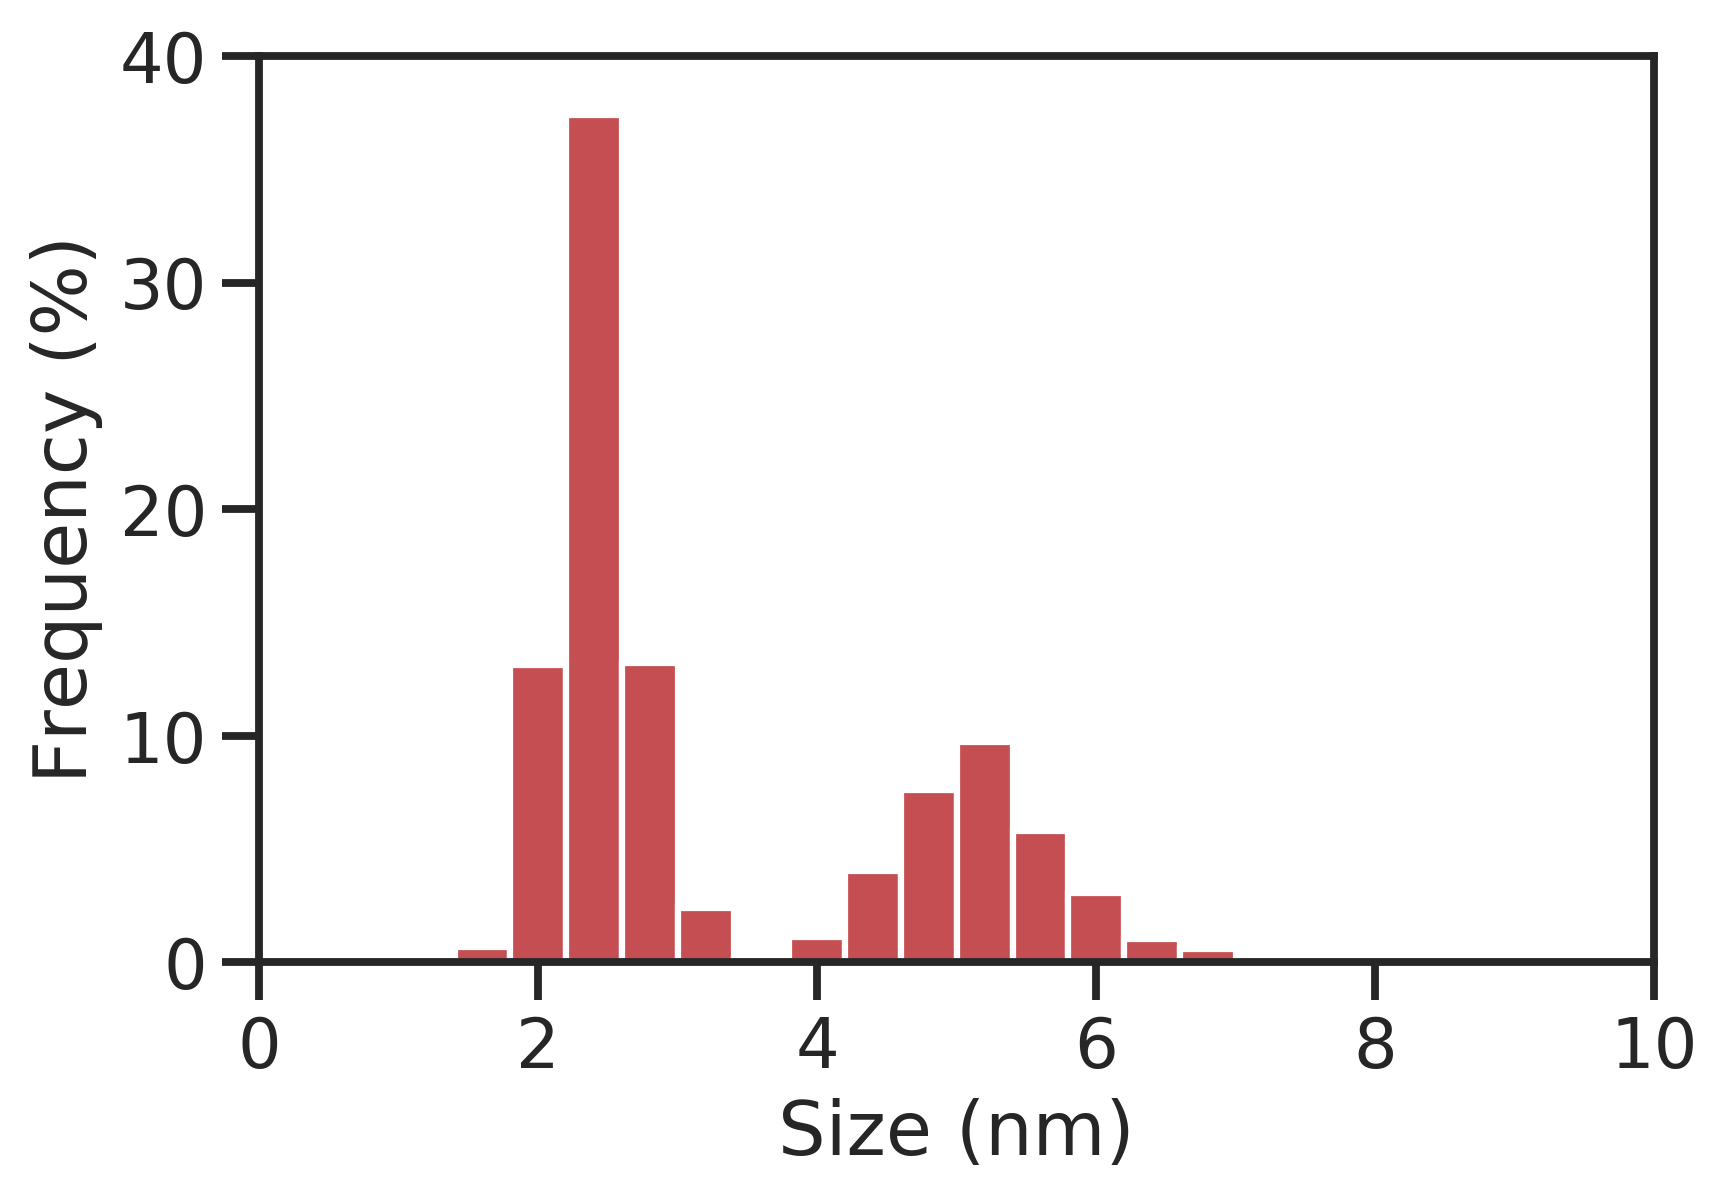

In [31]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

In [32]:
np.savetxt('5nm_explore_frequency_sa_2part.txt', frag_freq)

(0, 40)

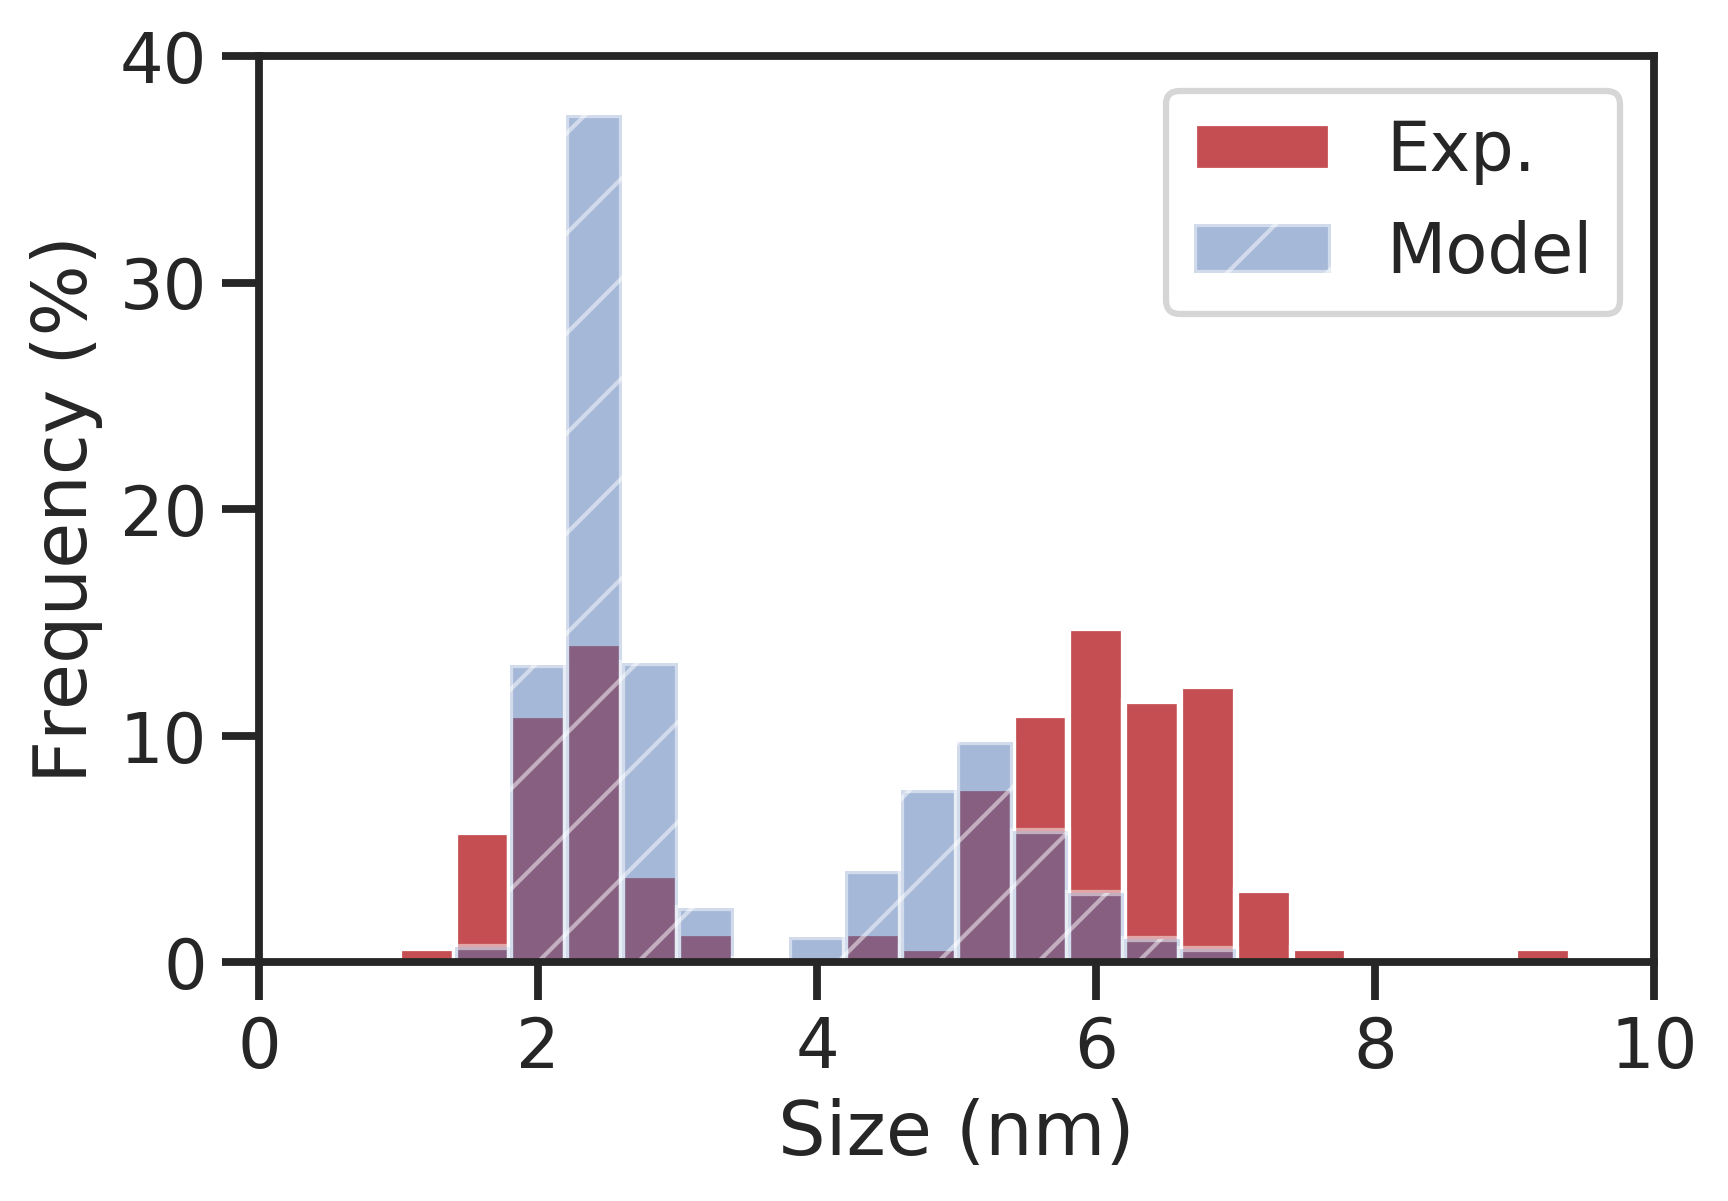

In [33]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,40))

(0, 40)

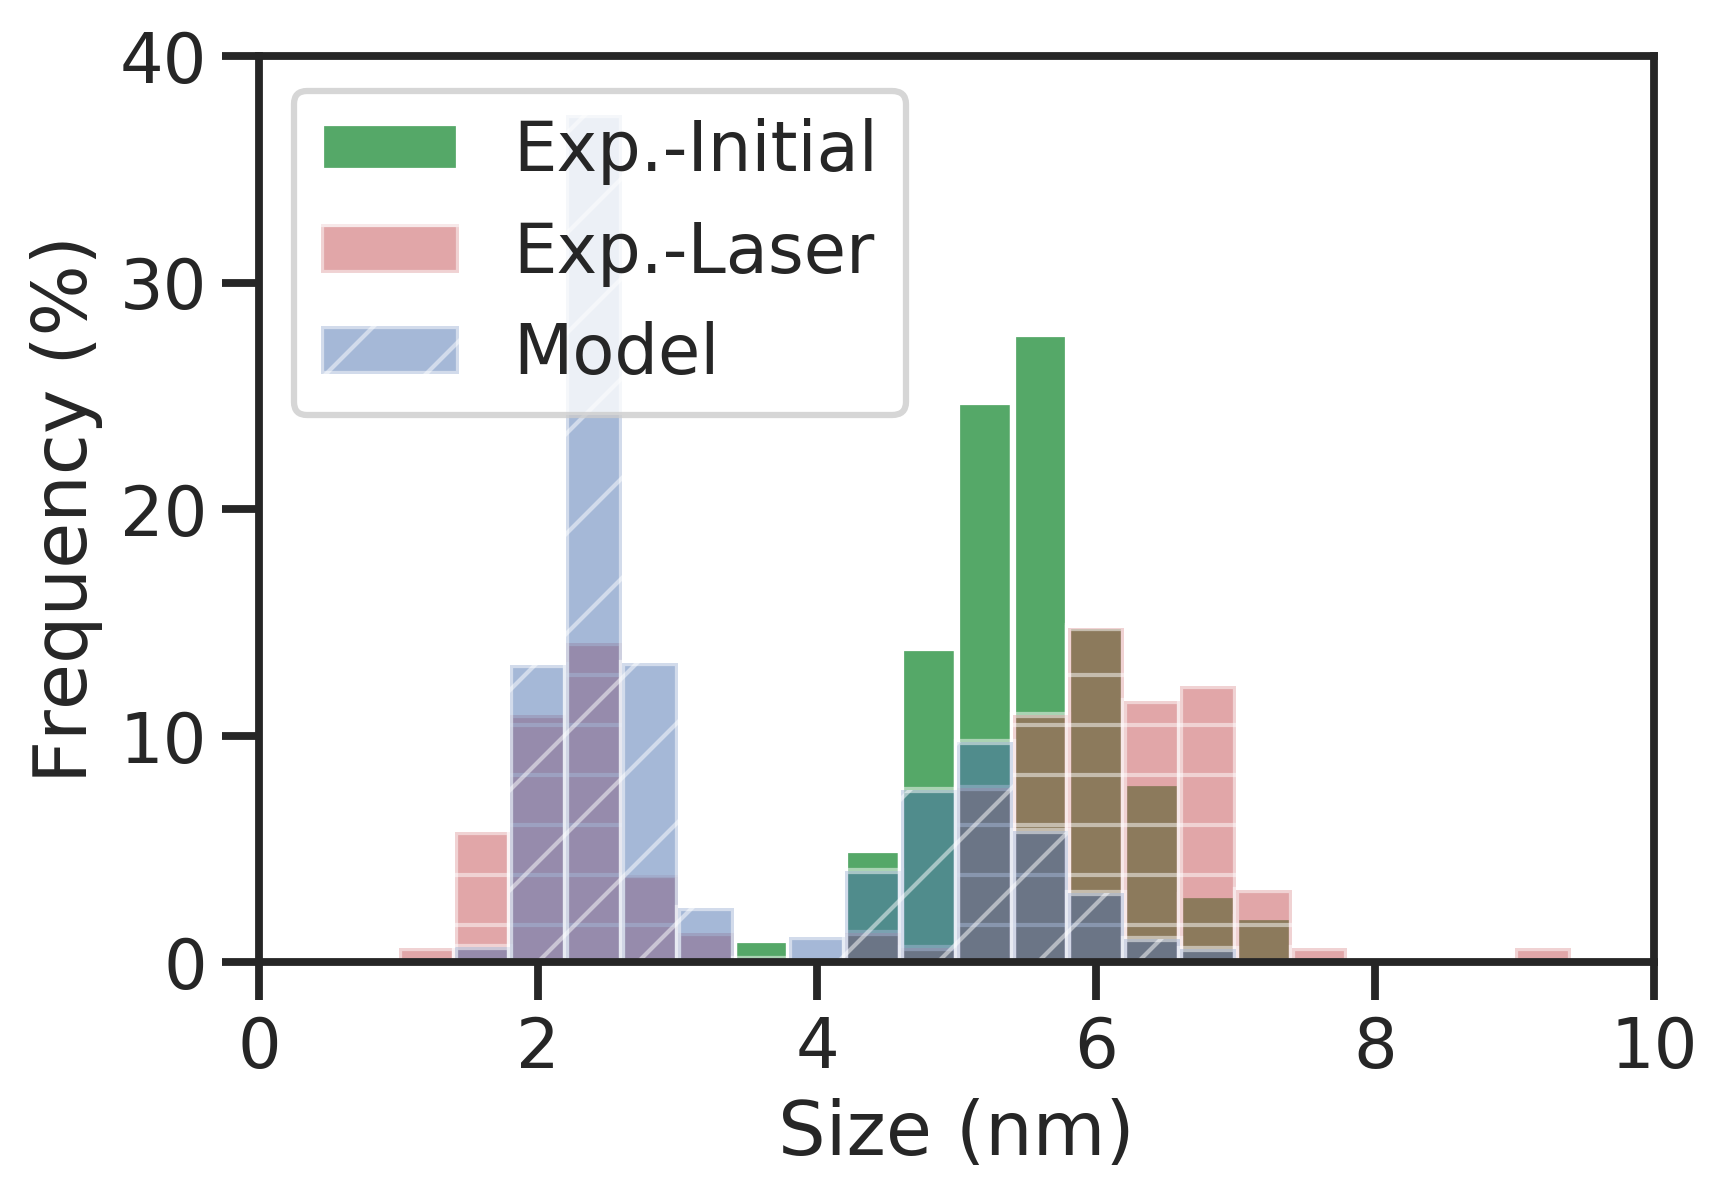

In [34]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,40))

## Surface Layer Ablation - Two Particles - Partial ablation

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms two equal volume particles so that there are three daughter particles: two corresponding to the surface layer and one for the remaining particle core.

In [22]:
shell_width = 0.06 * rads[:int(0.5*len(rads))]
print(shell_width[:5])
rcore = rads[:int(0.5*len(rads))] - shell_width
Dcore = 2 * rcore
rsl = ( rads[:int(0.5*len(rads))]**3 - rcore**3)**(1/3)
rfrag = rsl/(2)**(1/3)
print(rsl[:5])
Dfrag = 2 * rfrag
# pick out half the surface layer fragments -- these will merge onto unfragmented particles
Vfrag = (4/3)*np.pi* rfrag[:int(0.5*len(rfrag))]**3
print(Dsl[:5])
Vo = (4/3)*np.pi * rads[int(0.5*len(rads)):]
Vp = Vo[:len(Vfrag)] + Vfrag
rp = ( (3/(4*np.pi)) * Vp )**(1/3)
Dp = 2*rp

[0.13619606 0.17351299 0.1578379  0.16628221 0.20259898]
[1.25602443 1.60016786 1.45560937 1.53348437 1.8684041 ]
[2.51204886 3.20033571 2.91121874 3.06696873 3.7368082 ]


In [23]:
frag_sizes = np.concatenate((Dfrag[int(0.5*len(Dfrag)):], Dcore, Dp))

In [24]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[  0   0   0  34 487]
[0.   0.   0.   0.34 4.87]


(0, 40)

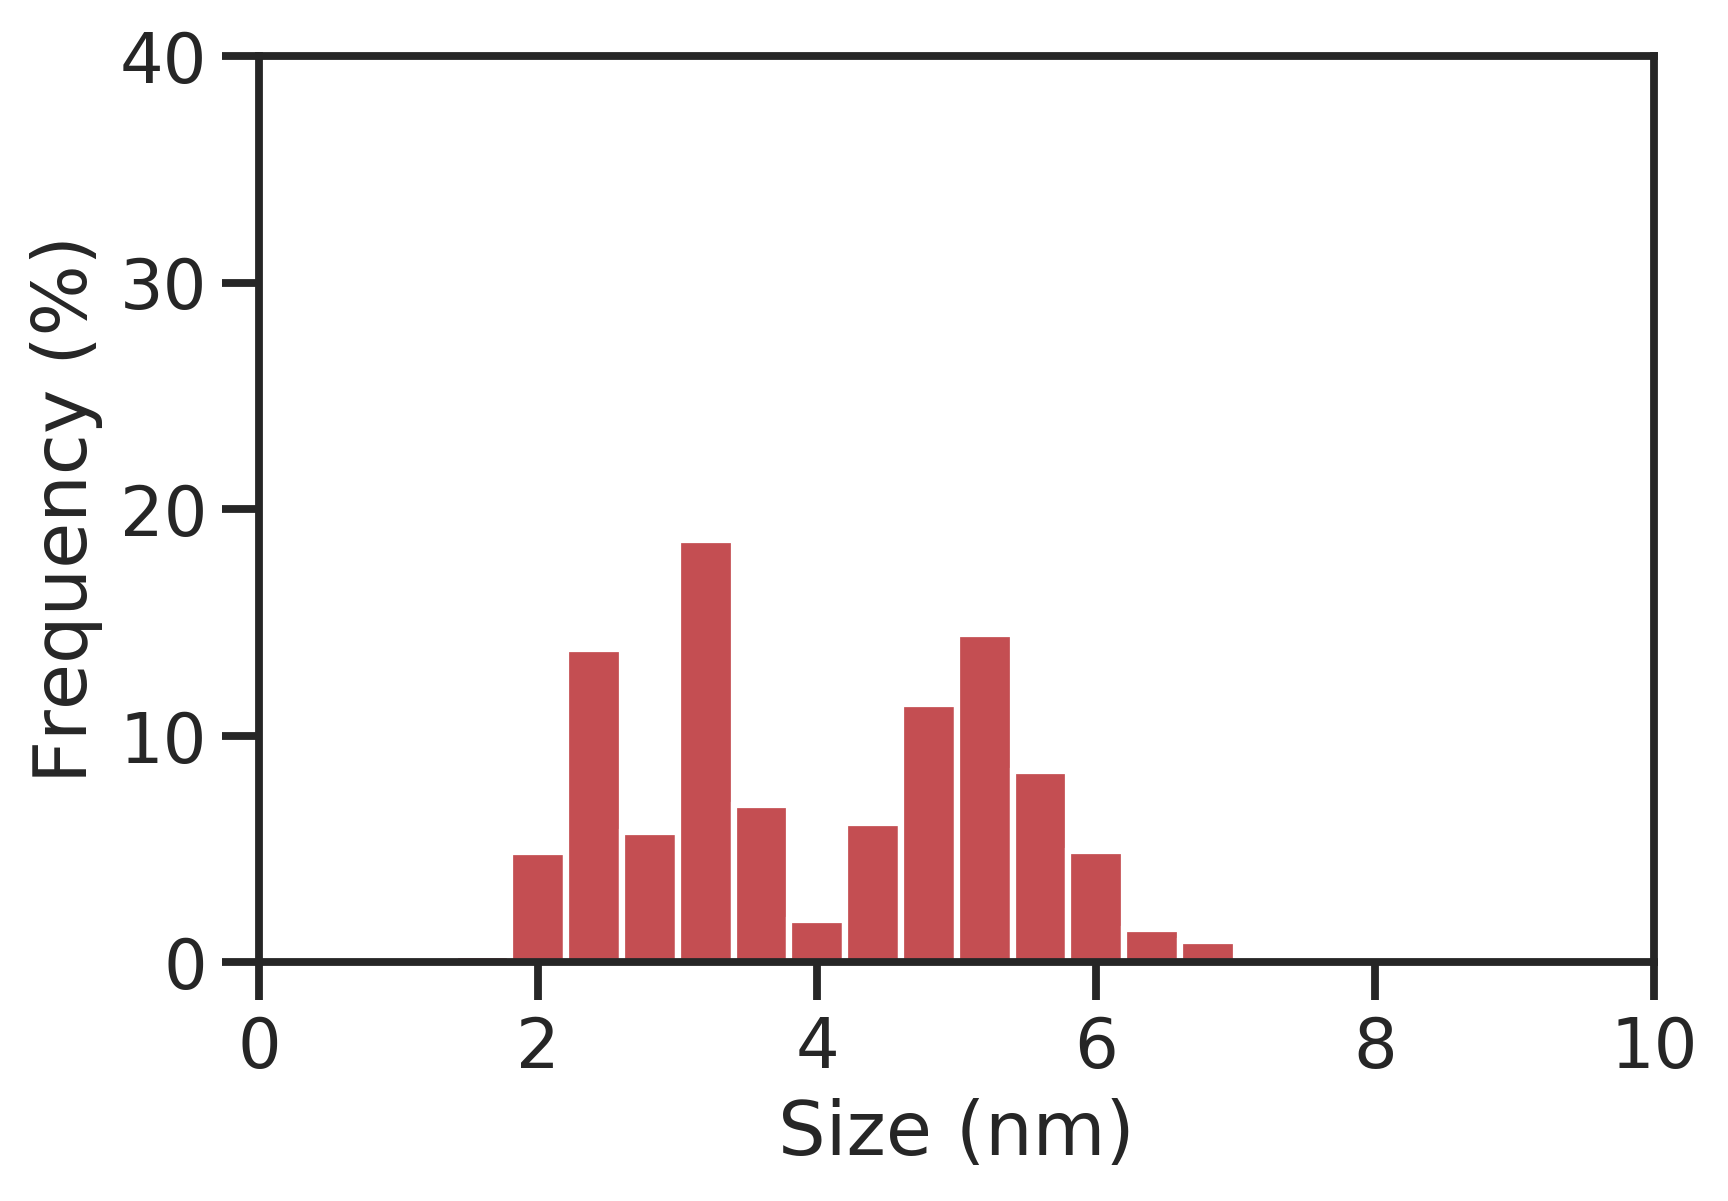

In [25]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

(0, 40)

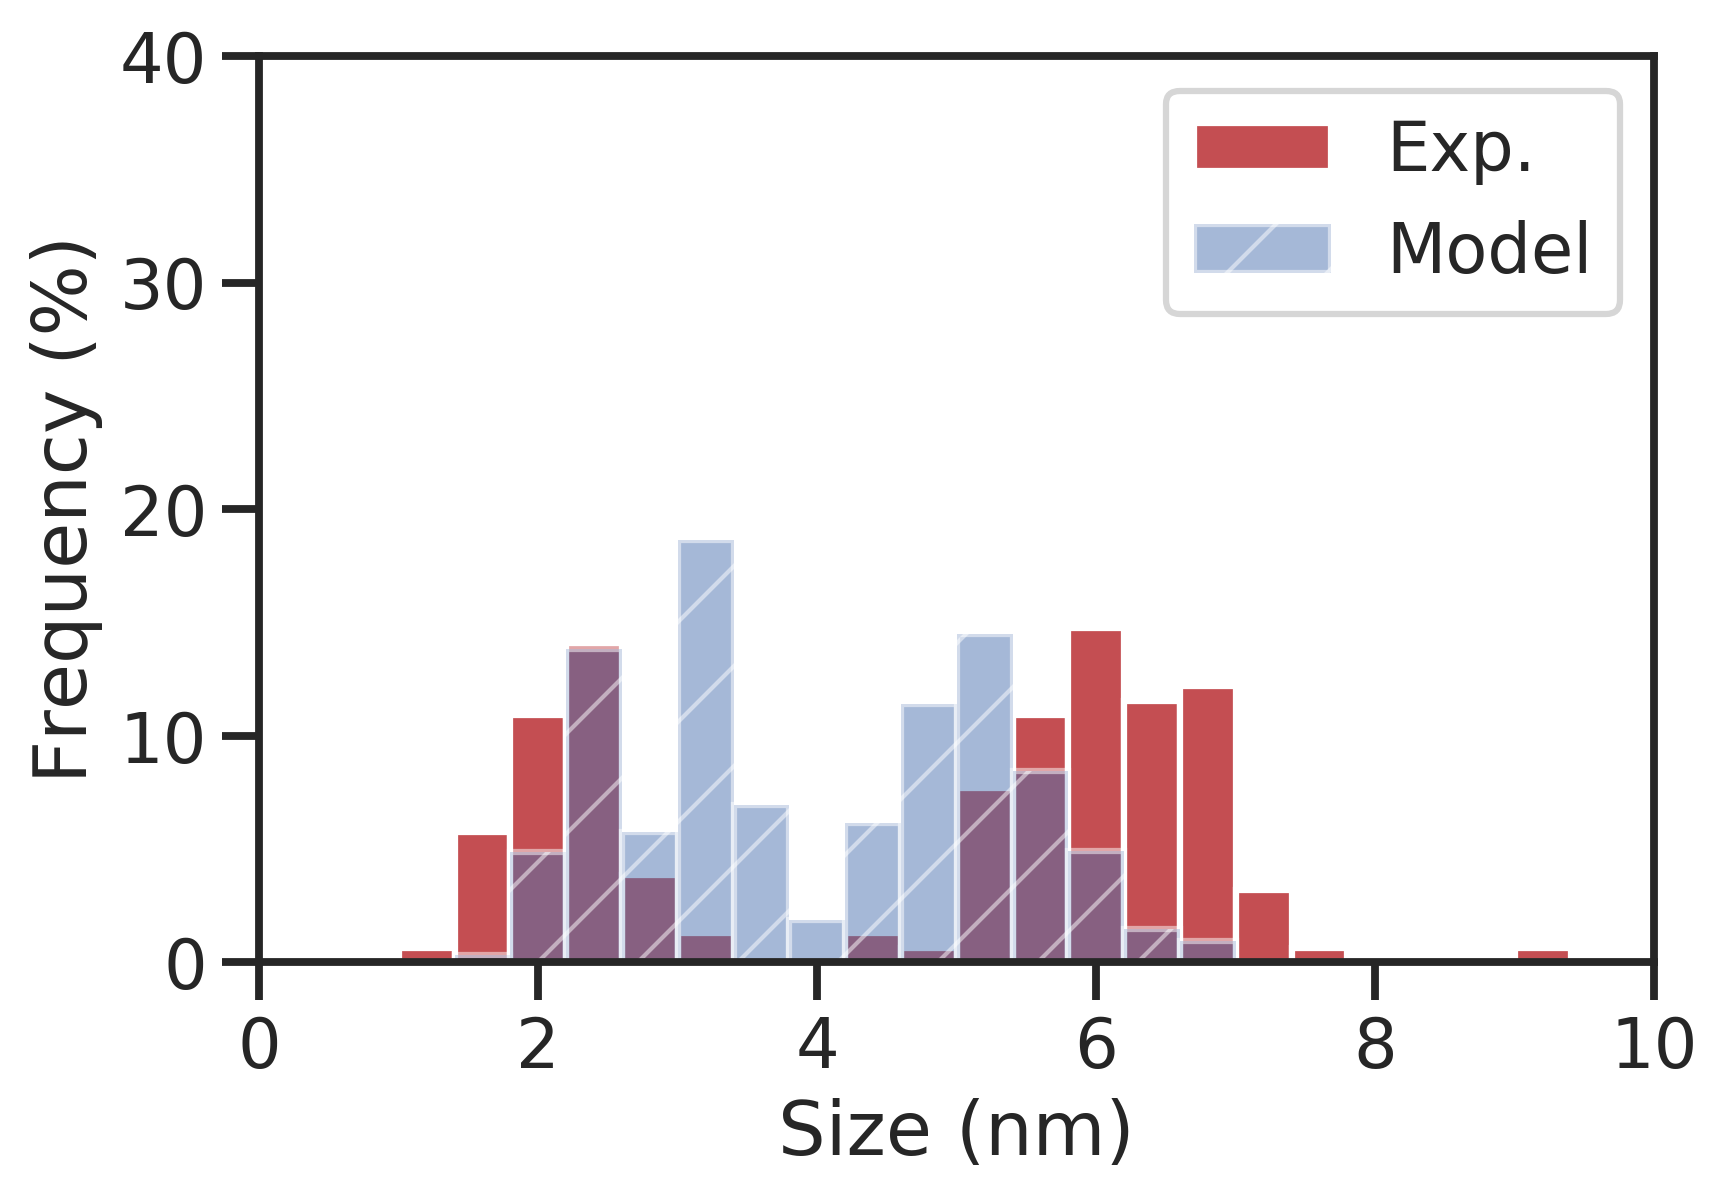

In [26]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,40))

(0, 40)

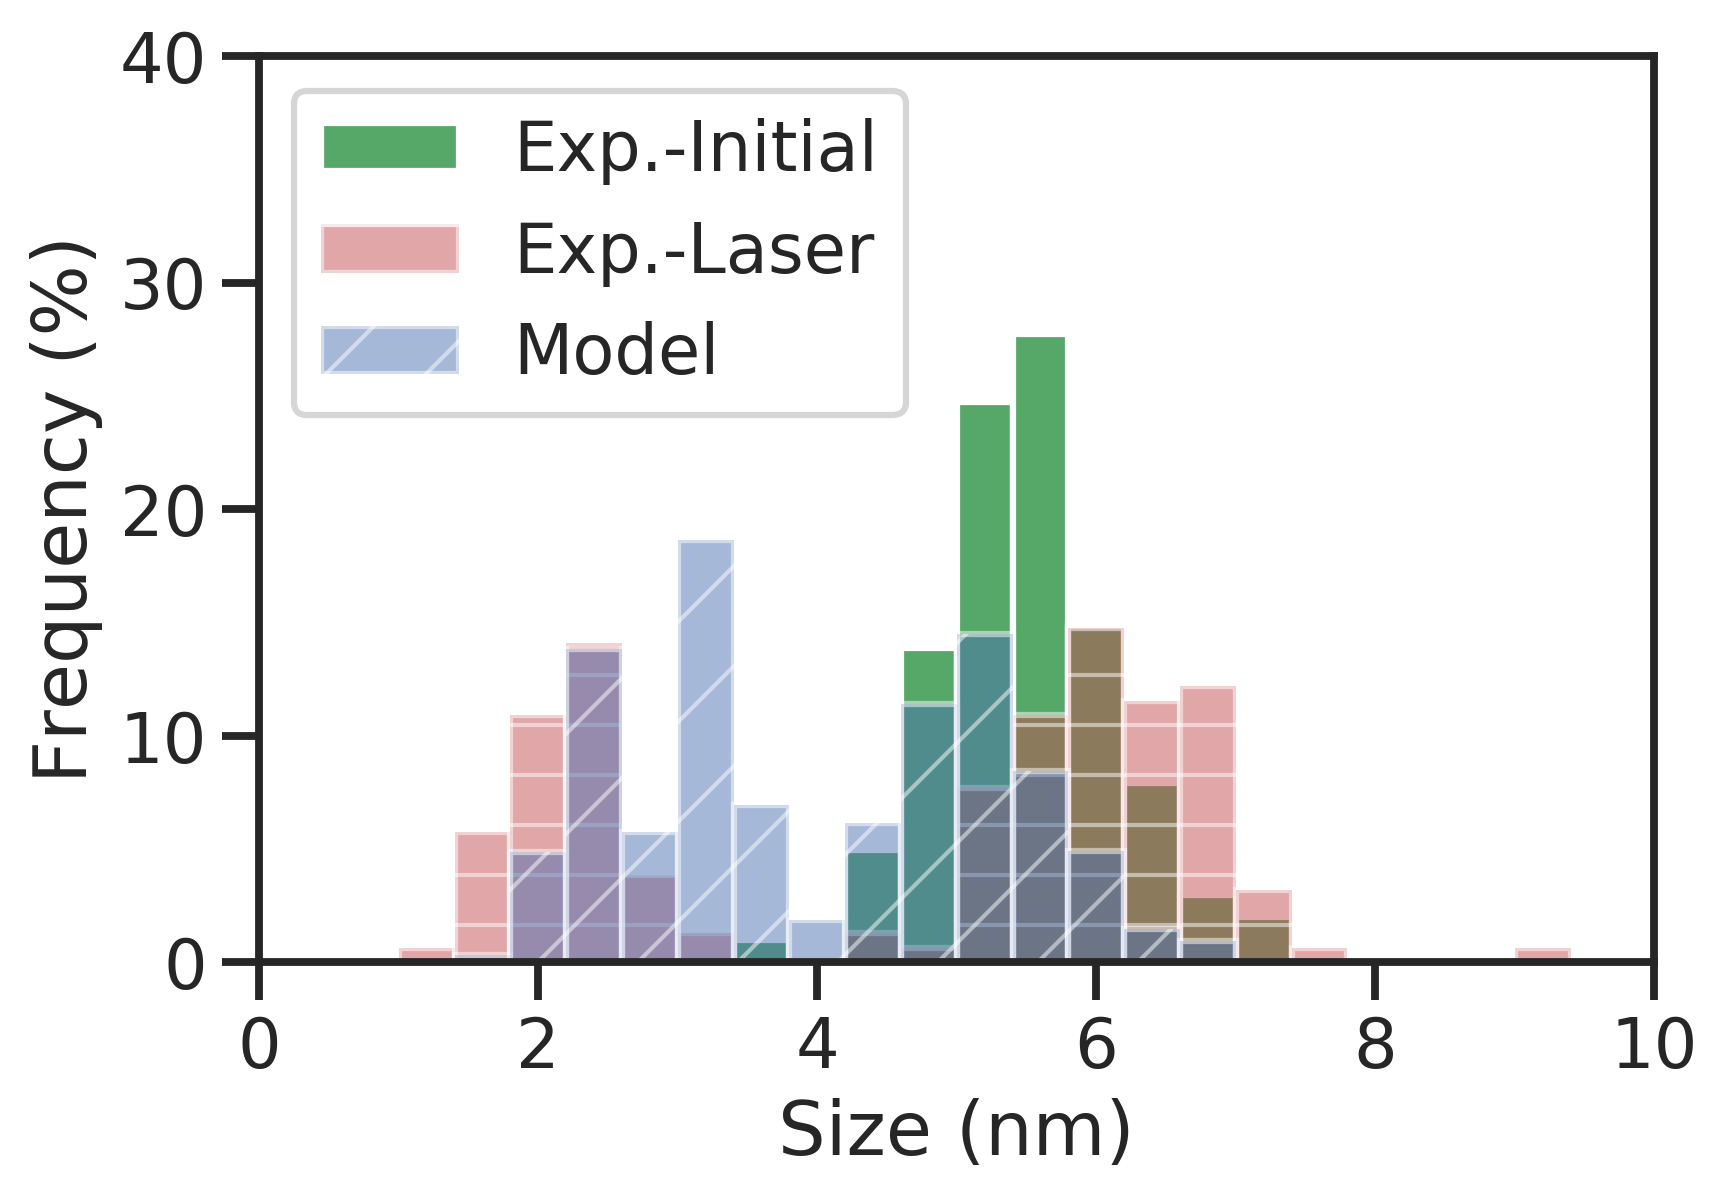

In [27]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,40))

## Particle Split - Two Particles

Here, we apply a model for 1/3 of particles splitting into two particles of equal volume particles, so that the ratio of fragments to unfragmented particles is 1:1.

In [35]:
Vo = (4/3)*np.pi*rads**3
Vfrag = Vo[:int(0.33*len(Vo))]/2
rfrag = ((3/4)*Vfrag/np.pi)**(1/3) 
Dfrag = rfrag*2

In [36]:
frag_sizes = np.concatenate((Dfrag, Dfrag, sample_sizes[int(0.33*len(Vo)):]))

In [37]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[0 0 0 0 0]
[0. 0. 0. 0. 0.]


(0, 25)

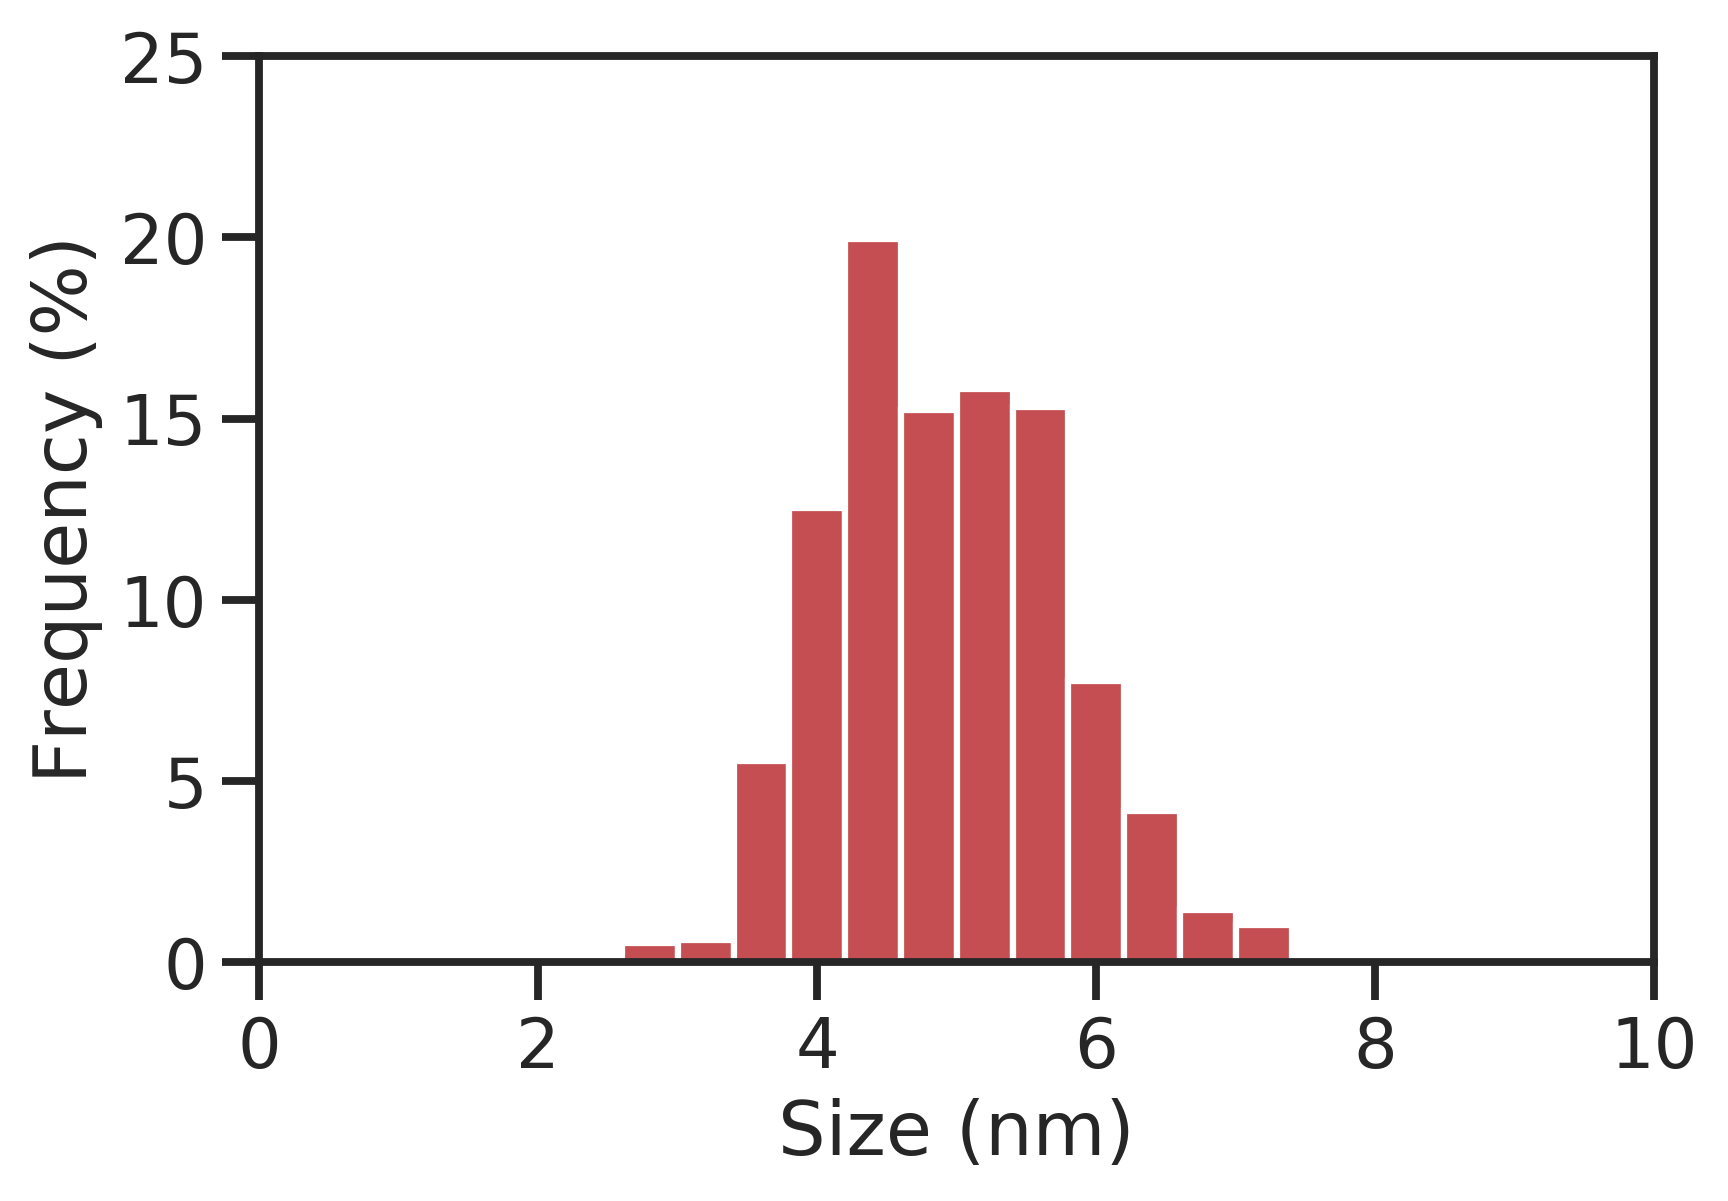

In [38]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,25))

In [39]:
np.savetxt('5nm_explore_frequency_ps_2part.txt', frag_freq)

(0, 25)

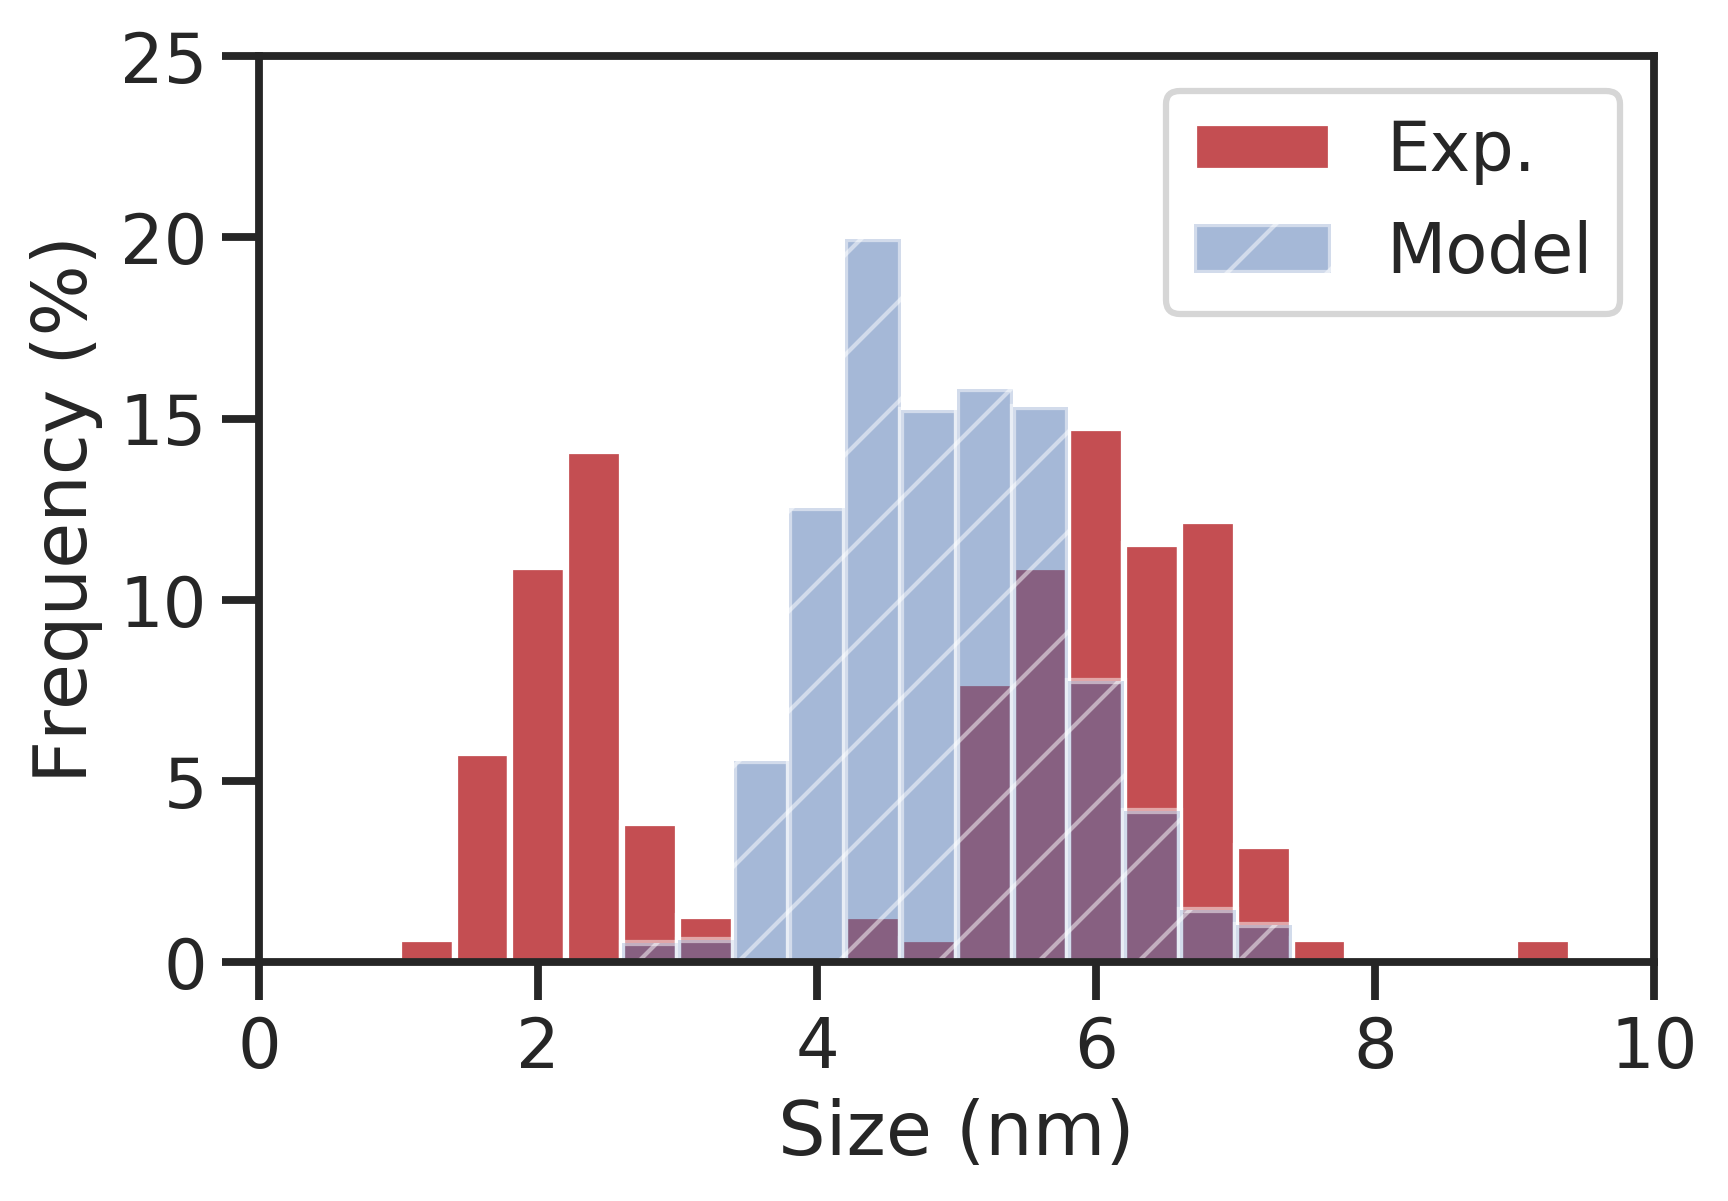

In [40]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,25))

(0, 30)

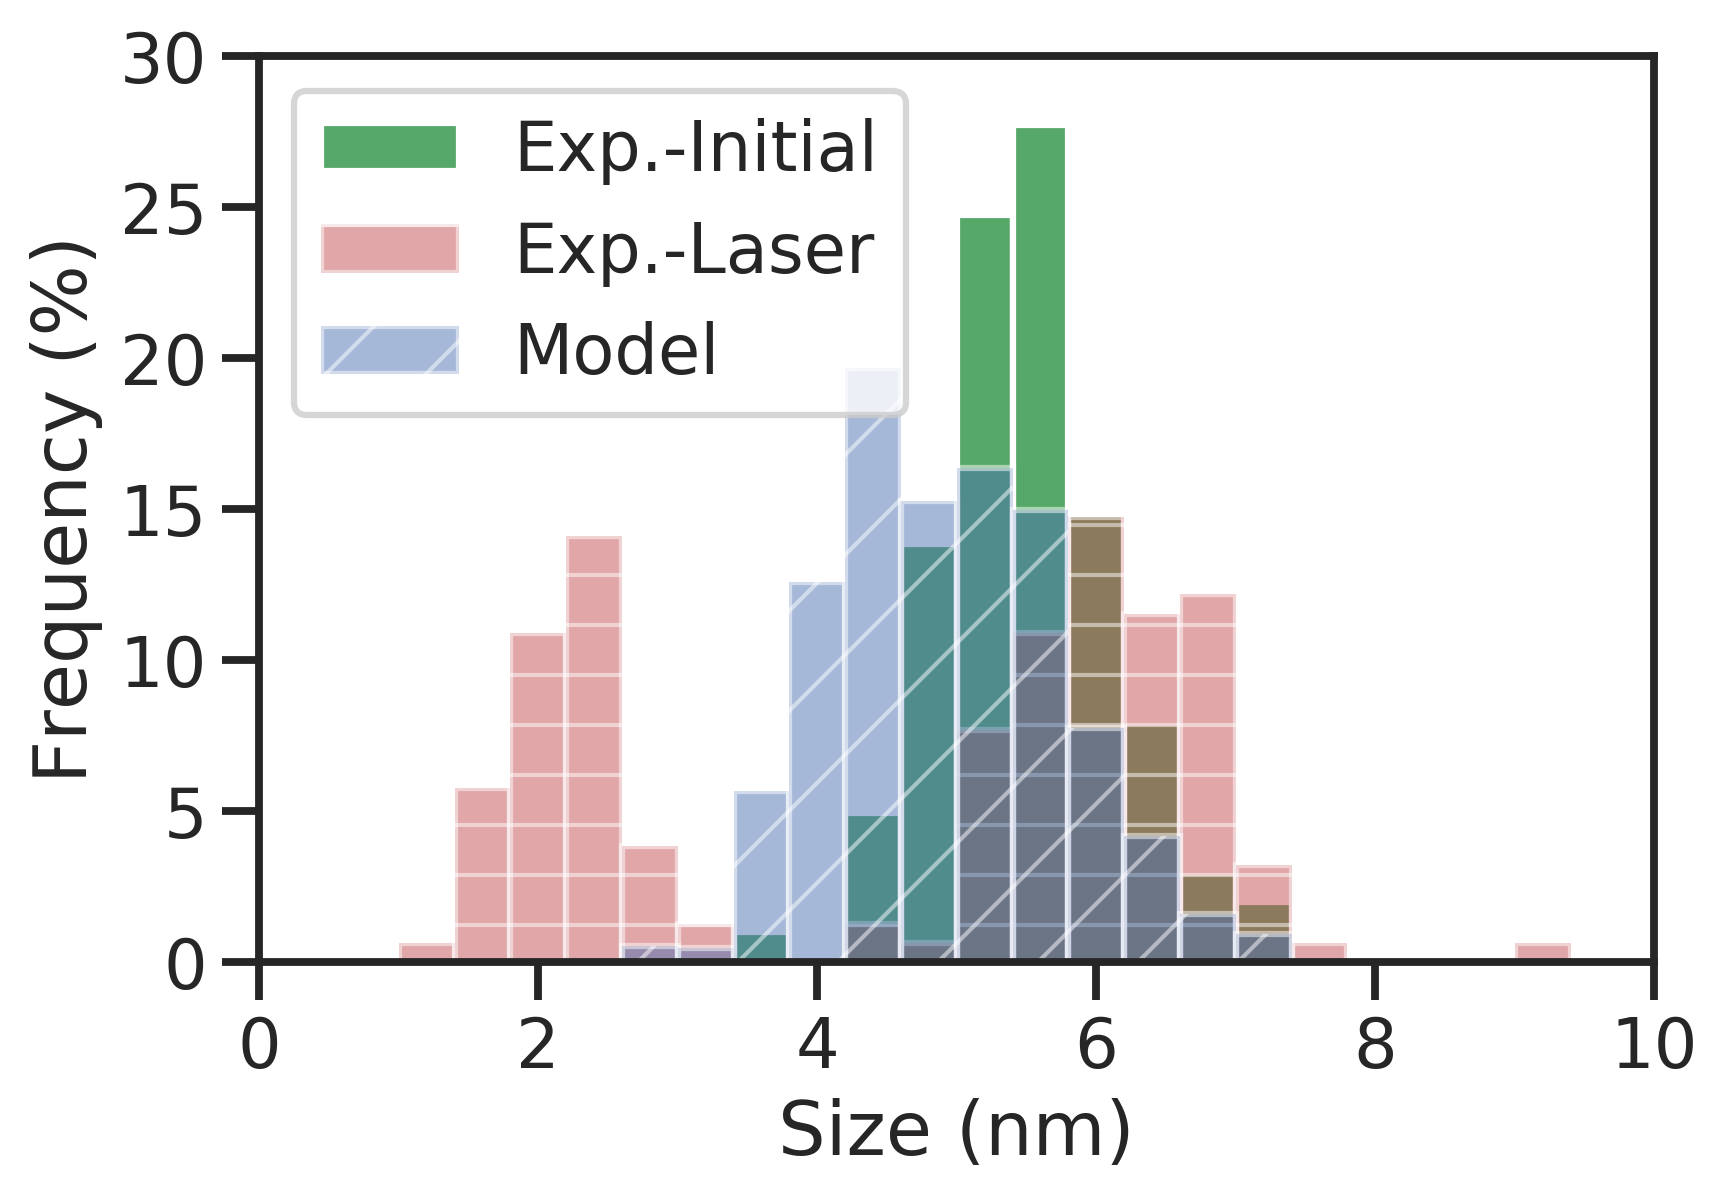

In [33]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,30))

## Particle Split - Four Particles

Here, we apply a model for 1/5 of particles splitting into four particles of equal volume particles, so that the ratio of fragments to unfragmented particles is 1:1.

In [34]:
Vo = (4/3)*np.pi*rads**3
Vfrag = Vo[:int(0.2*len(Vo))]/4
rfrag = ((3/4)*Vfrag/np.pi)**(1/3) 
Dfrag = rfrag*2

In [35]:
frag_sizes = np.concatenate((Dfrag, Dfrag, Dfrag, Dfrag, sample_sizes[int(0.2*len(Vo)):]))

In [36]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[ 0  0  0  0 24]
[0.   0.   0.   0.   0.15]


(0, 25)

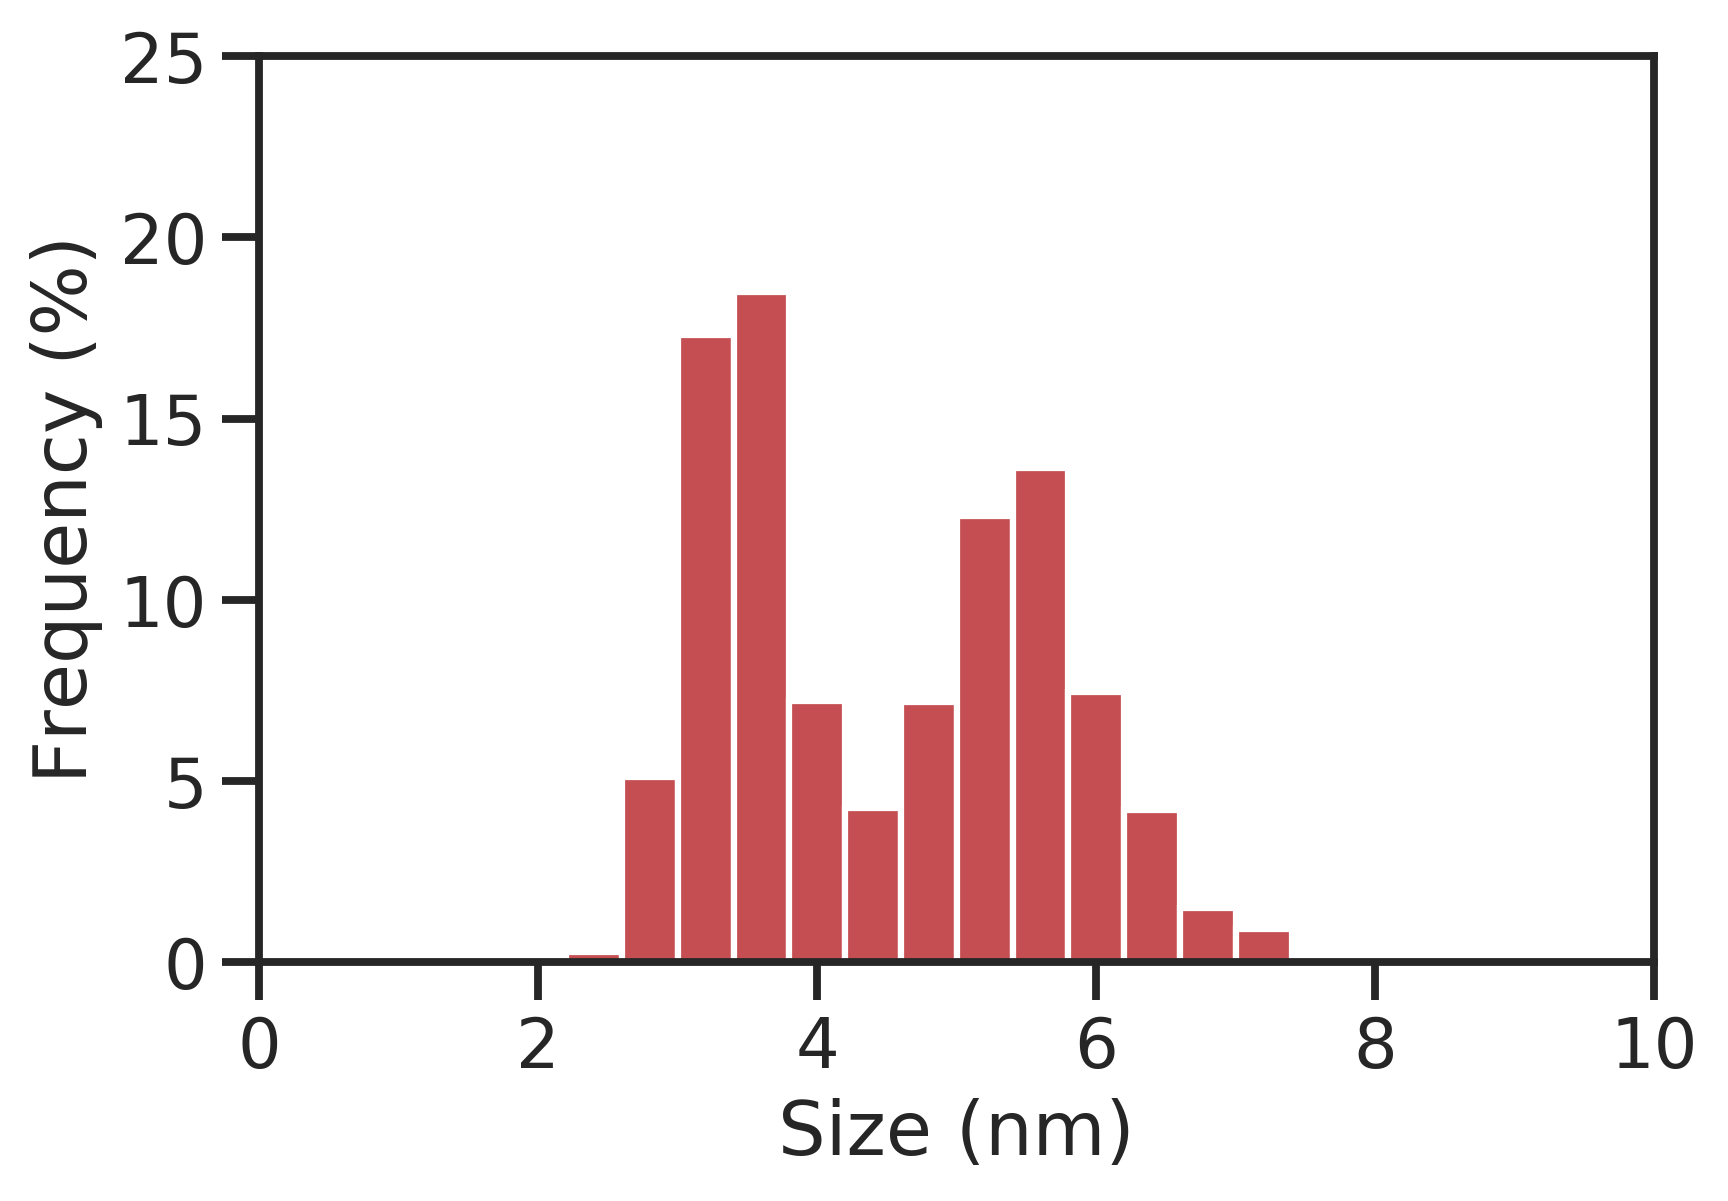

In [37]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,25))

(0, 25)

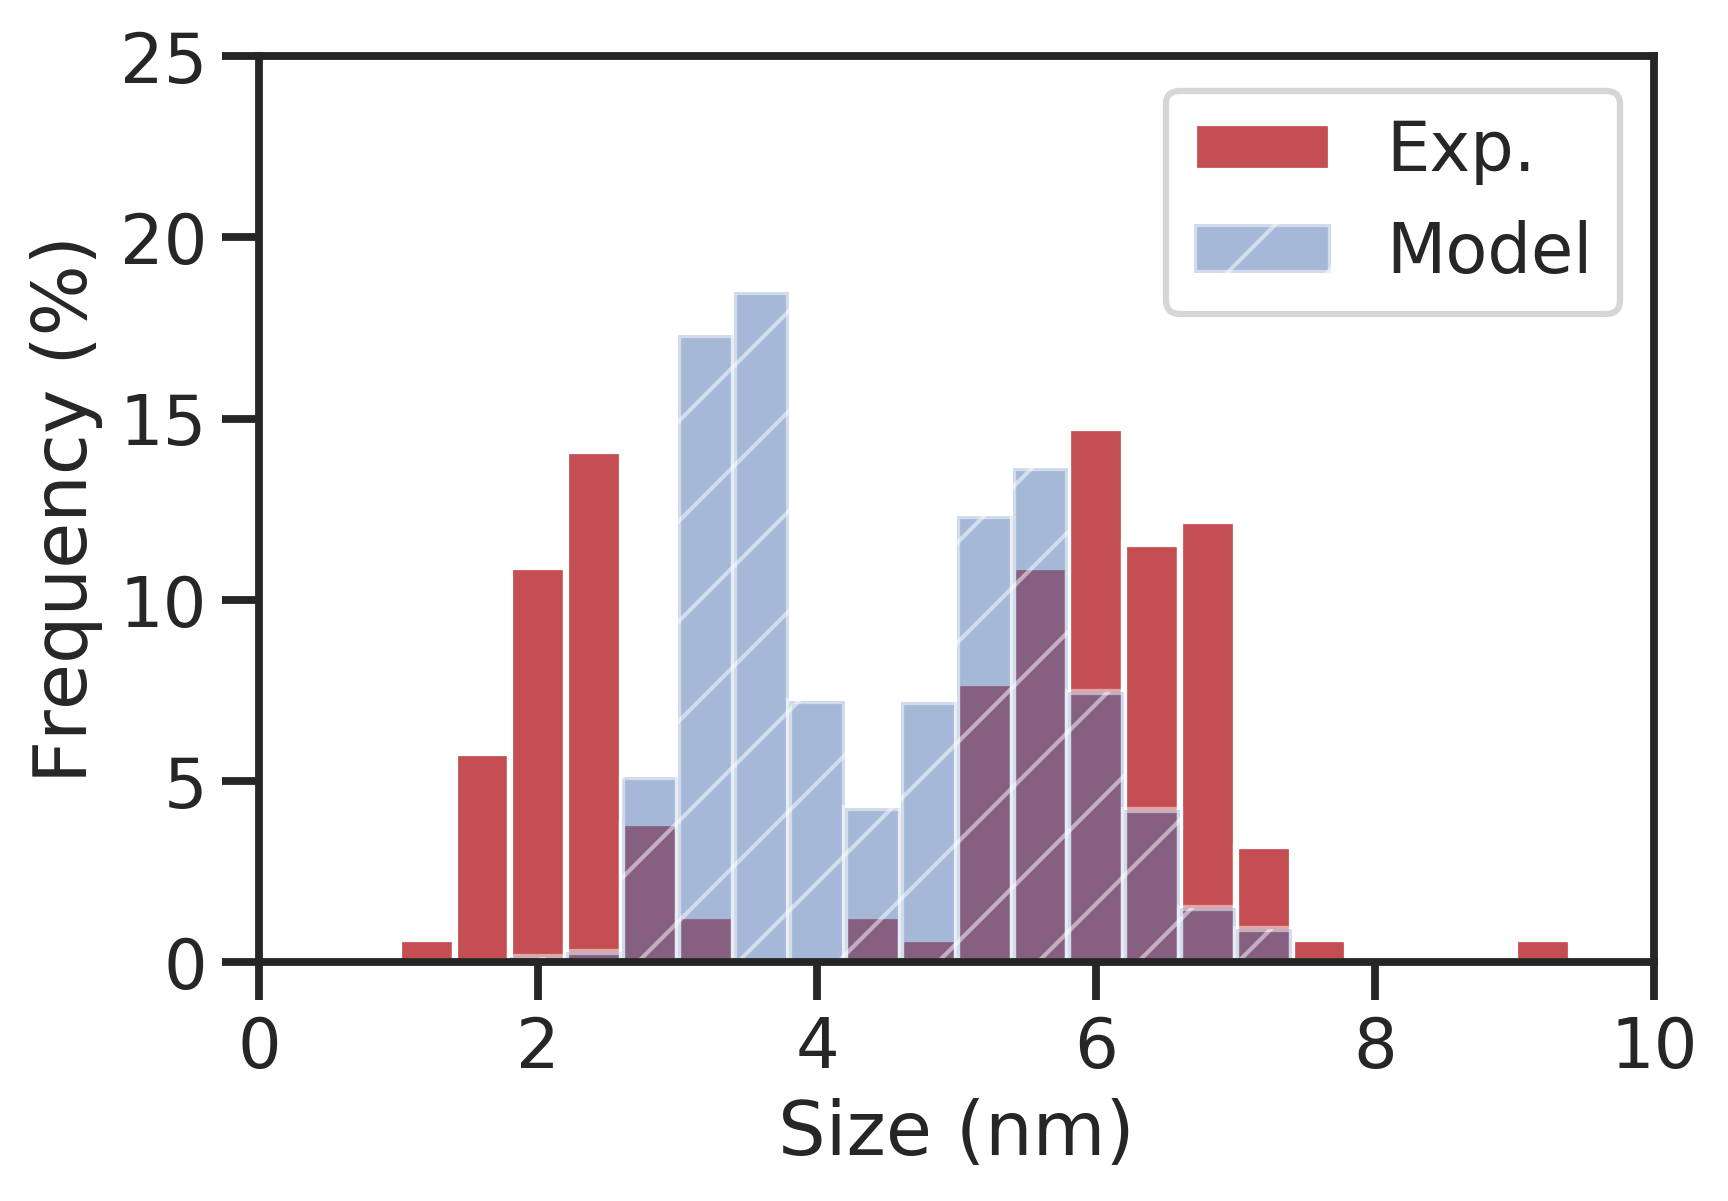

In [38]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,25))

(0, 30)

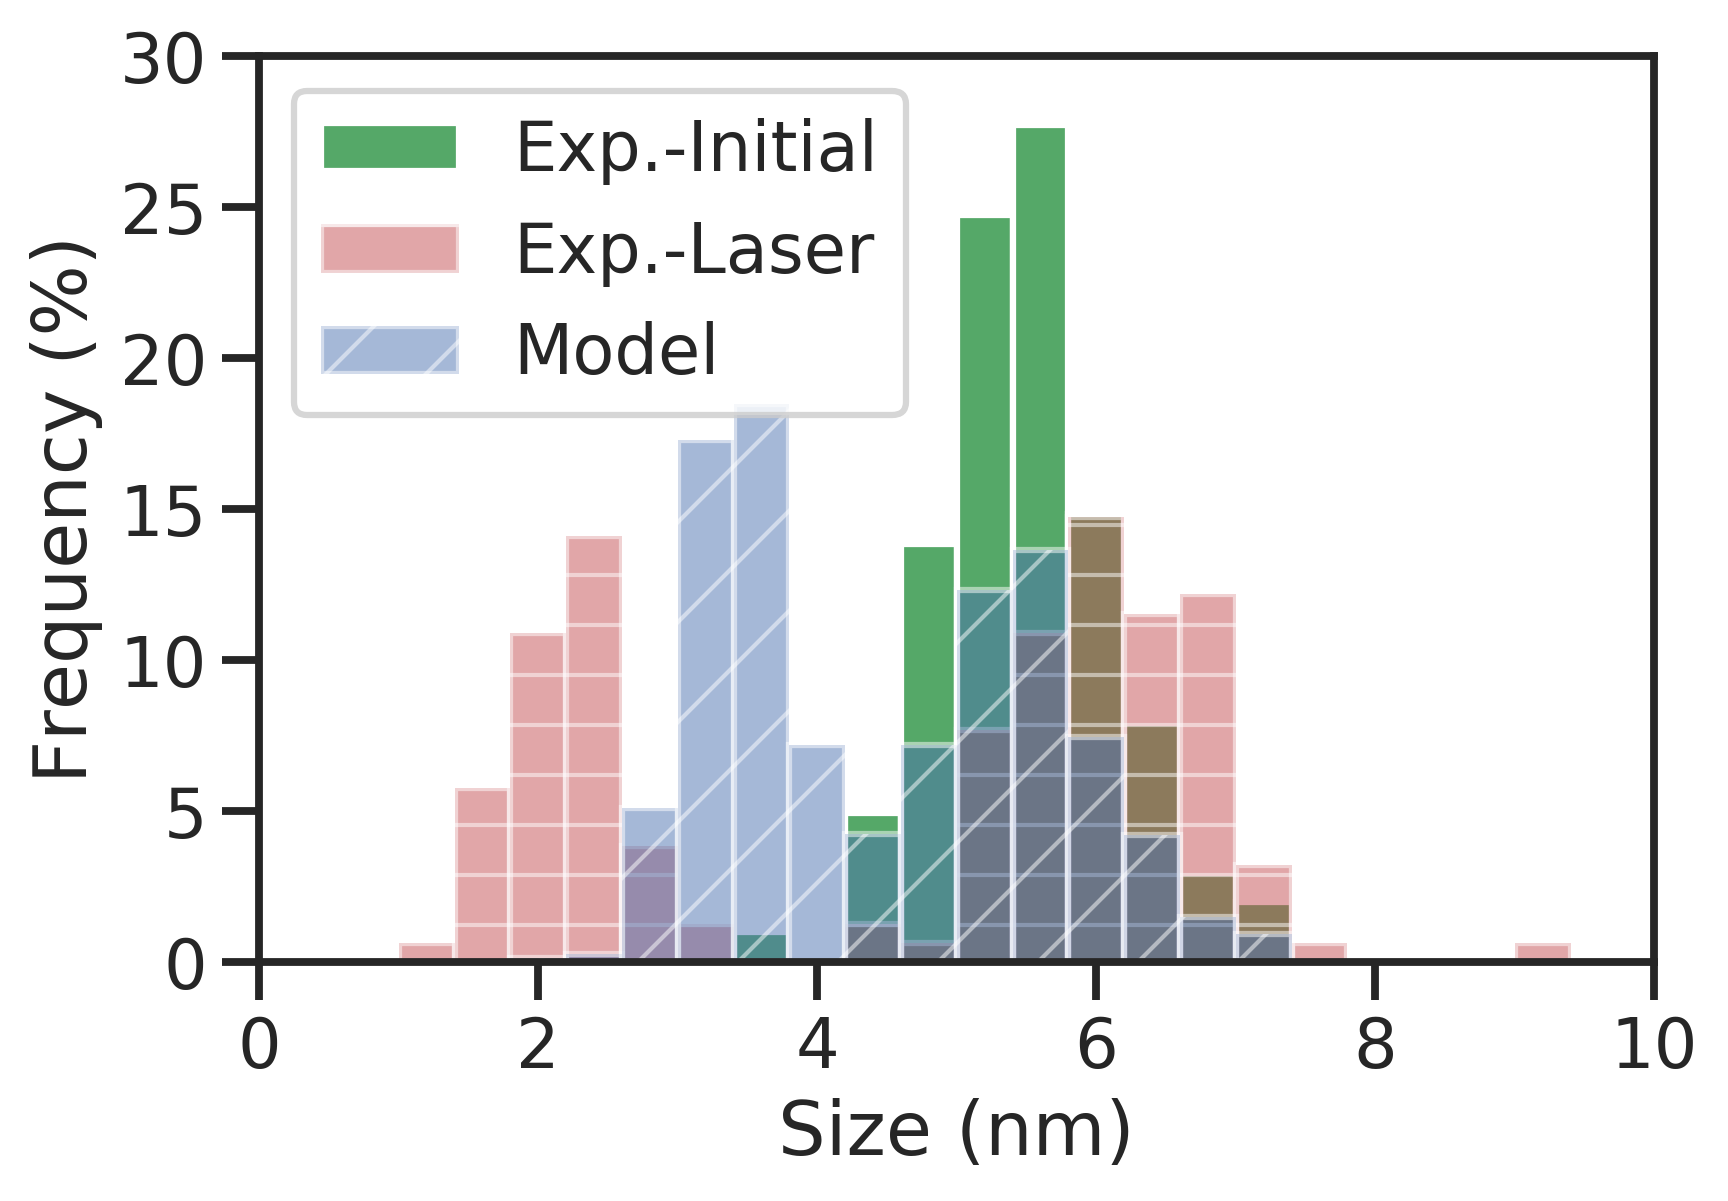

In [39]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,30))

## Particle Split - Eight Particles

Here, we apply a model for 1/5 of particles splitting into four particles of equal volume particles, so that the ratio of fragments to unfragmented particles is 1:1.

In [41]:
Vo = (4/3)*np.pi*rads**3
Vfrag = Vo[:int(0.111*len(Vo))]/8
rfrag = ((3/4)*Vfrag/np.pi)**(1/3) 
Dfrag = rfrag*2

In [42]:
frag_sizes = np.concatenate((Dfrag, Dfrag, Dfrag, Dfrag, Dfrag, Dfrag, Dfrag, Dfrag, sample_sizes[int(0.111*len(Vo)):]))

In [43]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[  0   0   0  40 256]
[0.         0.         0.         0.22509848 1.44063028]


(0, 25)

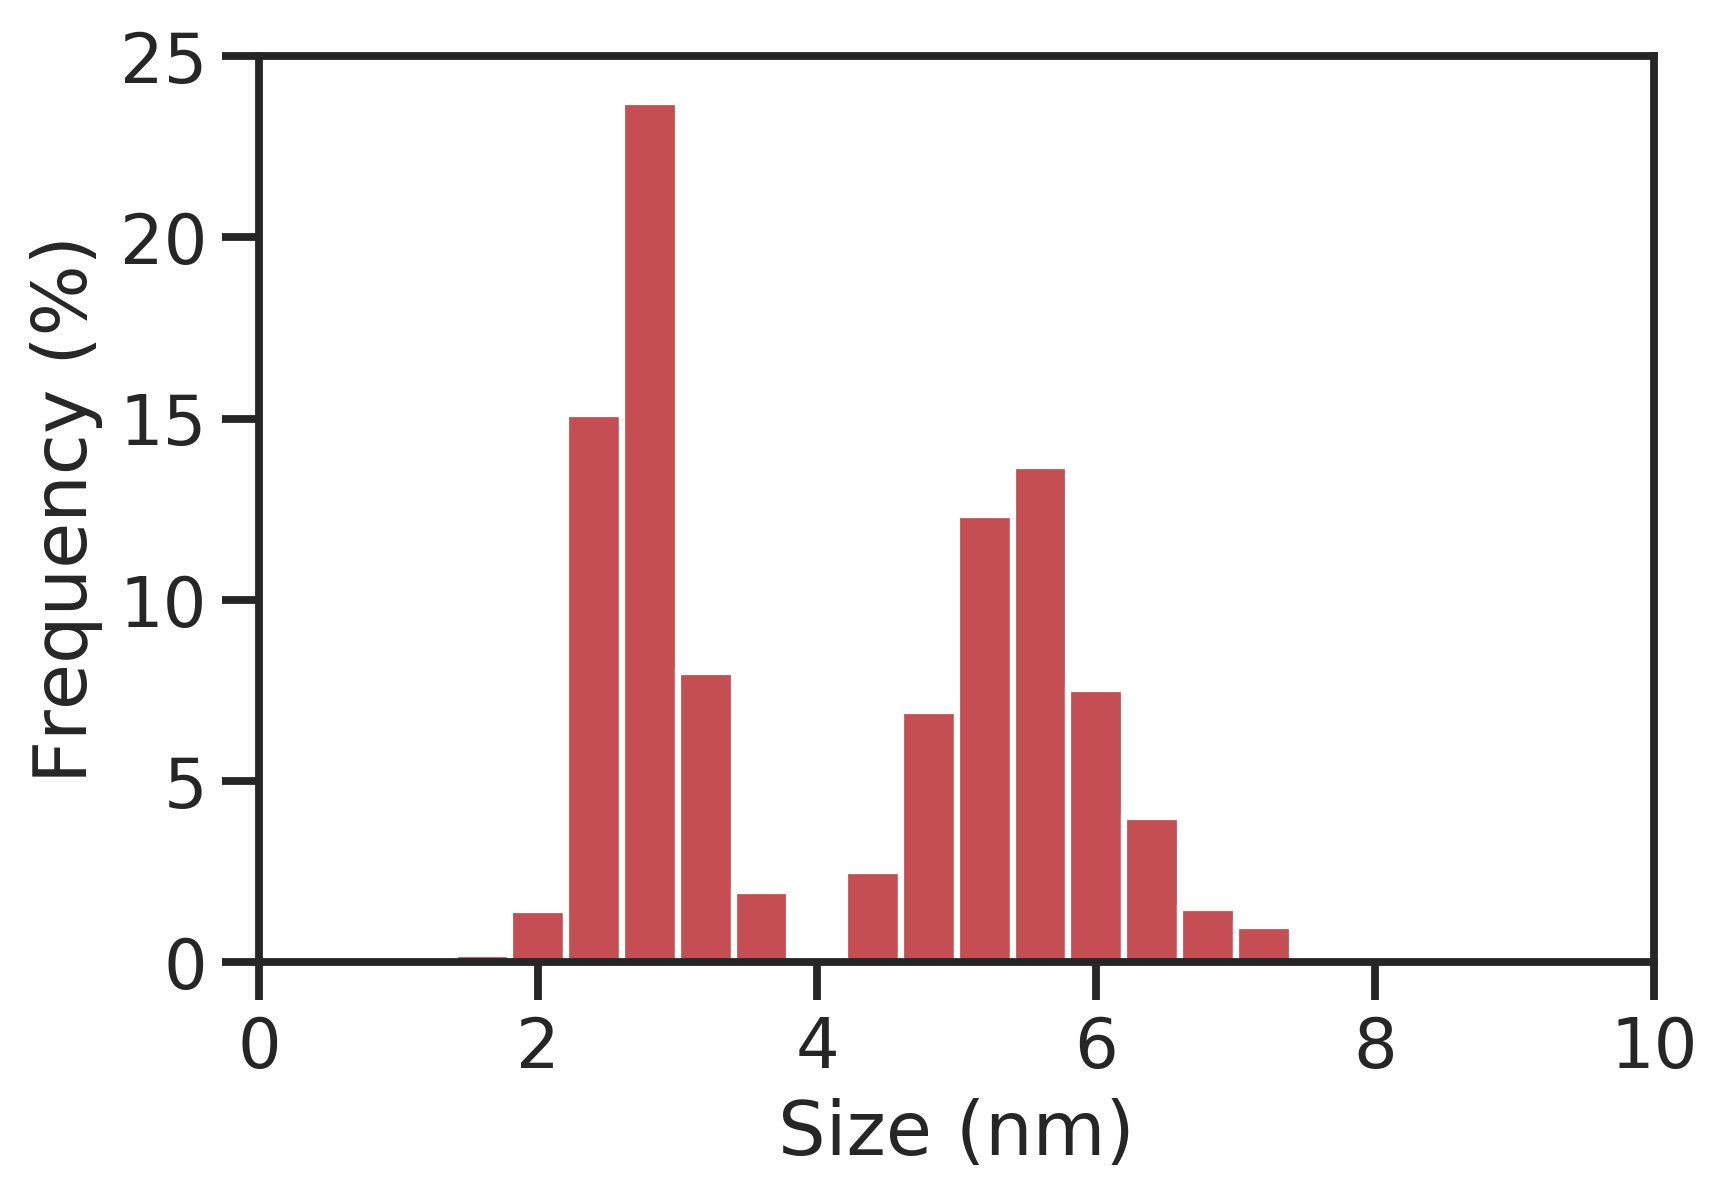

In [44]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,25))

In [45]:
np.savetxt('5nm_explore_frequency_ps_8part.txt', frag_freq)

(0, 25)

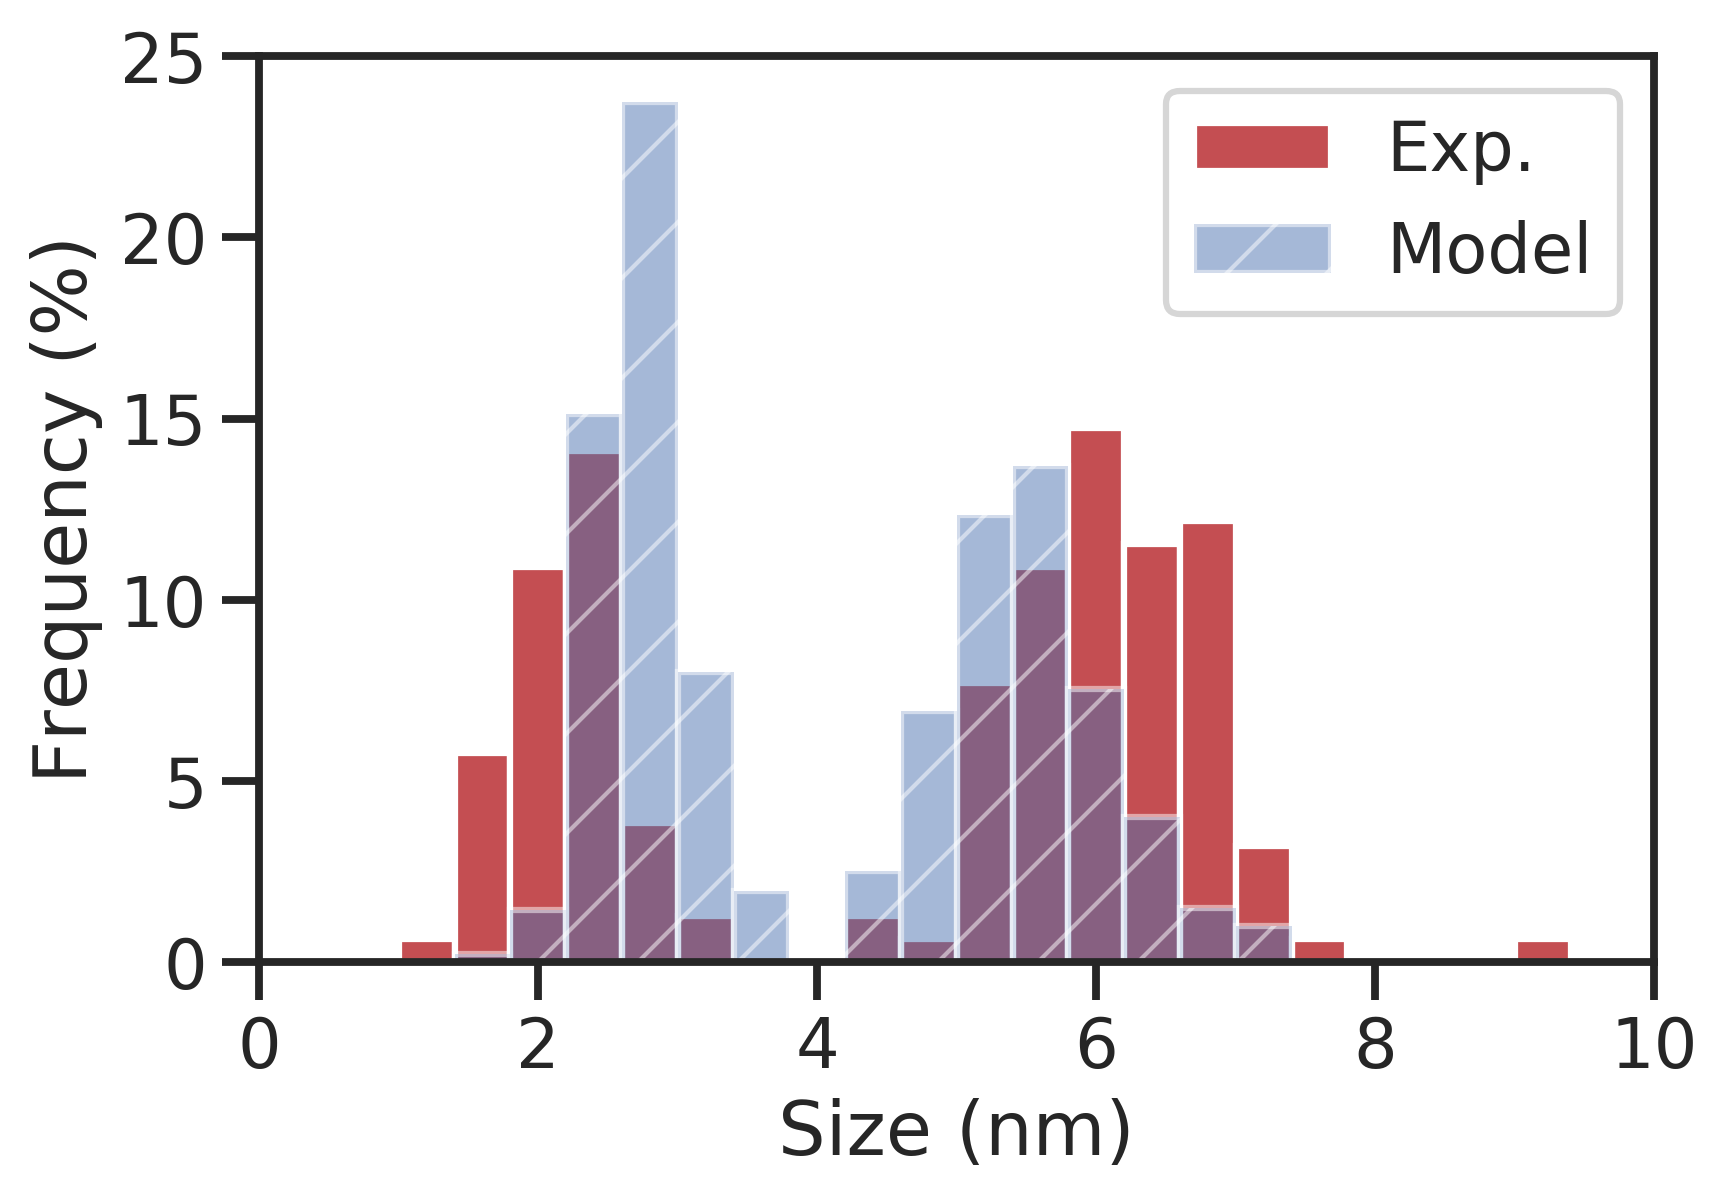

In [46]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,25))

(0, 30)

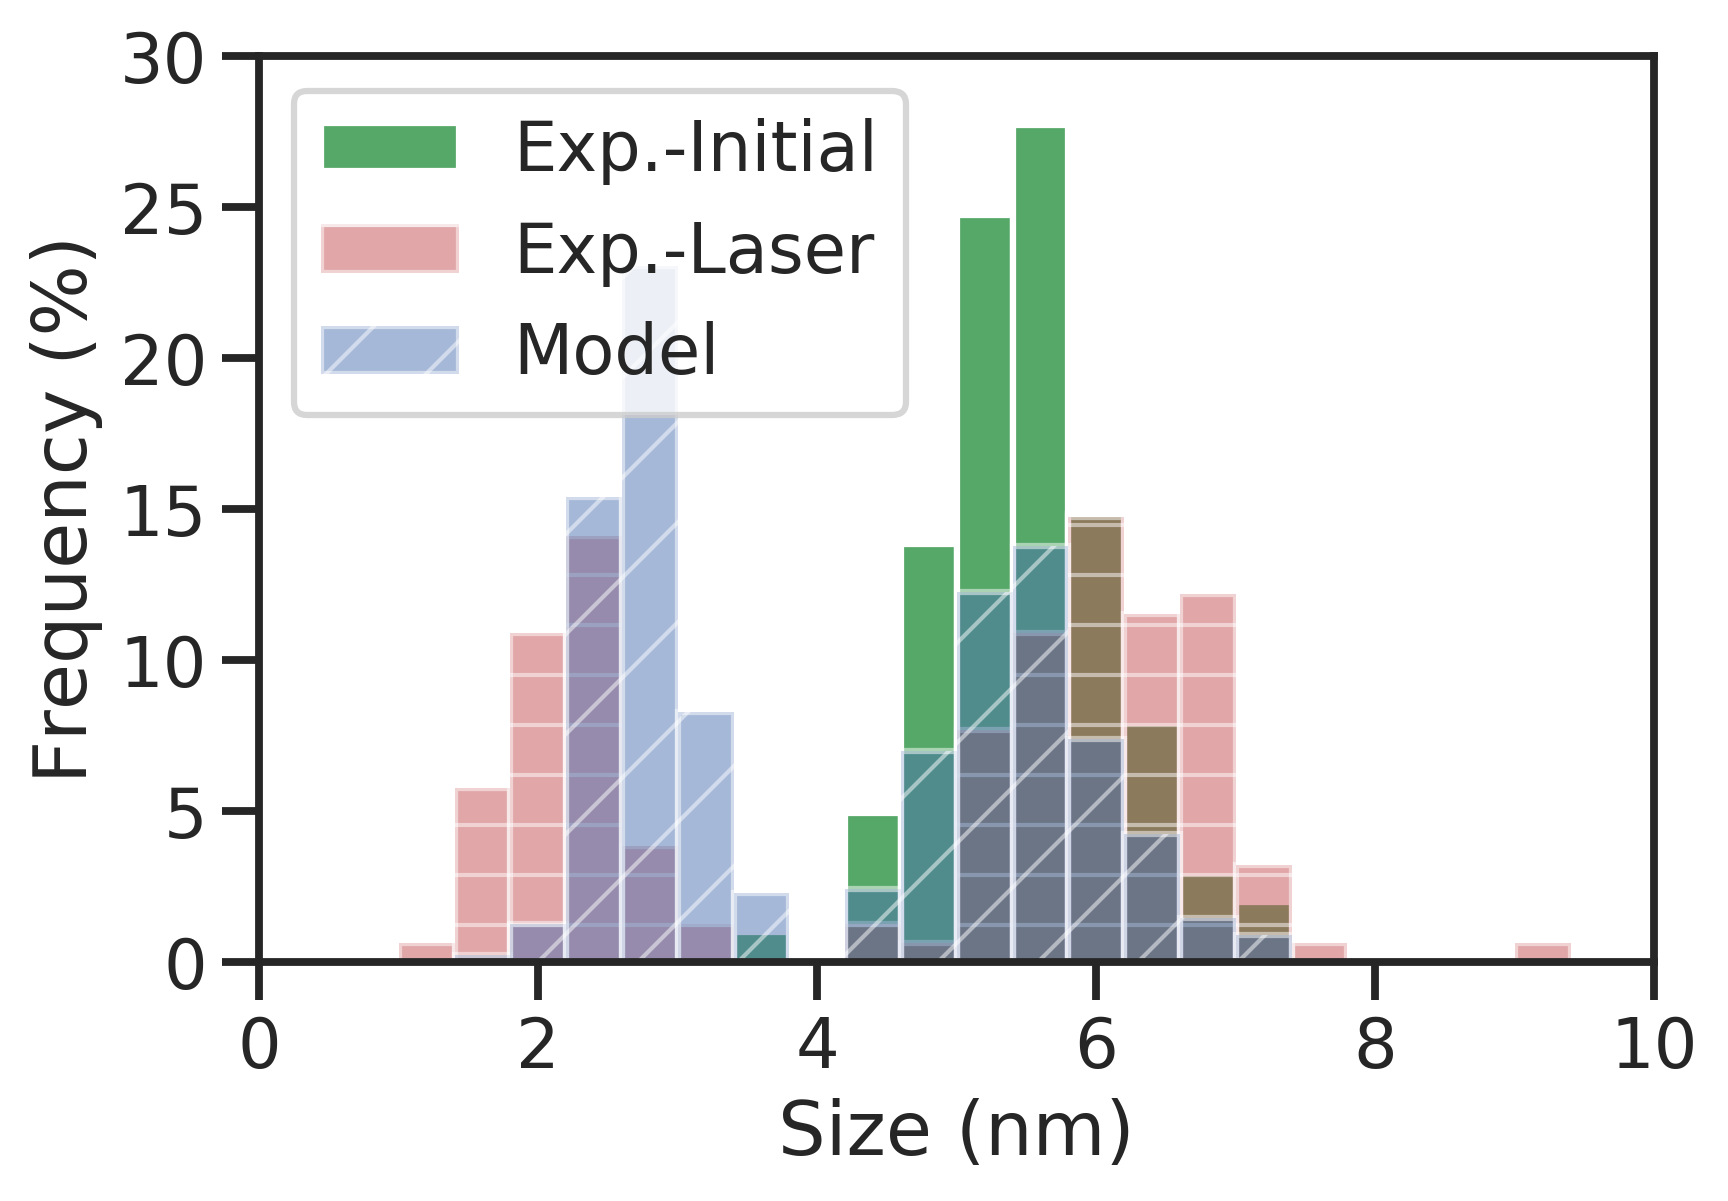

In [45]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,30))

## Surface Layer Ablation - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [211]:
# The initial guess of parameters for Nelder-Mead
# Pfrag, fsl, Ndsl
#initial_guess = np.array([0.5, 0.06, 4]) 
# Bounds for Nelder-Mead
#bounds = list([[0.05, 1], [0.01, 0.1], [1, 10]])

In [212]:
# Minimize using the minimize function from scipy with Nelder-Mead method.
# opt_res stands for Optimizer Result
#opt_res = minimize(cost_surface_ablation, initial_guess, method='Nelder-Mead', bounds=bounds)
# run it
#fit_parms = opt_res.x # index 0 is Pfrag, index 1 is fsl, index 2 is Ndsl
#fit_cost = opt_res.fun
#print(fit_parms, fit_cost)

/home/blake/miniconda3/envs/molechyperthermia/lib/python3.8/site-packages/scipy/optimize/_minimize.py:521: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


[0.11656725 0.07592448 4.82372242] 522.5595964249645


In [213]:
# Set the active point population size
population_size = 500
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_sa, fitness_surface_ablation, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_costs = -best_theta_fitness
print(fit_parms, fit_cost)

Generations: 100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


[0.23511194 0.04902629 2.7035187 ] 522.5595964249645


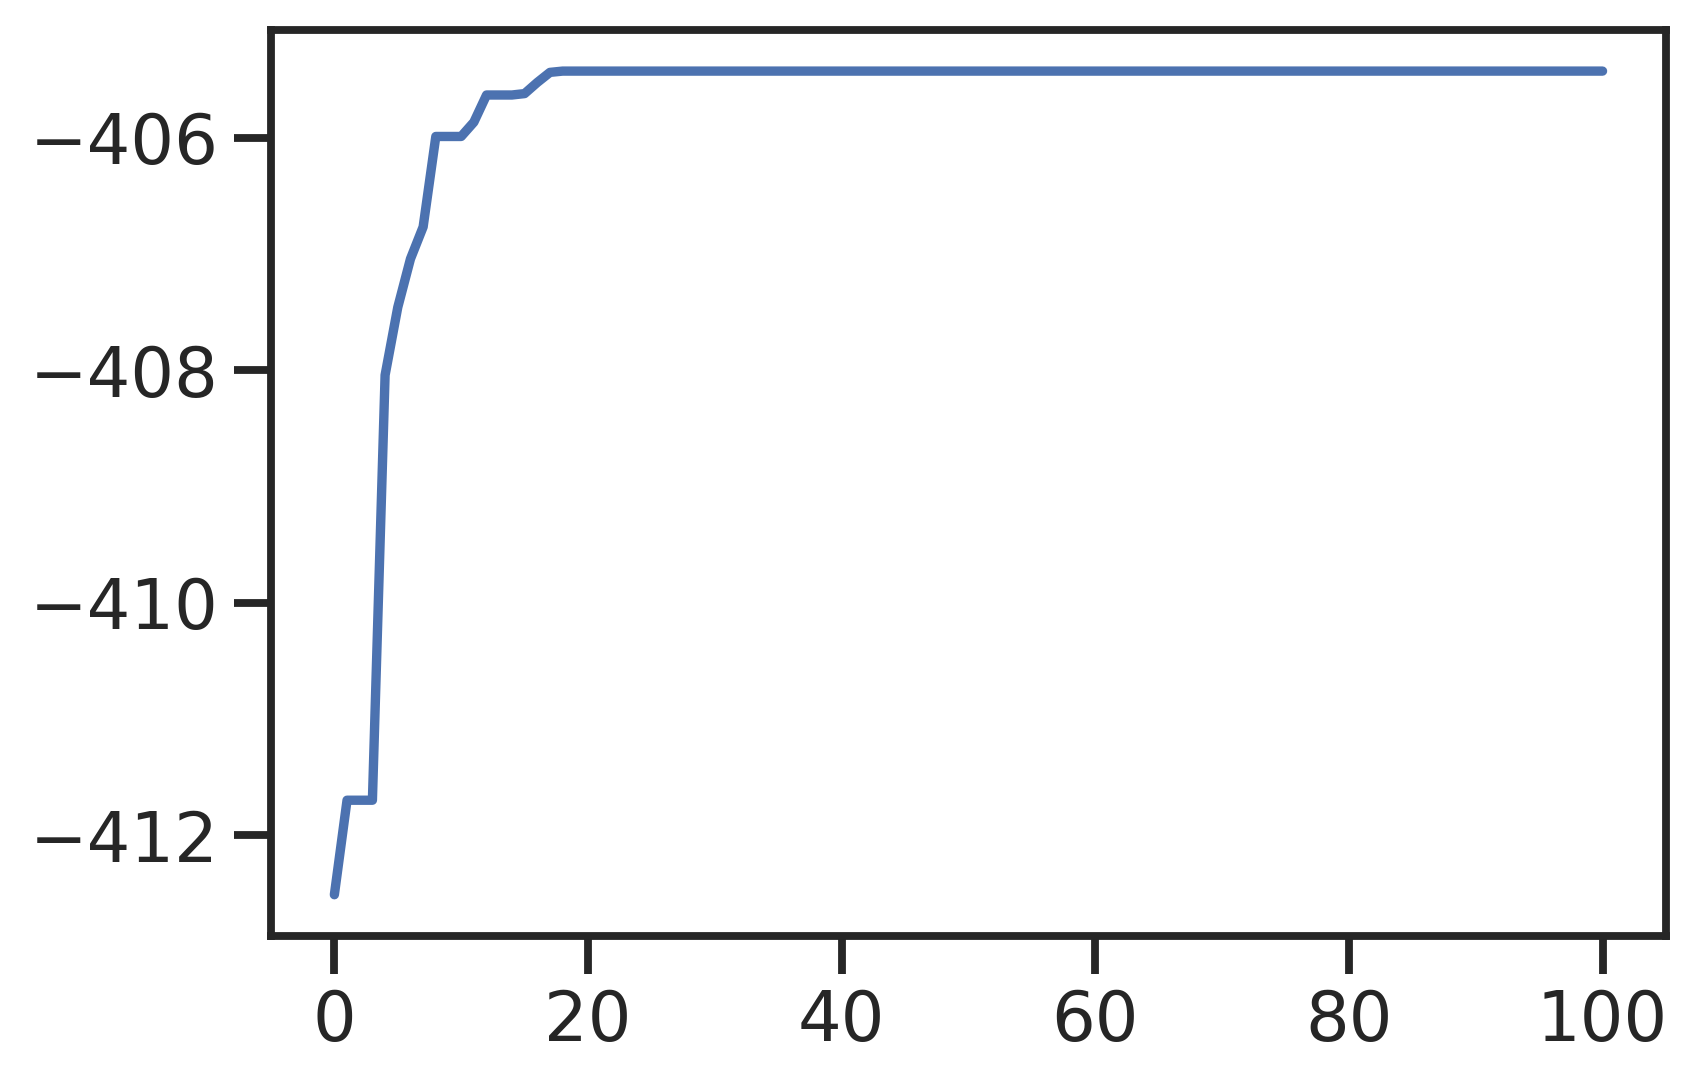

In [207]:
plt.plot(gao.best_fitness_per_generation)

In [214]:
fragments = surface_ablation(sample_sizes, fit_parms[0], fit_parms[1], int(fit_parms[2]))
frag_freq = fragment_frequency(fragments)

(0, 25)

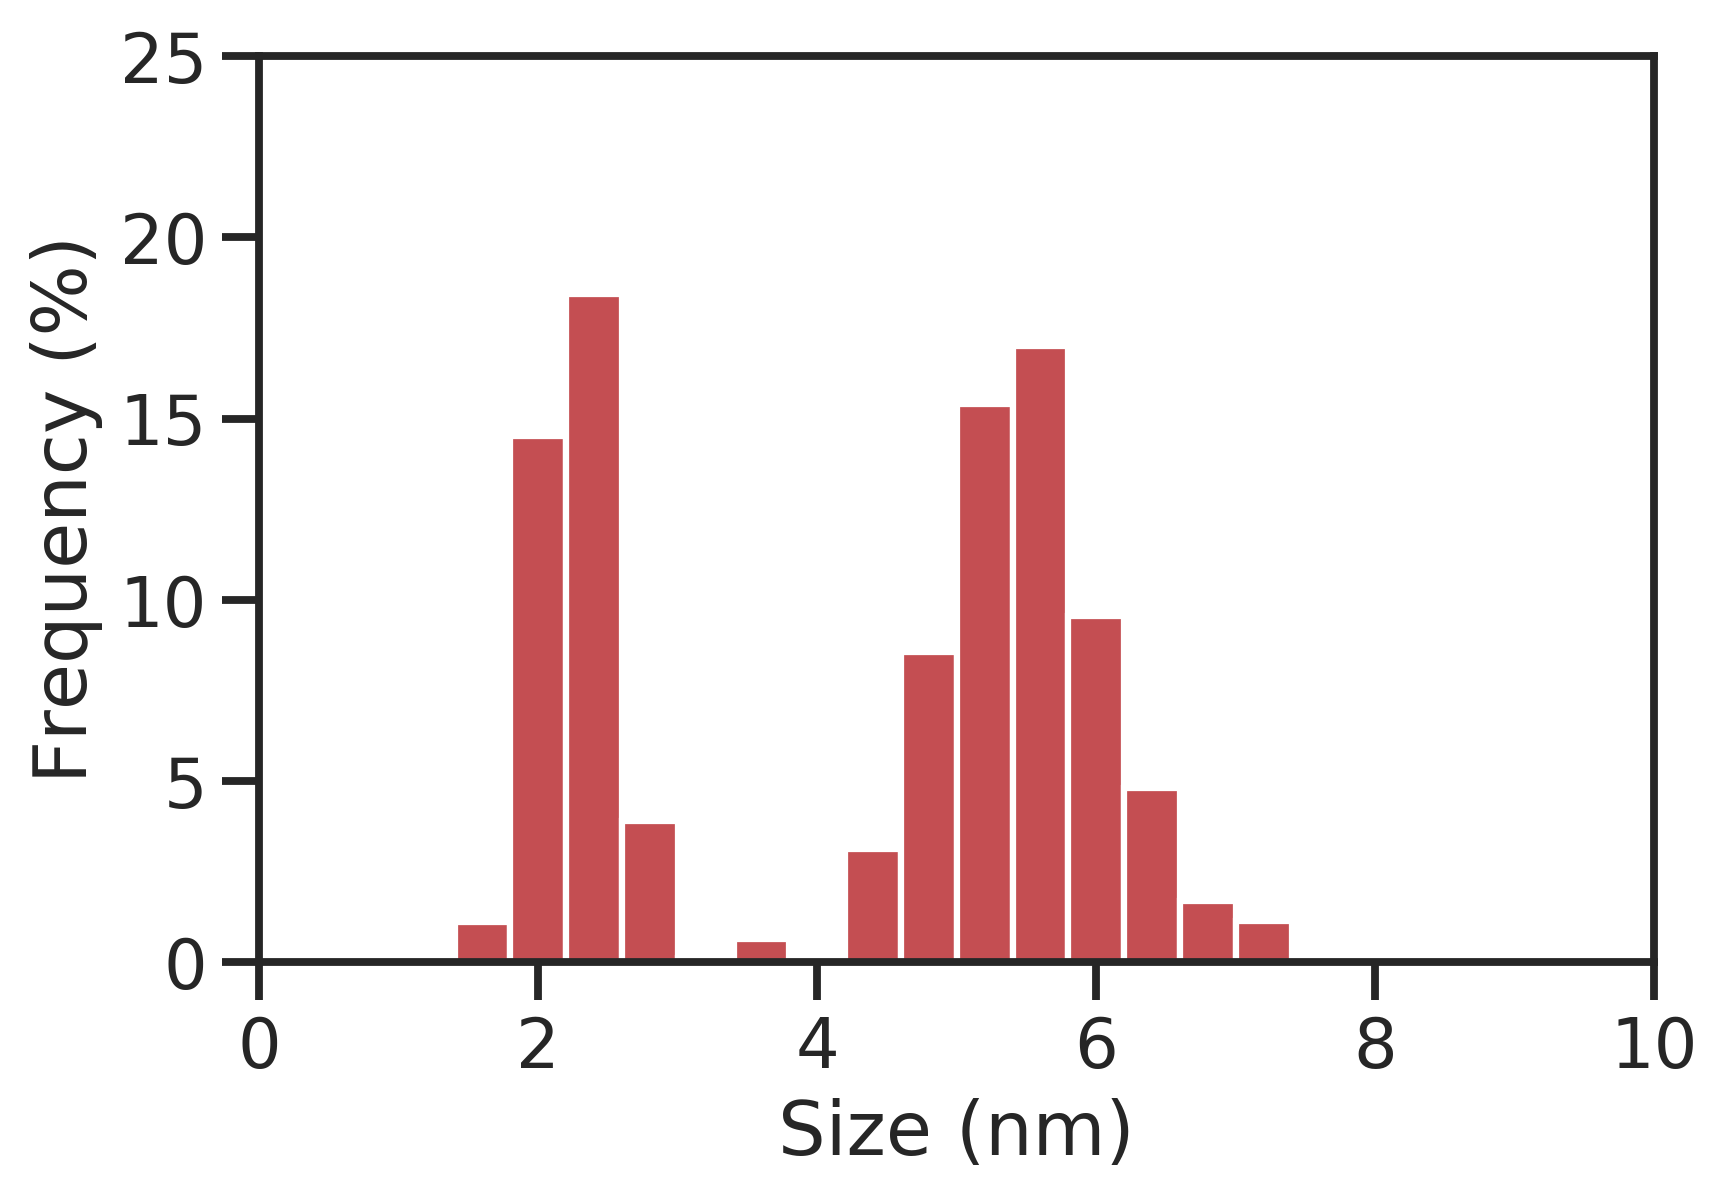

In [215]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,25))

(0, 25)

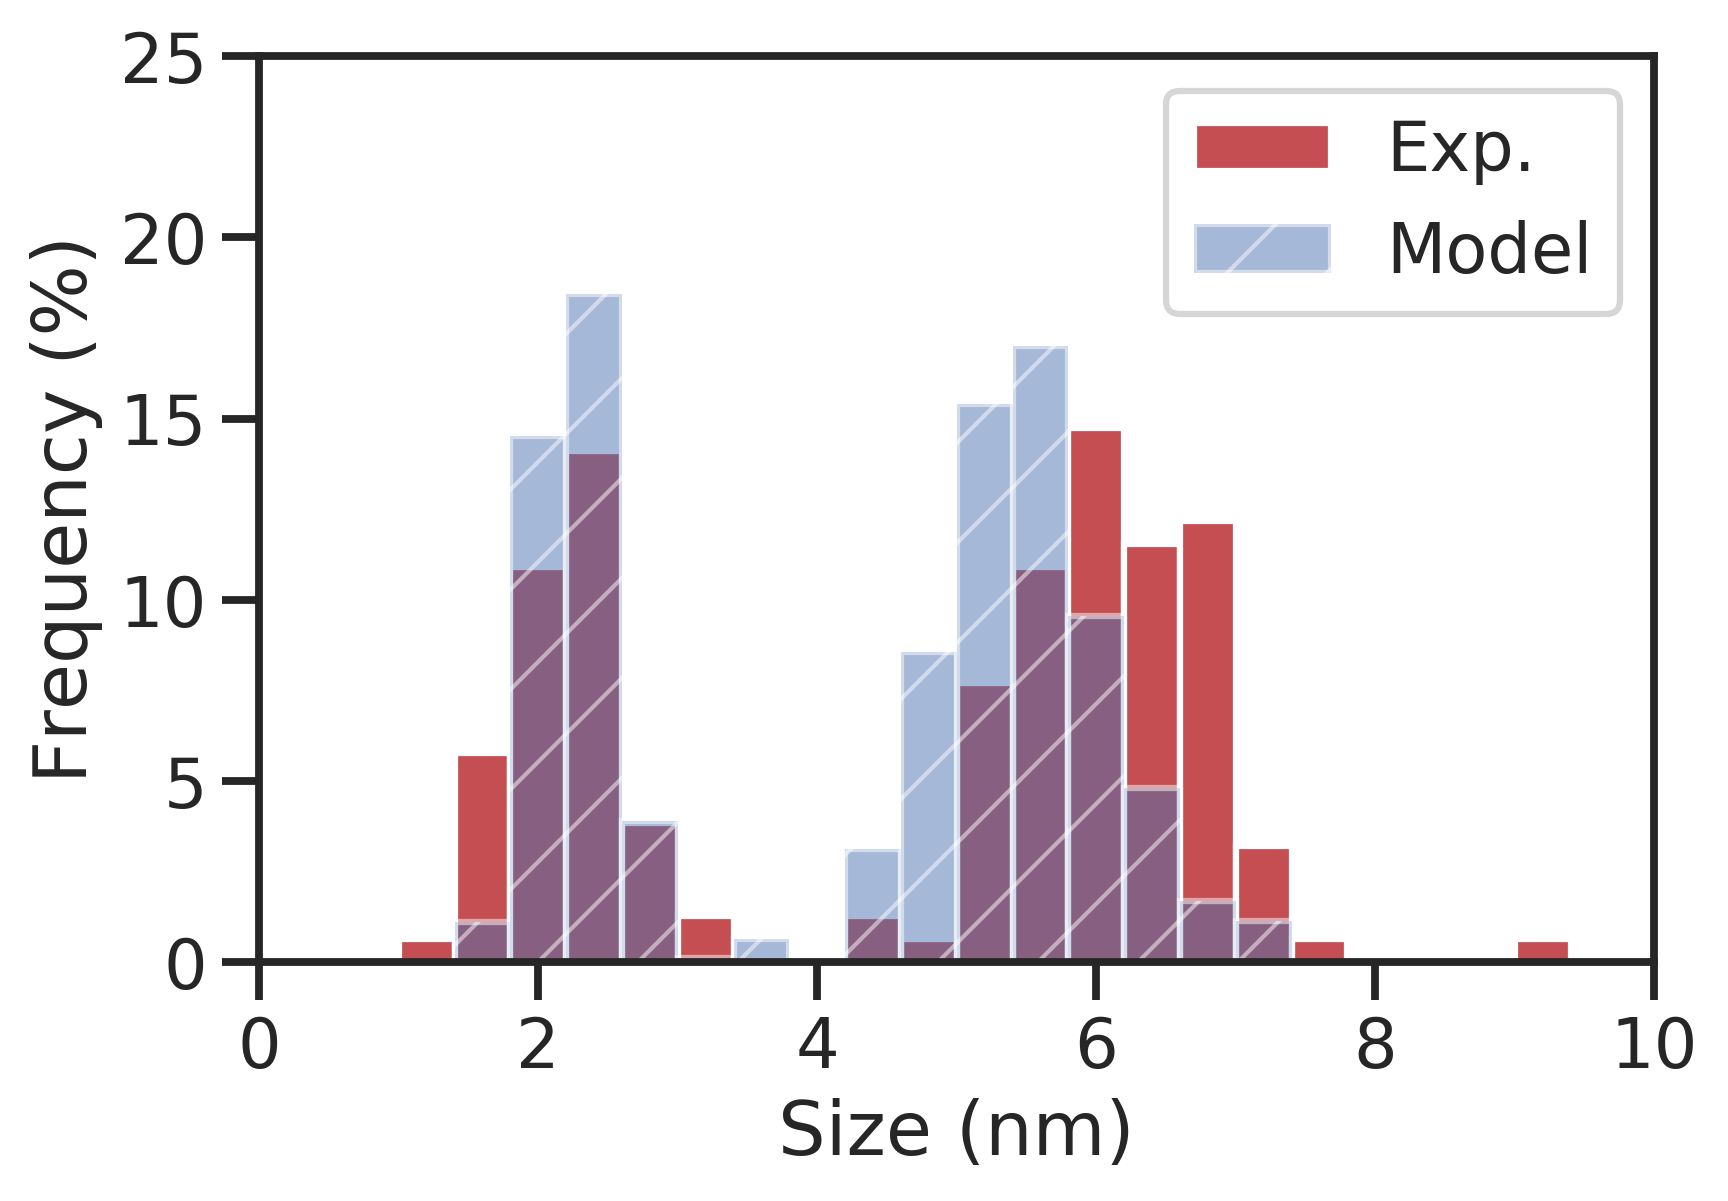

In [216]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,25))

## Particle Split - NLS Fit

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [211]:
# The initial guess of parameters for Nelder-Mead
# Pfrag, fsl, Ndsl
#initial_guess = np.array([0.5, 0.06, 4]) 
# Bounds for Nelder-Mead
#bounds = list([[0.05, 1], [0.01, 0.1], [1, 10]])

In [212]:
# Minimize using the minimize function from scipy with Nelder-Mead method.
# opt_res stands for Optimizer Result
#opt_res = minimize(cost_surface_ablation, initial_guess, method='Nelder-Mead', bounds=bounds)
# run it
#fit_parms = opt_res.x # index 0 is Pfrag, index 1 is fsl, index 2 is Ndsl
#fit_cost = opt_res.fun
#print(fit_parms, fit_cost)

/home/blake/miniconda3/envs/molechyperthermia/lib/python3.8/site-packages/scipy/optimize/_minimize.py:521: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


[0.11656725 0.07592448 4.82372242] 522.5595964249645


In [219]:
# Set the active point population size
population_size = 500
# Construct the Genetic Algorithm-based Optimizer.
gao = GAO(sampled_parameters_ps, fitness_particle_split, population_size,
          generations=100,
          mutation_rate=0.05)
# run it
best_theta, best_theta_fitness = gao.run()
fit_parms = 10**best_theta
fit_costs = -best_theta_fitness
print(fit_parms, fit_cost)

Generations:   0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'Ndsl' is not defined

In [ ]:
plt.plot(gao.best_fitness_per_generation)

In [ ]:
fragments = surface_ablation(sample_sizes, fit_parms[0], fit_parms[1], int(fit_parms[2]))
frag_freq = fragment_frequency(fragments)

In [ ]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,25))

In [ ]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,10))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,25))

# 15 nm

In [47]:
# Load the data
dist = pd.read_csv('15nm_distribution.csv')
dist.head()

size  initial     laser
0     2  0.00000   2.30769
1     4  0.00000  36.92308
2     6  0.13661  17.69231
3     8  0.13661   0.76923
4    10  0.27322   0.00000

In [48]:
# Get the histogram bin centers
centers = dist['size'].to_numpy()
centers

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24])

In [49]:
# Histogram bin width
bw = centers[1] - centers[0]
bw

2

In [50]:
# Create the corresponding edges for the histogram
edges = np.linspace(centers[0] - 0.5*bw, centers[-1] + 0.5*bw, len(centers)+1, endpoint=True)
edges

array([ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23., 25.])

In [51]:
# Create a distribution object from the histogrammed frequencies.
rv_initial = rv_histogram((dist['initial'].to_numpy(), edges))
rv_initial

In [52]:
sample_sizes = rv_initial.rvs(size=10000)
sample_sizes[:10]

array([16.09999743, 16.65806911, 18.02452977, 16.83548169, 15.35709923,
       16.1147826 , 16.24079885, 15.16216375, 16.44417691, 15.53596788])

[0.   0.   0.15 0.1  0.27]


(0, 60)

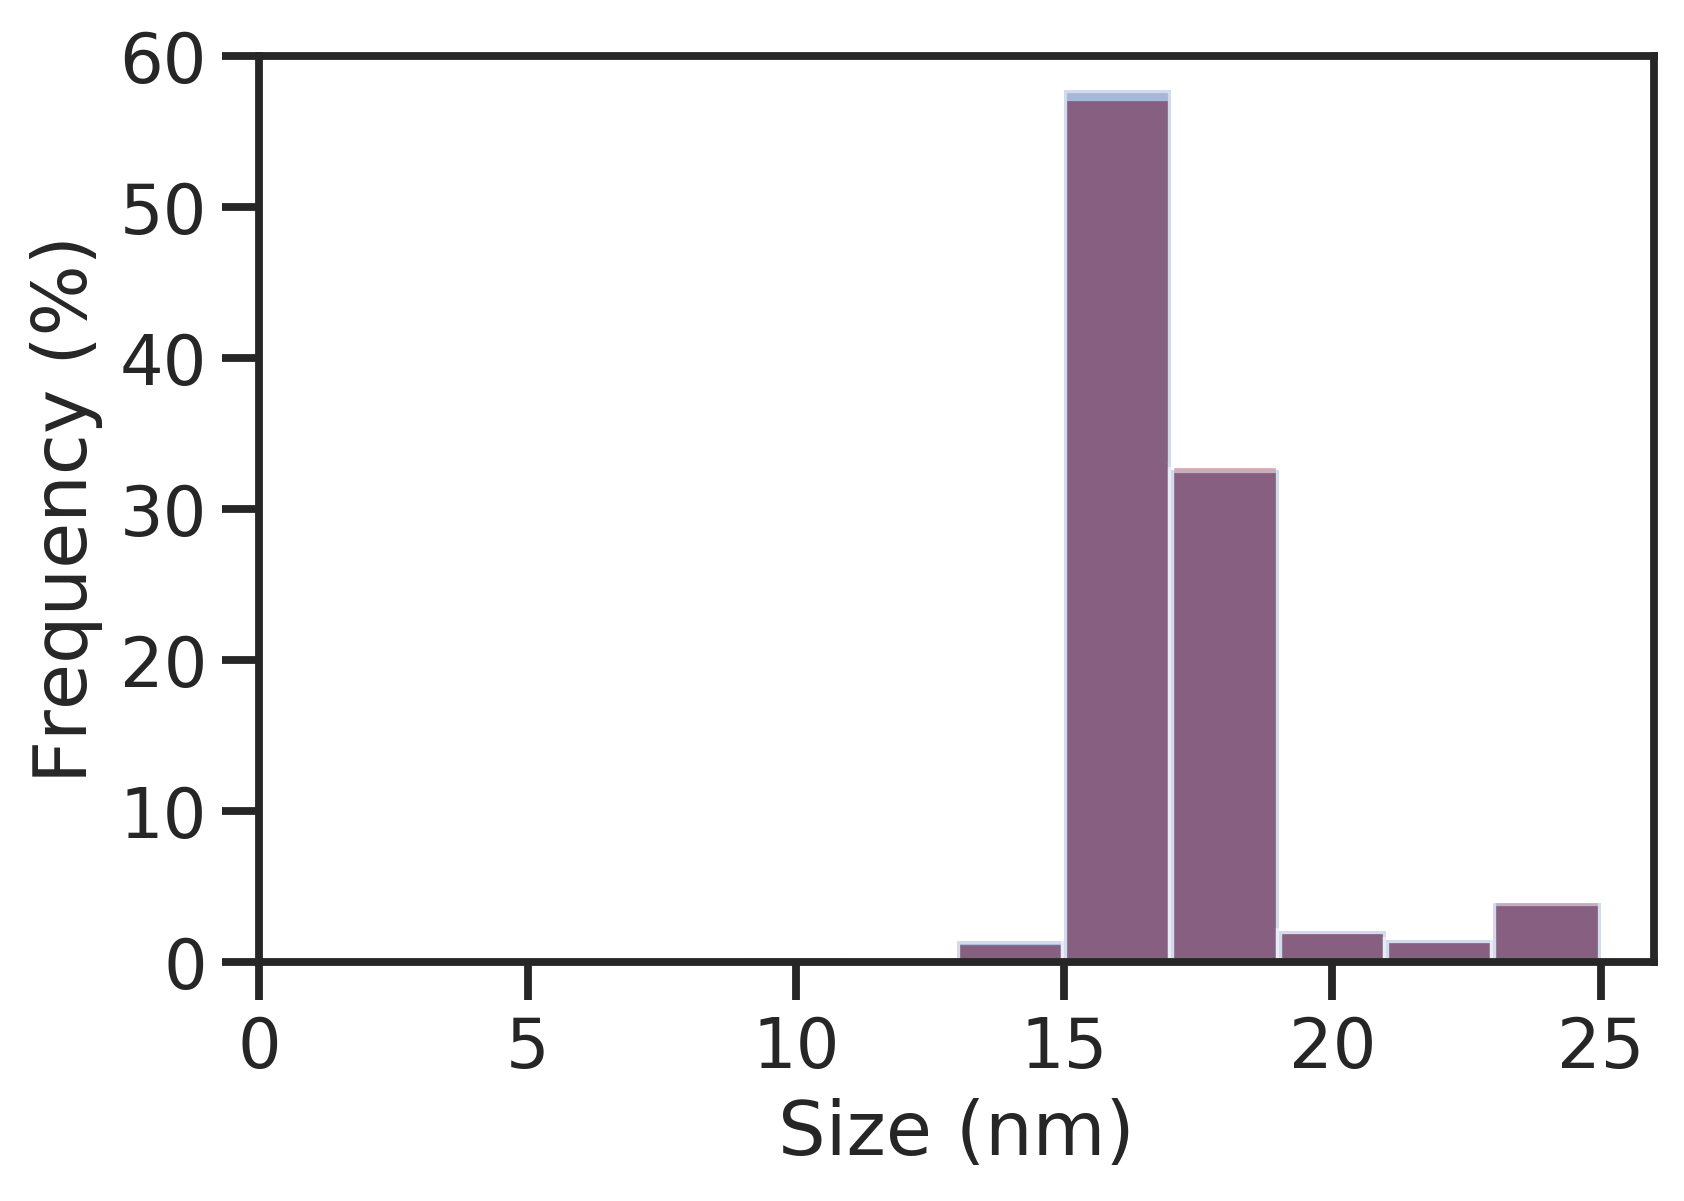

In [53]:
counts, _edges = np.histogram(sample_sizes, bins=edges)

freq = 100 * counts / len(sample_sizes)
print(freq[:5])
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.hist(centers, bins=edges, weights=freq, color='b', alpha=0.5)
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

## Surface Layer Ablation - Single Particle

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [54]:
rads = sample_sizes / 2
shell_width = 0.06 * rads
print(shell_width[:5])
rcore = rads - shell_width
Dcore = 2 * rcore
rsl = ( rads**3 - rcore**3)**(1/3)
print(rsl[:5])
Dsl = 2 * rsl
print(Dsl[:5])

[0.48299992 0.49974207 0.54073589 0.50506445 0.46071298]
[4.45431185 4.60871096 4.98676331 4.65779488 4.24877764]
[8.90862369 9.21742192 9.97352663 9.31558975 8.49755528]


In [55]:
frag_sizes = np.concatenate((Dsl, Dcore))

In [56]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[   5   22   62 3742 5582]
[2.500e-02 1.100e-01 3.100e-01 1.871e+01 2.791e+01]


(0, 60)

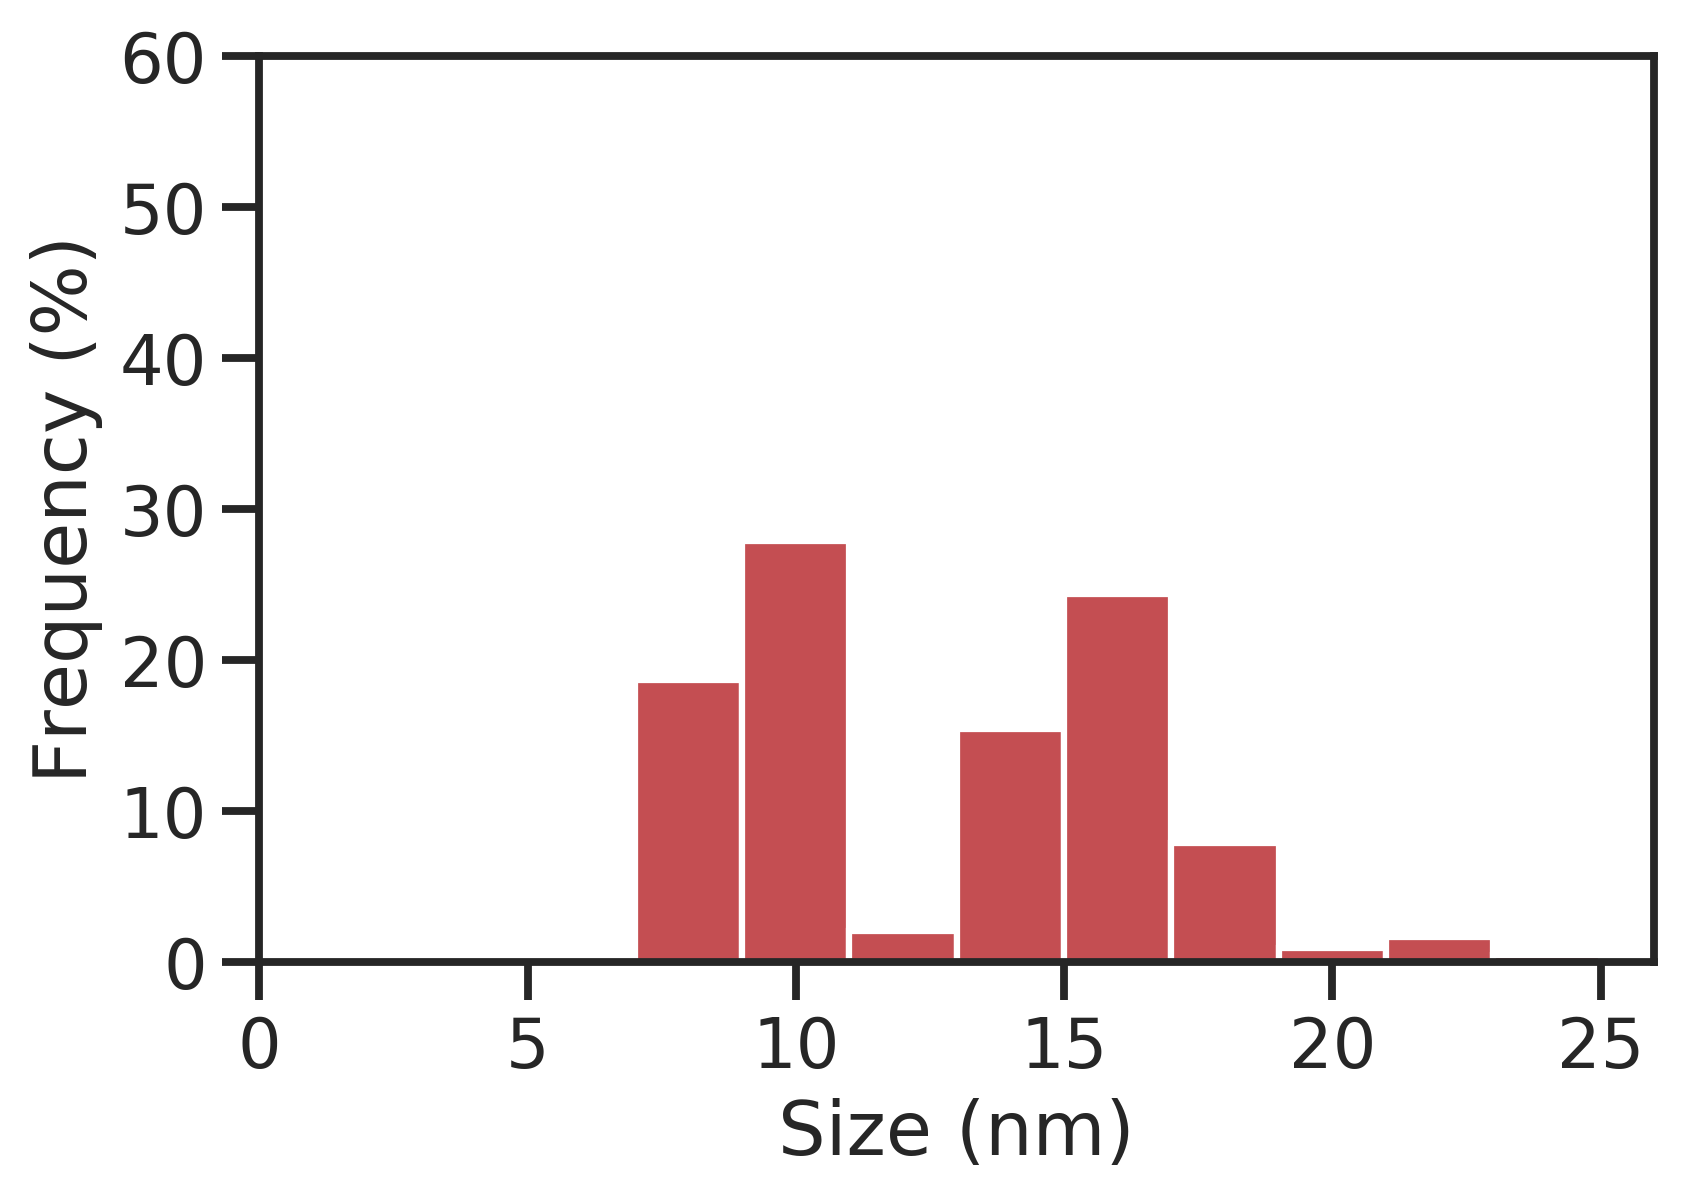

In [57]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

In [58]:
np.savetxt('15nm_explore_centers.txt', centers)
np.savetxt('15nm_explore_edges.txt', edges)
np.savetxt('15nm_explore_frequency_sa_1part.txt', frag_freq)

(0, 60)

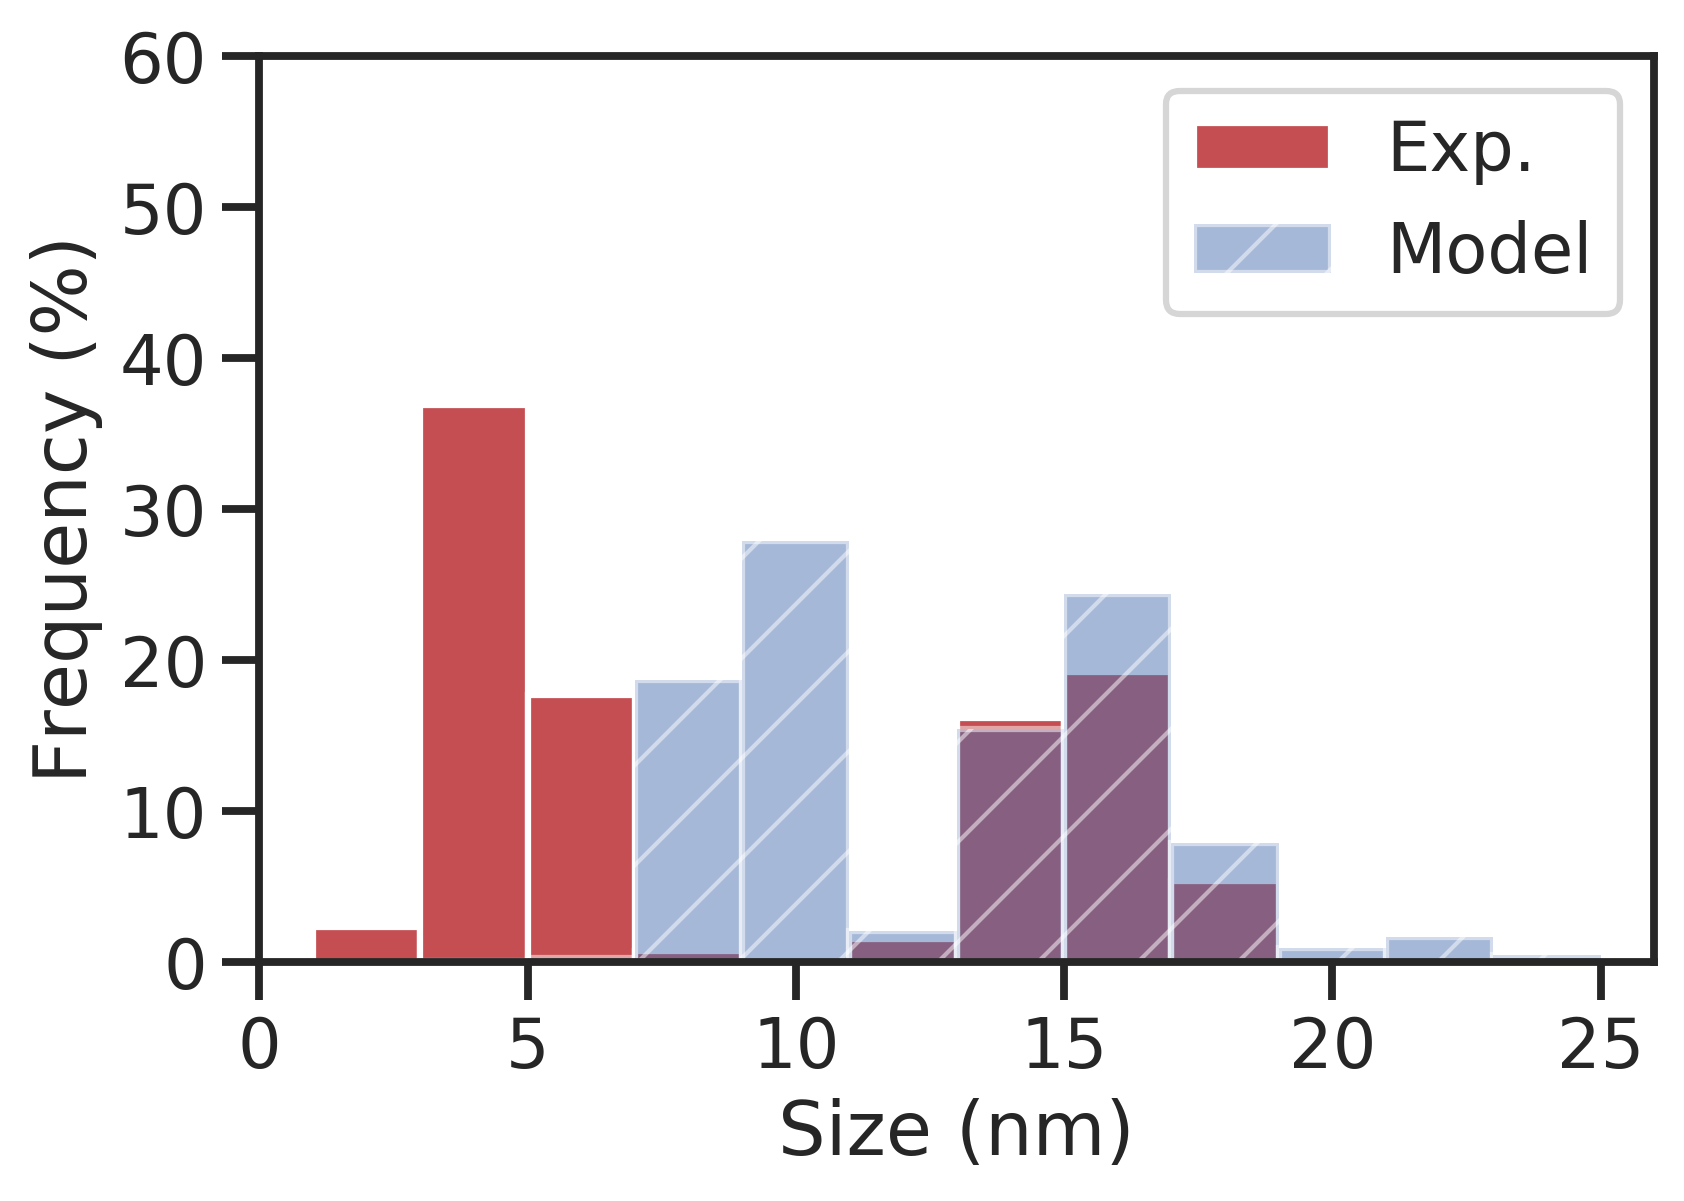

In [59]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,60))

## Surface Layer Ablation - Two Particles

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms two equal volume particles so that there are three daughter particles: two corresponding to the surface layer and one for the remaining particle core.

In [60]:
shell_width = 0.015 * rads
print(shell_width[:5])
rcore = rads - shell_width
Dcore = 2 * rcore
rsl = ( rads**3 - rcore**3)**(1/3)
rfrag = rsl/(2)**(1/3)
print(rsl[:5])
Dfrag = 2 * rfrag
print(Dsl[:5])

[0.12074998 0.12493552 0.13518397 0.12626611 0.11517824]
[2.84898228 2.94773611 3.18953877 2.97913023 2.7175224 ]
[8.90862369 9.21742192 9.97352663 9.31558975 8.49755528]


In [61]:
frag_sizes = np.concatenate((Dfrag, Dfrag, Dcore))

In [62]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[   94 14540  5359    32    31]
[ 0.31333333 48.46666667 17.86333333  0.10666667  0.10333333]


(0, 60)

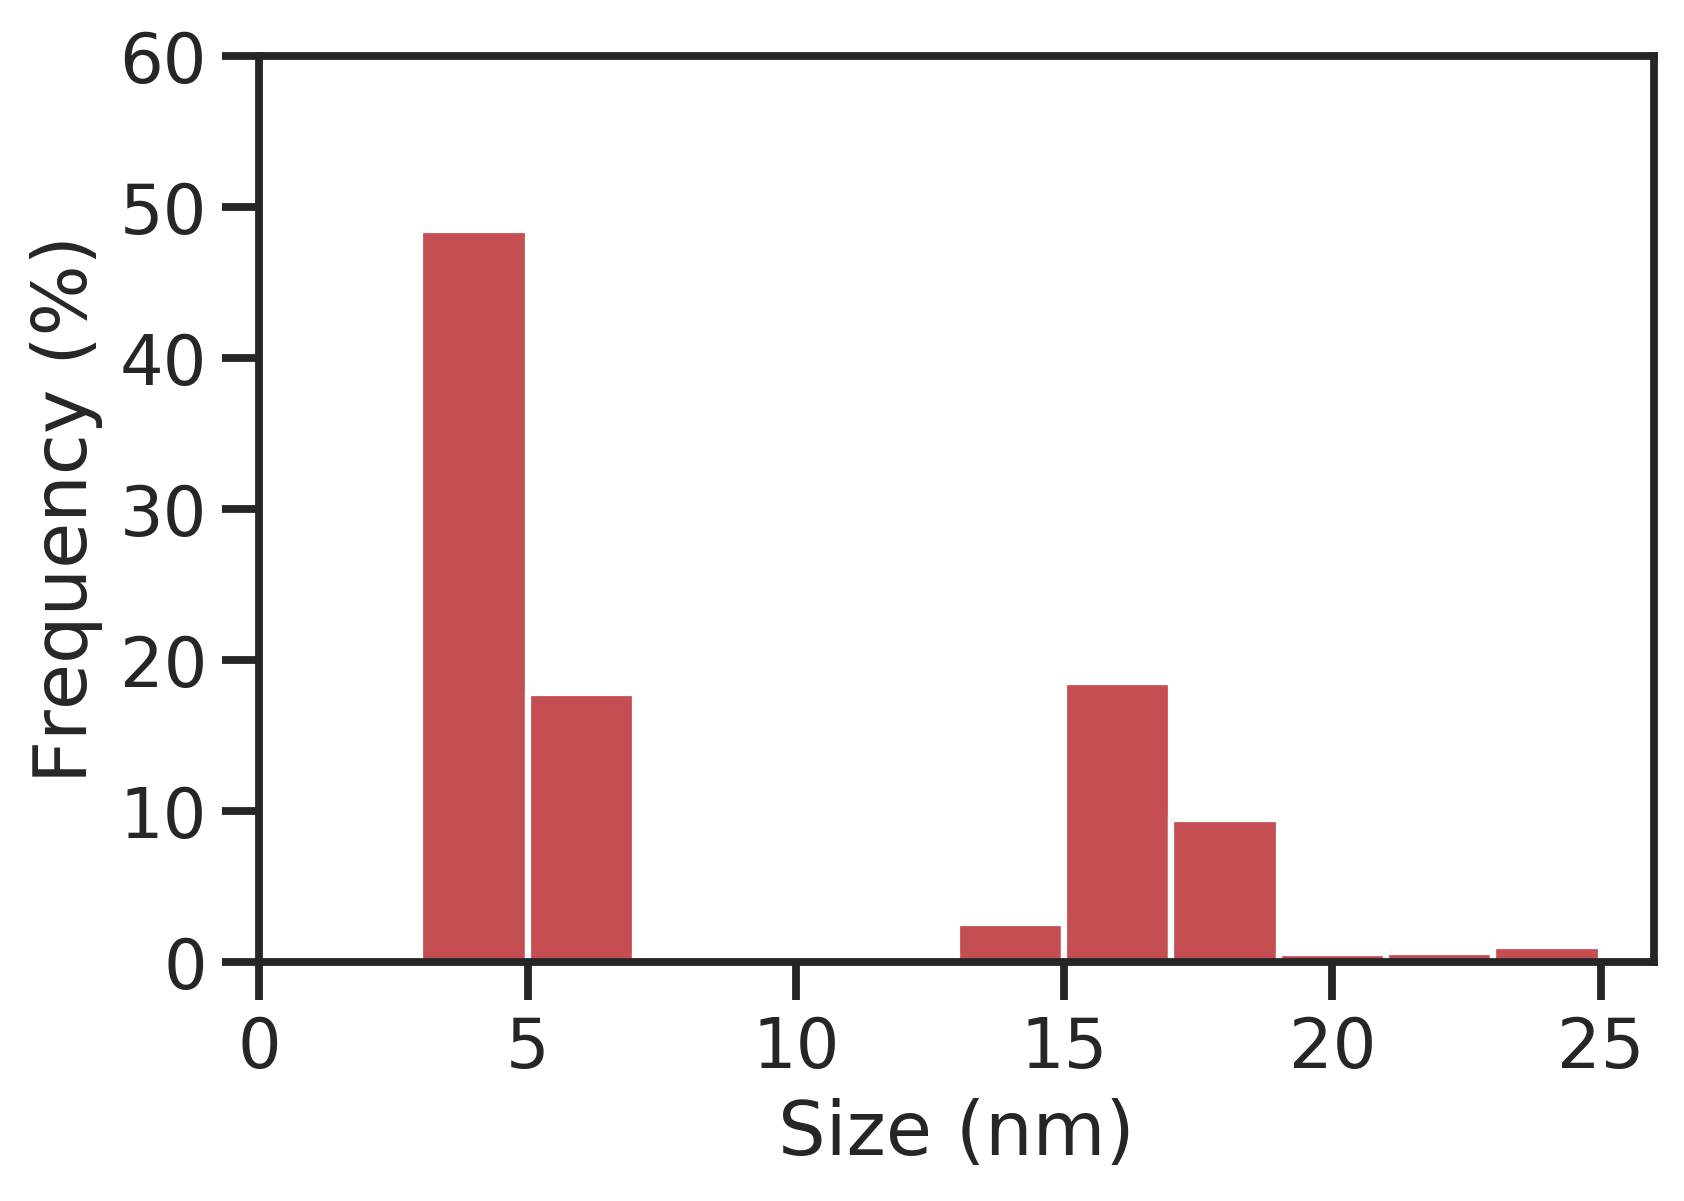

In [63]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

In [64]:
np.savetxt('15nm_explore_frequency_sa_2part.txt', frag_freq)

(0, 60)

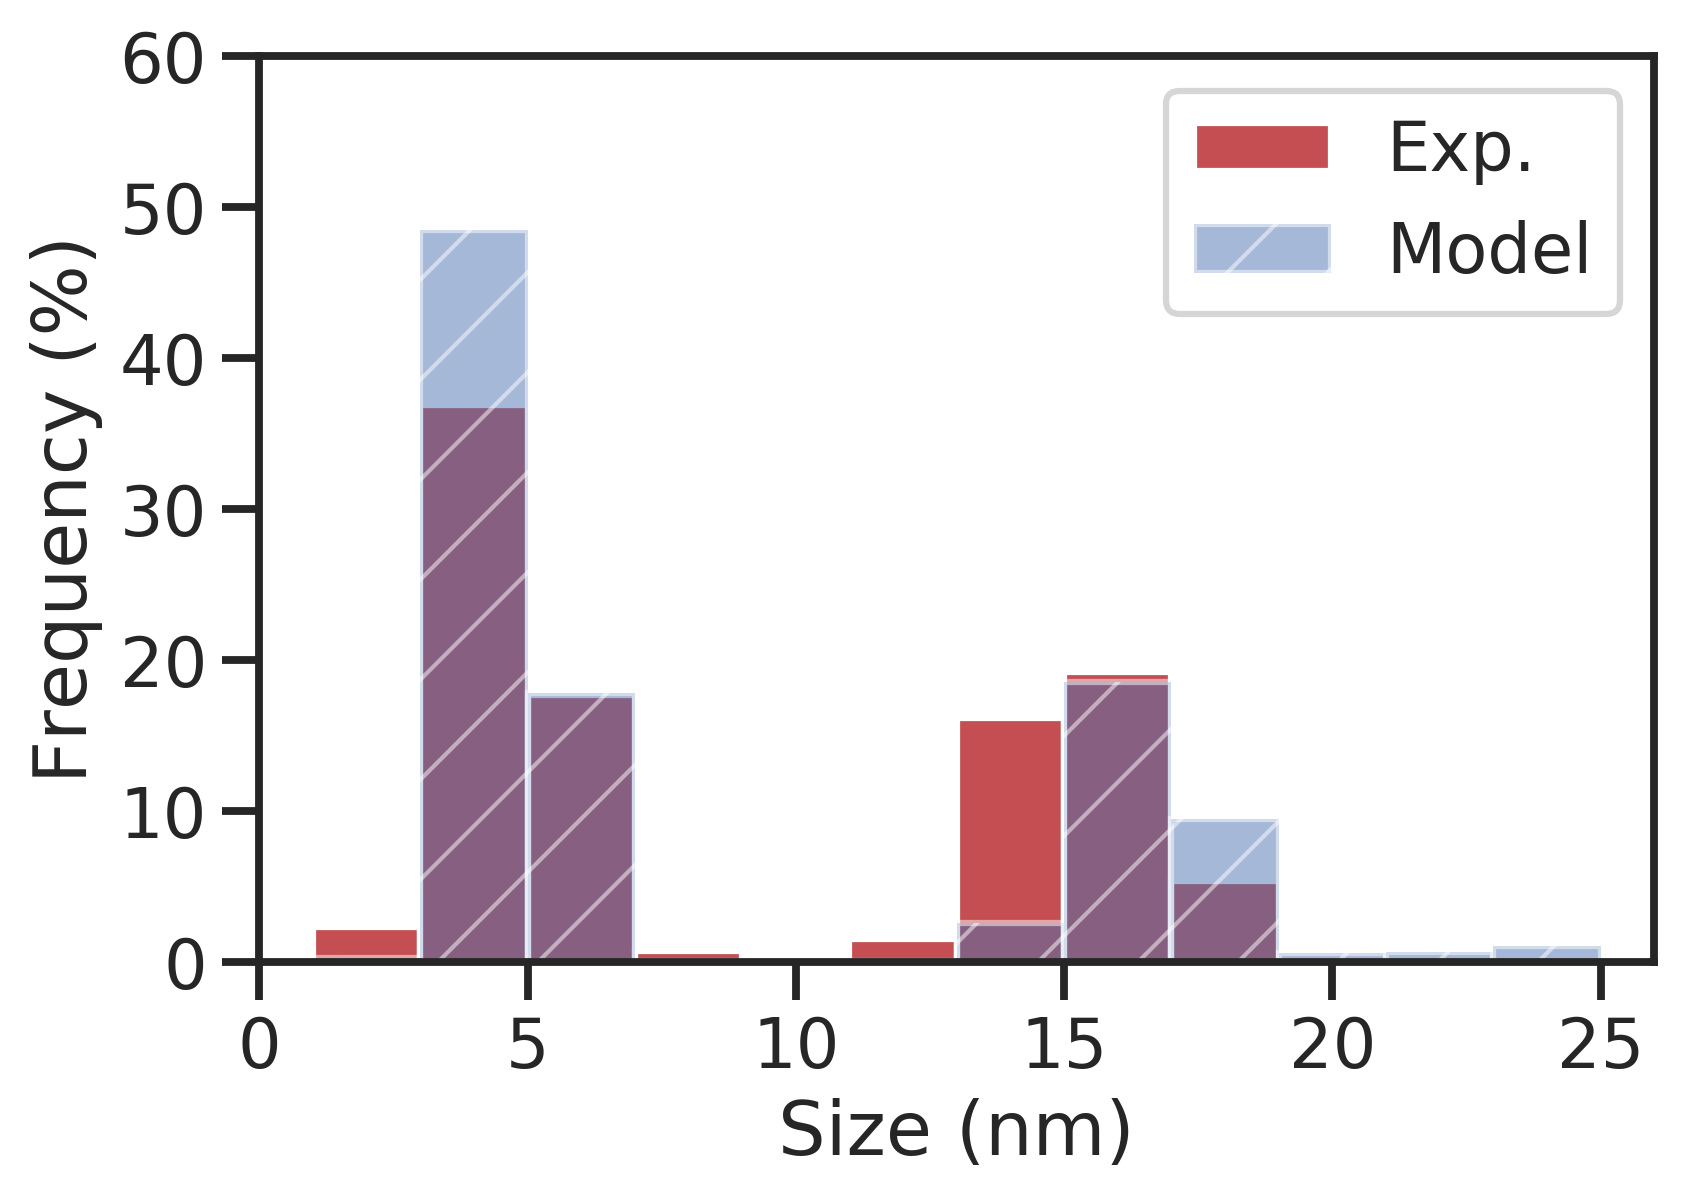

In [65]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,60))

(0, 60)

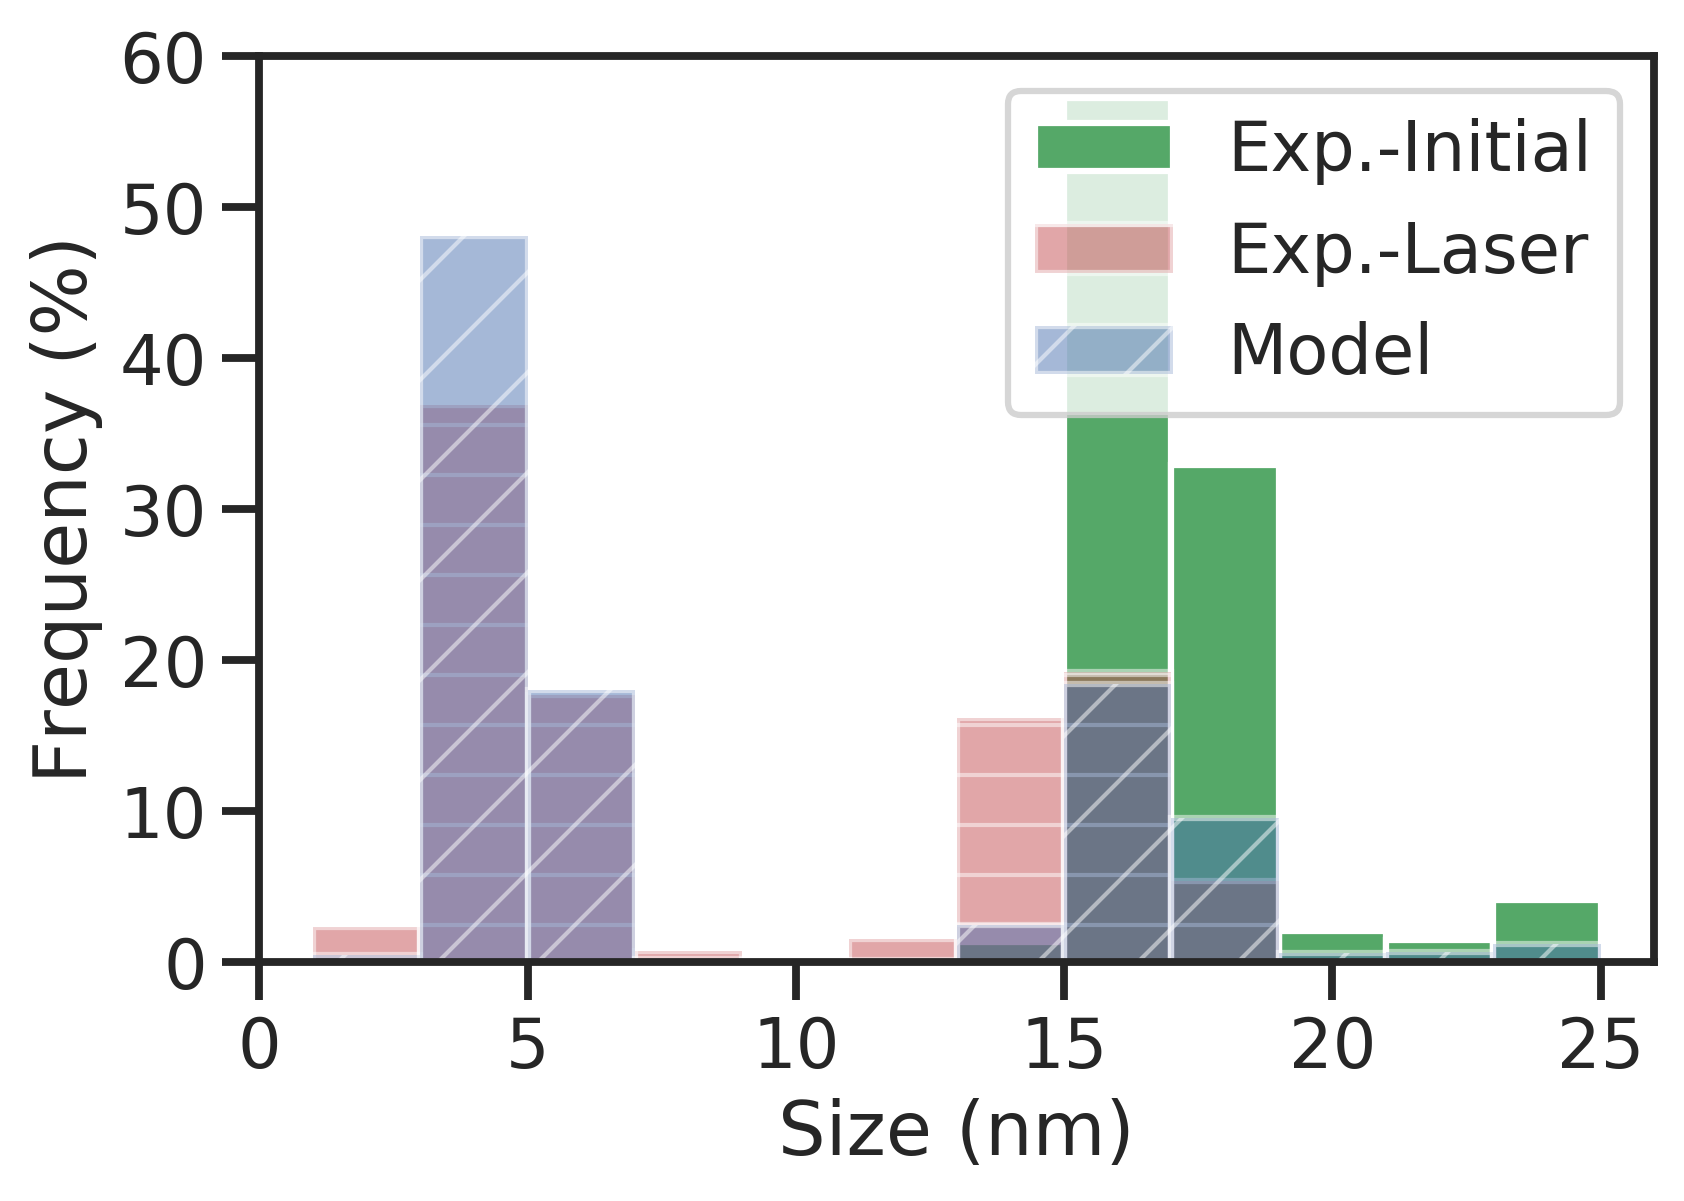

In [63]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,60))

## Surface Layer Ablation - Two Particles - Partial ablation

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms two equal volume particles so that there are three daughter particles: two corresponding to the surface layer and one for the remaining particle core.

In [64]:
shell_width = 0.06 * rads[:int(0.5*len(rads))]
print(shell_width[:5])
rcore = rads[:int(0.5*len(rads))] - shell_width
Dcore = 2 * rcore
rsl = ( rads[:int(0.5*len(rads))]**3 - rcore**3)**(1/3)
rfrag = rsl/(2)**(1/3)
print(rsl[:5])
Dfrag = 2 * rfrag
# pick out half the surface layer fragments -- these will merge onto unfragmented particles
Vfrag = (4/3)*np.pi* rfrag[:int(0.5*len(rfrag))]**3
print(Dsl[:5])
Vo = (4/3)*np.pi * rads[int(0.5*len(rads)):]
Vp = Vo[:len(Vfrag)] + Vfrag
rp = ( (3/(4*np.pi)) * Vp )**(1/3)
Dp = 2*rp

[0.49403365 0.46746678 0.4903513  0.47912302 0.47694203]
[4.55606683 4.31106238 4.52210753 4.41855834 4.39844488]
[9.11213367 8.62212477 9.04421507 8.83711667 8.79688976]


In [65]:
frag_sizes = np.concatenate((Dfrag[int(0.5*len(Dfrag)):], Dcore, Dp))

In [66]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[   2   23  769 3892  332]
[2.000e-02 2.300e-01 7.690e+00 3.892e+01 3.320e+00]


(0, 60)

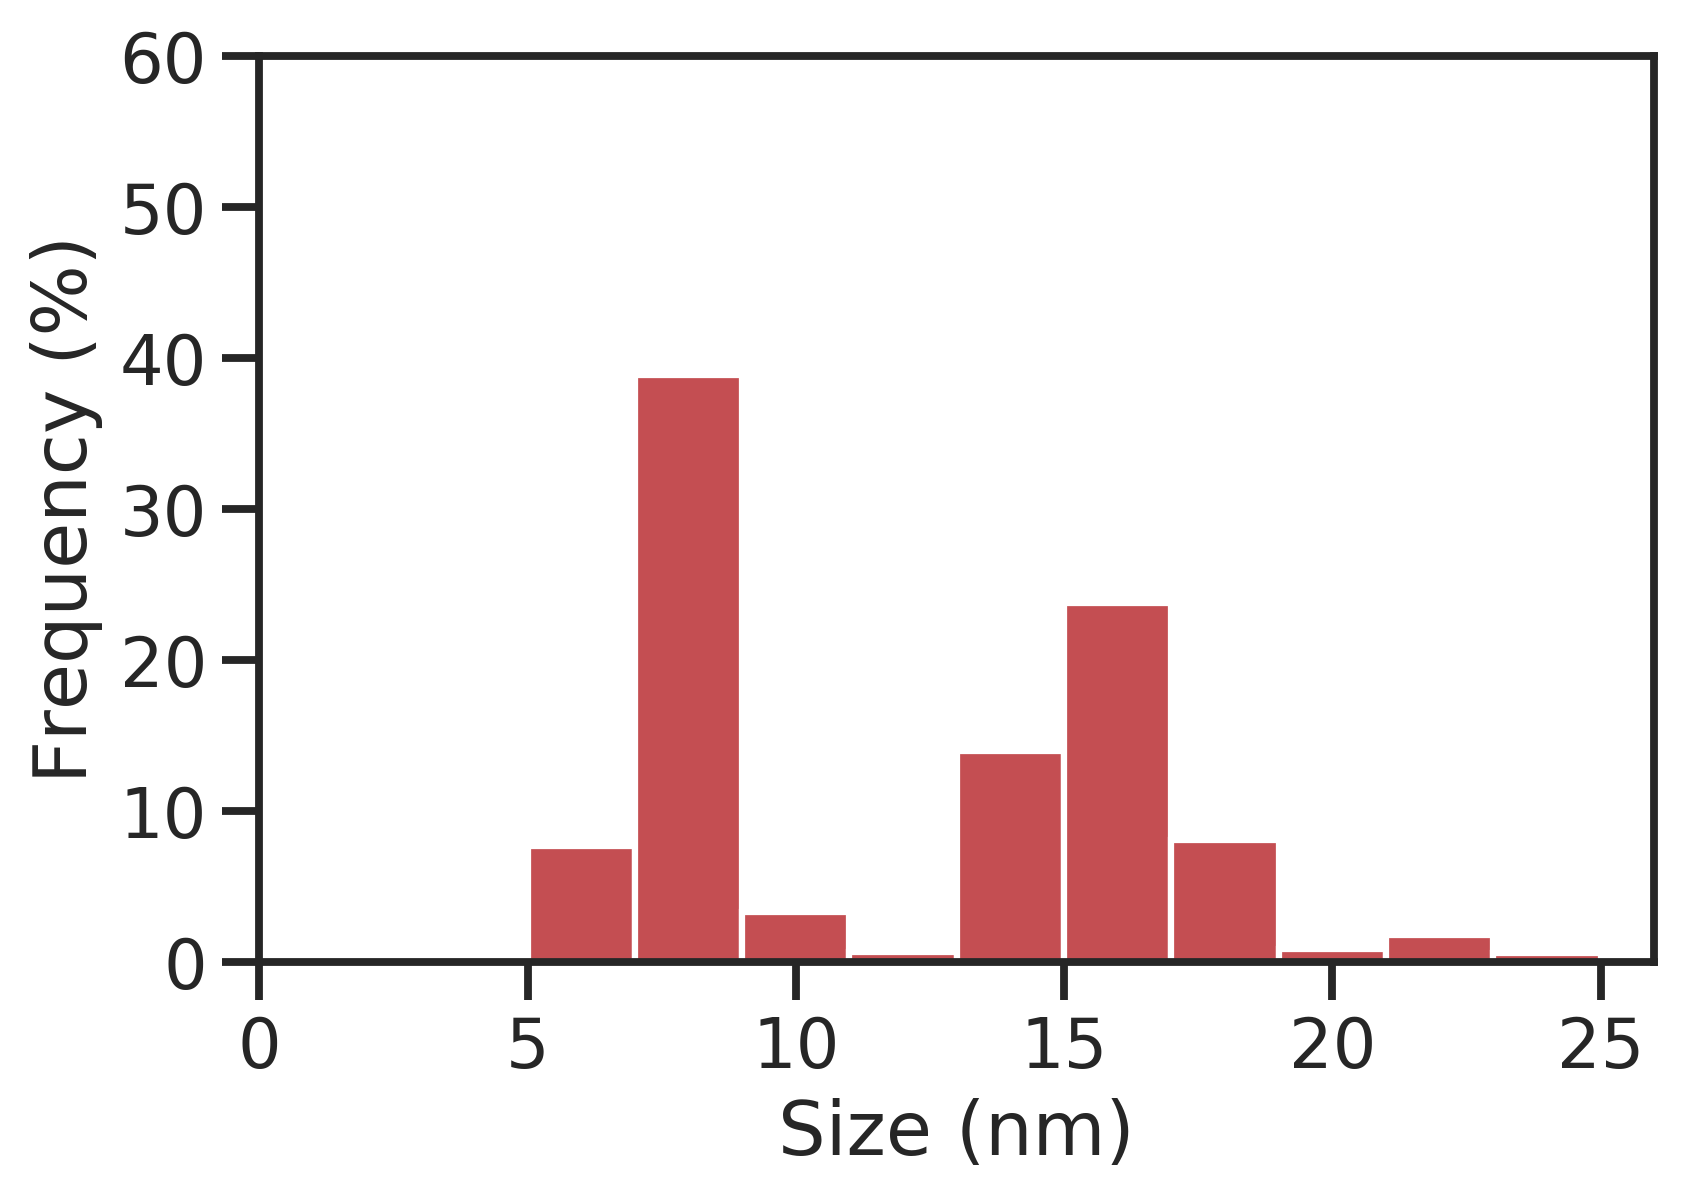

In [67]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

(0, 60)

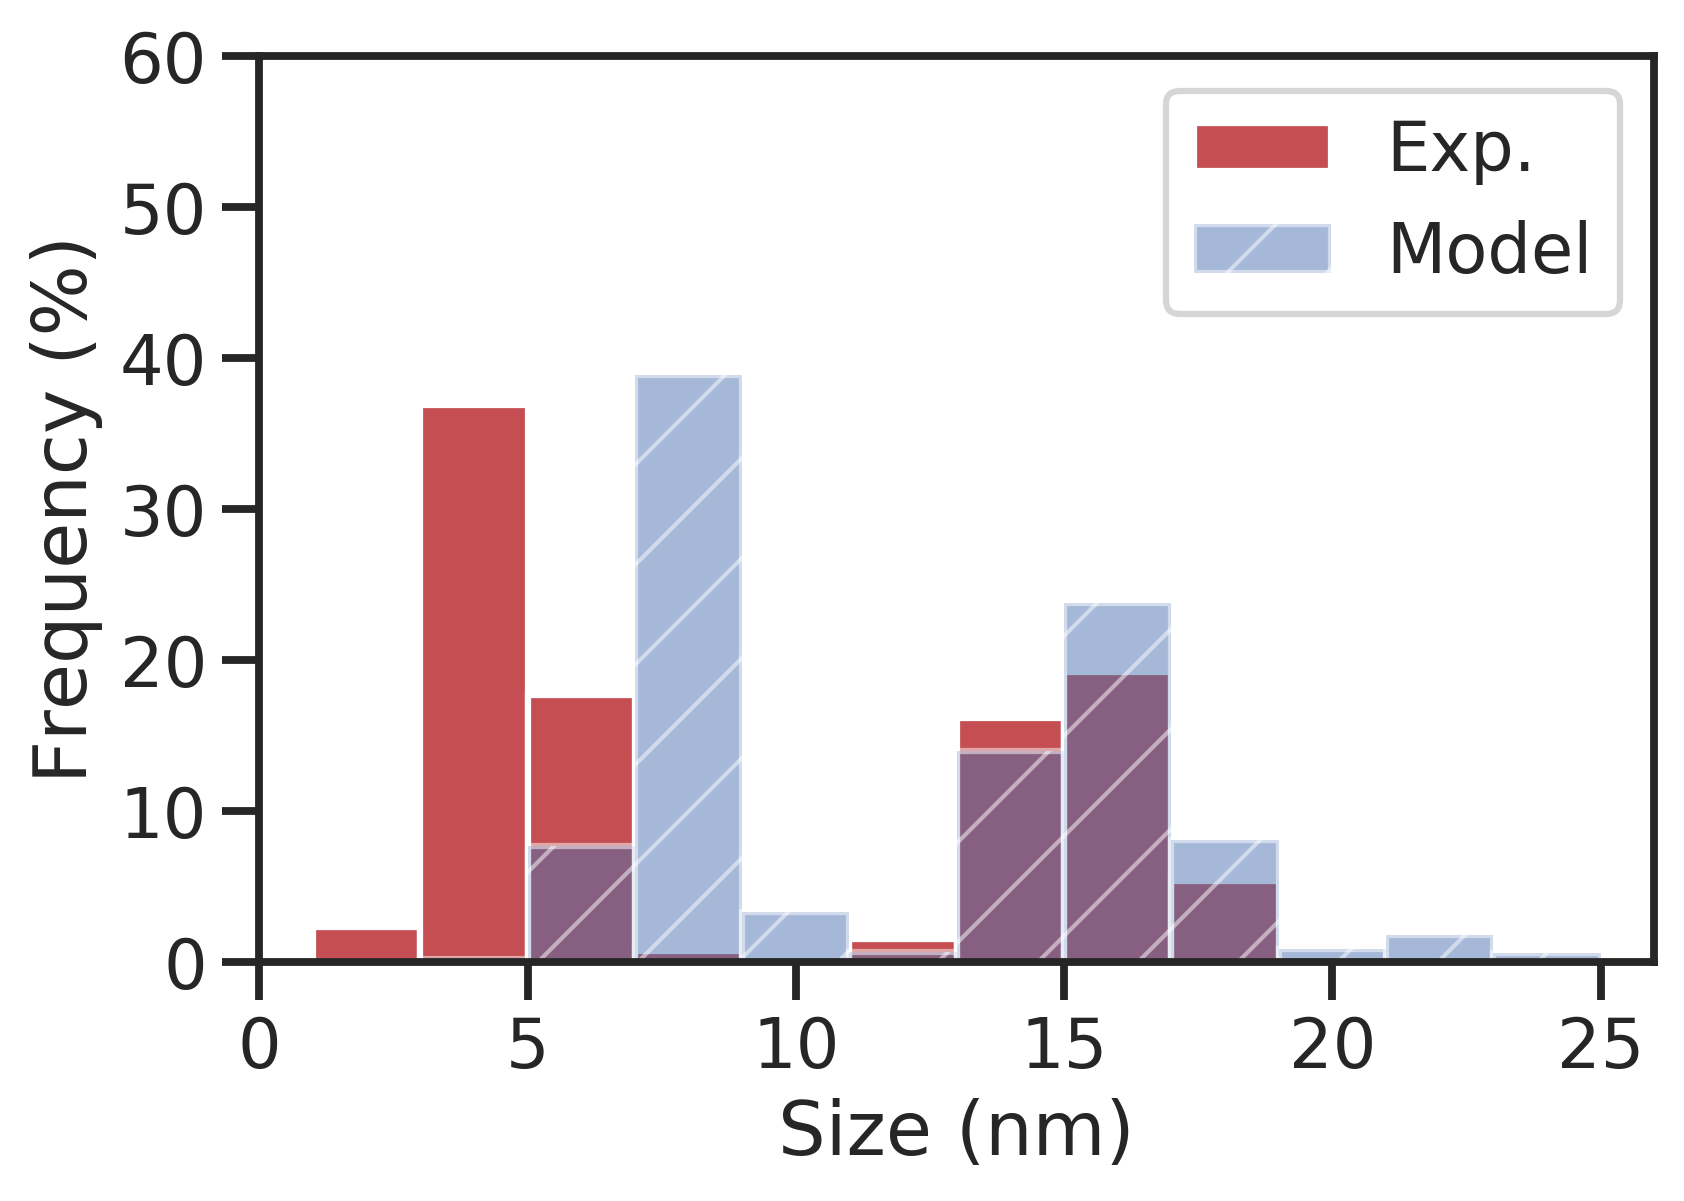

In [68]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,60))

(0, 60)

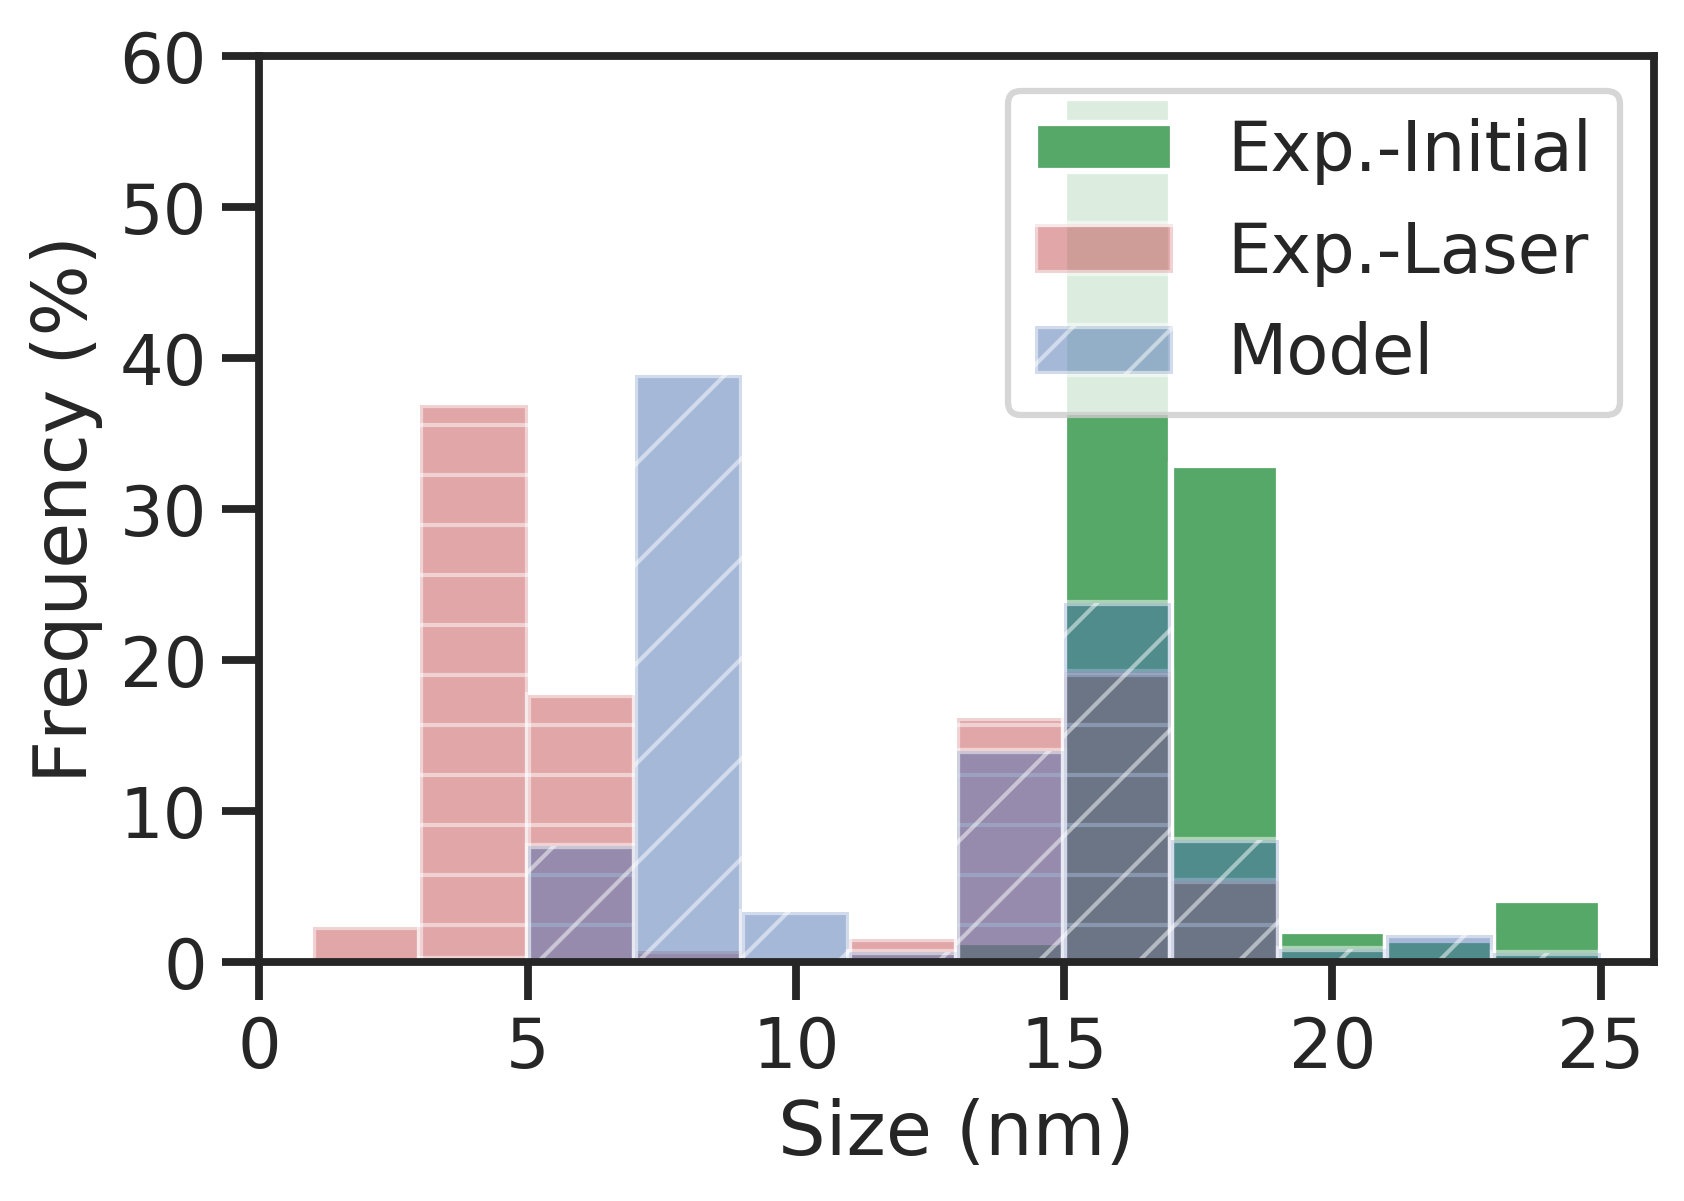

In [69]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,60))

## Particle Split - Two Particles

Here, we apply a model for 1/3 of particles splitting into two particles of equal volume particles, so that the ratio of fragments to unfragmented particles is 1:1.

In [66]:
Vo = (4/3)*np.pi*rads**3
Vfrag = Vo[:int(0.33*len(Vo))]/2
rfrag = ((3/4)*Vfrag/np.pi)**(1/3) 
Dfrag = rfrag*2

In [67]:
frag_sizes = np.concatenate((Dfrag, Dfrag, sample_sizes[int(0.33*len(Vo)):]))

In [68]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[ 0  8 20 21 60]
[0.         0.06015038 0.15037594 0.15789474 0.45112782]


(0, 60)

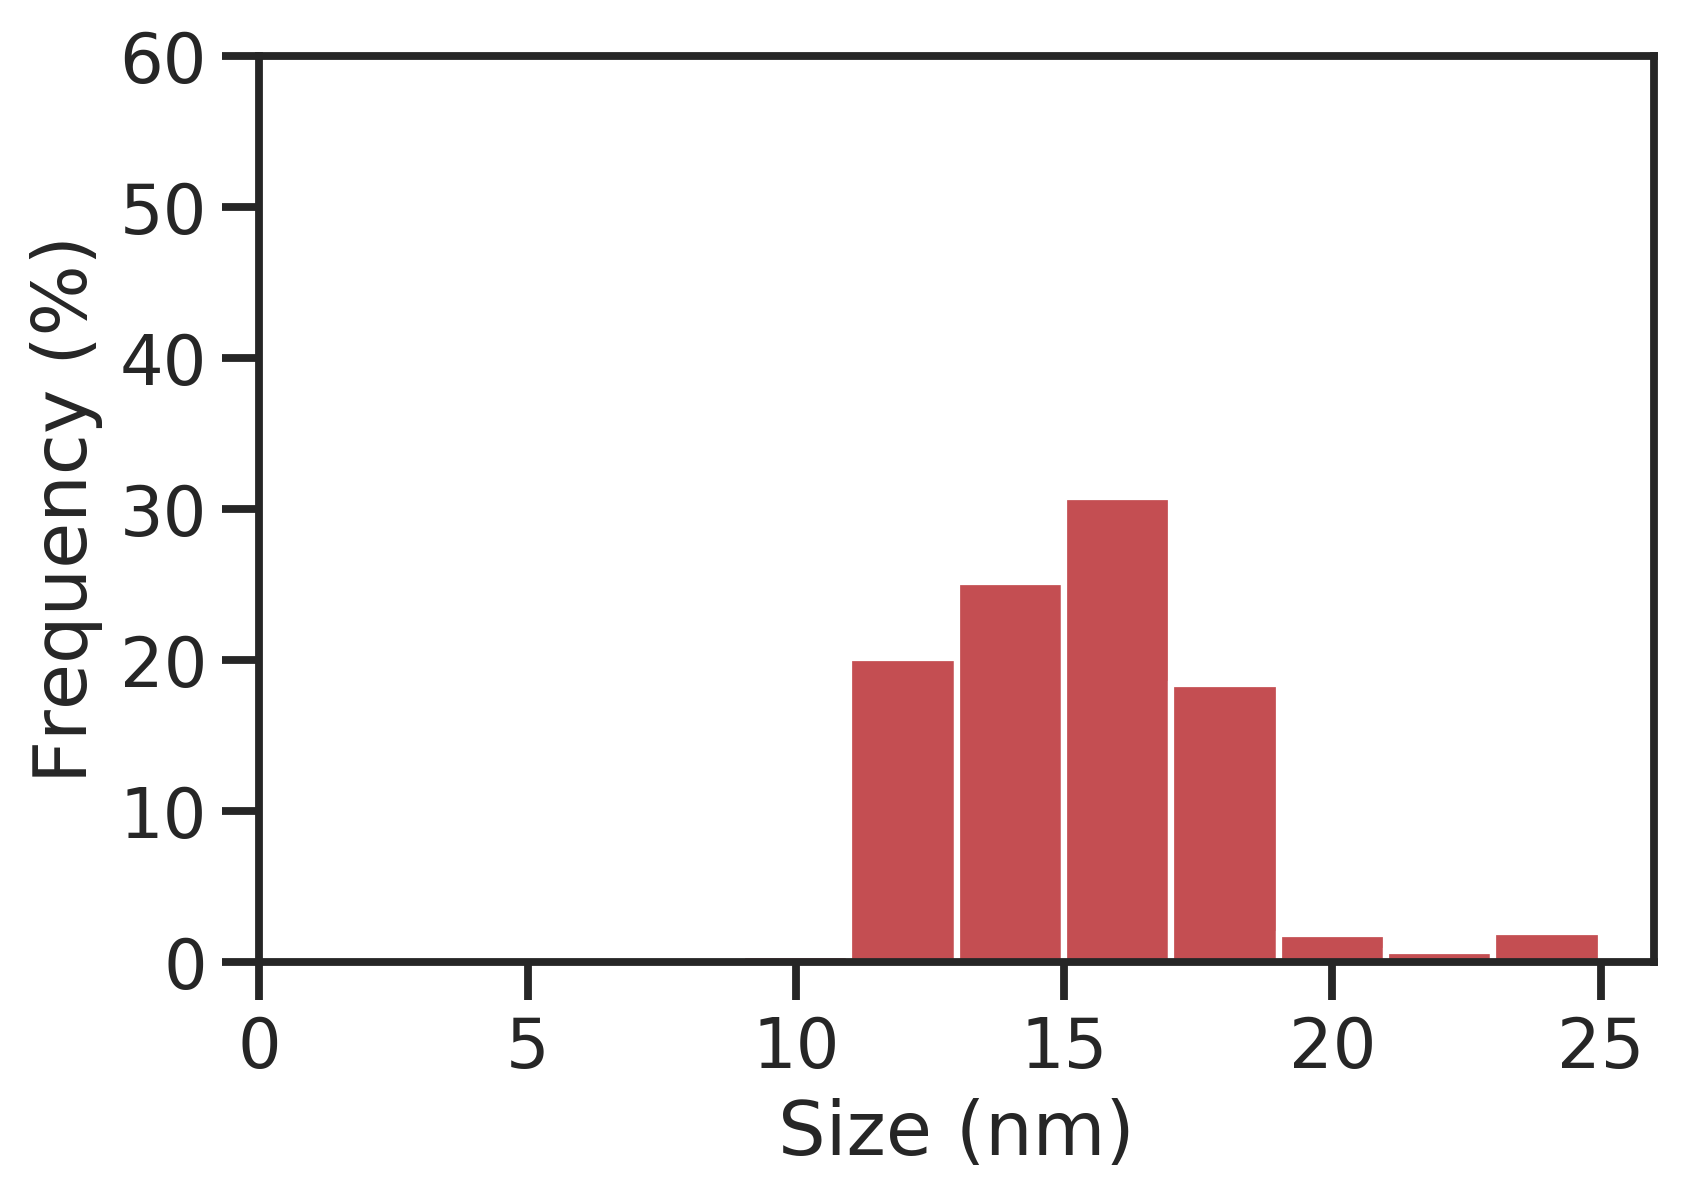

In [69]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

In [70]:
np.savetxt('15nm_explore_frequency_ps_2part.txt', frag_freq)

(0, 60)

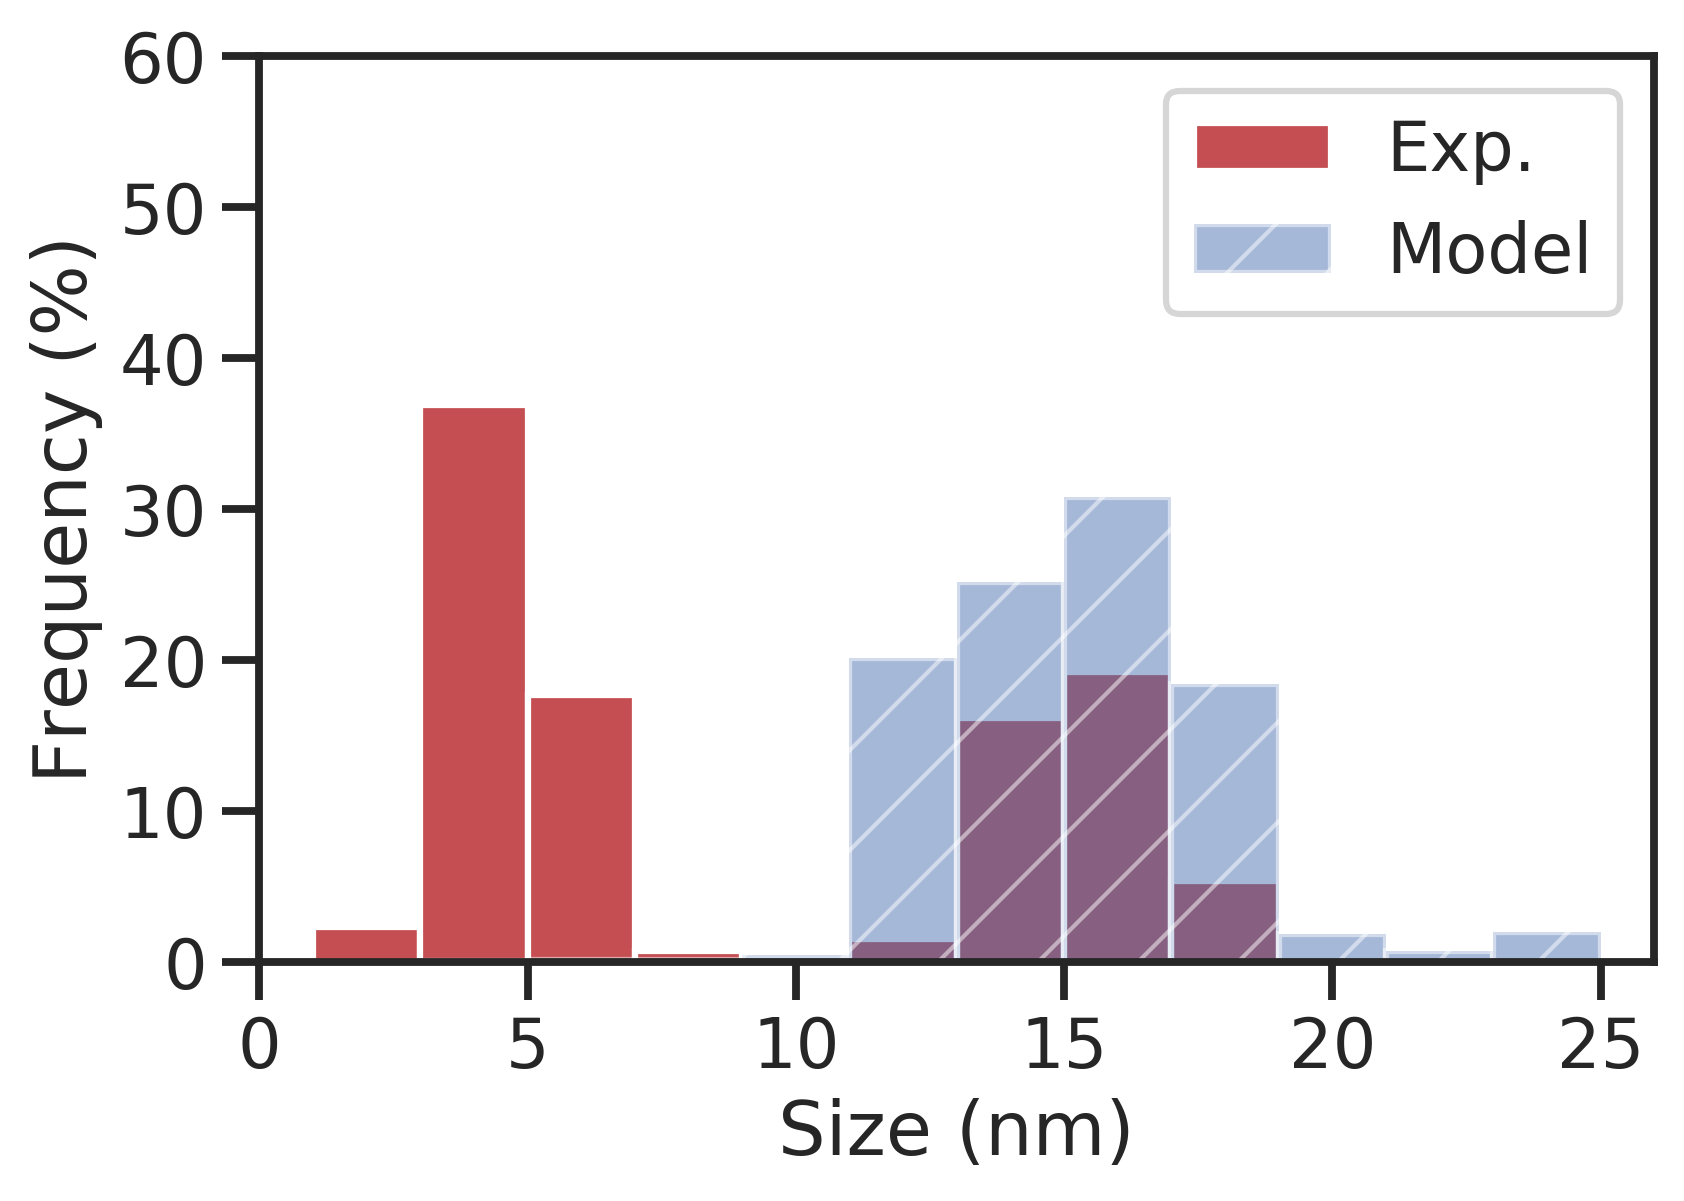

In [71]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,60))

(0, 60)

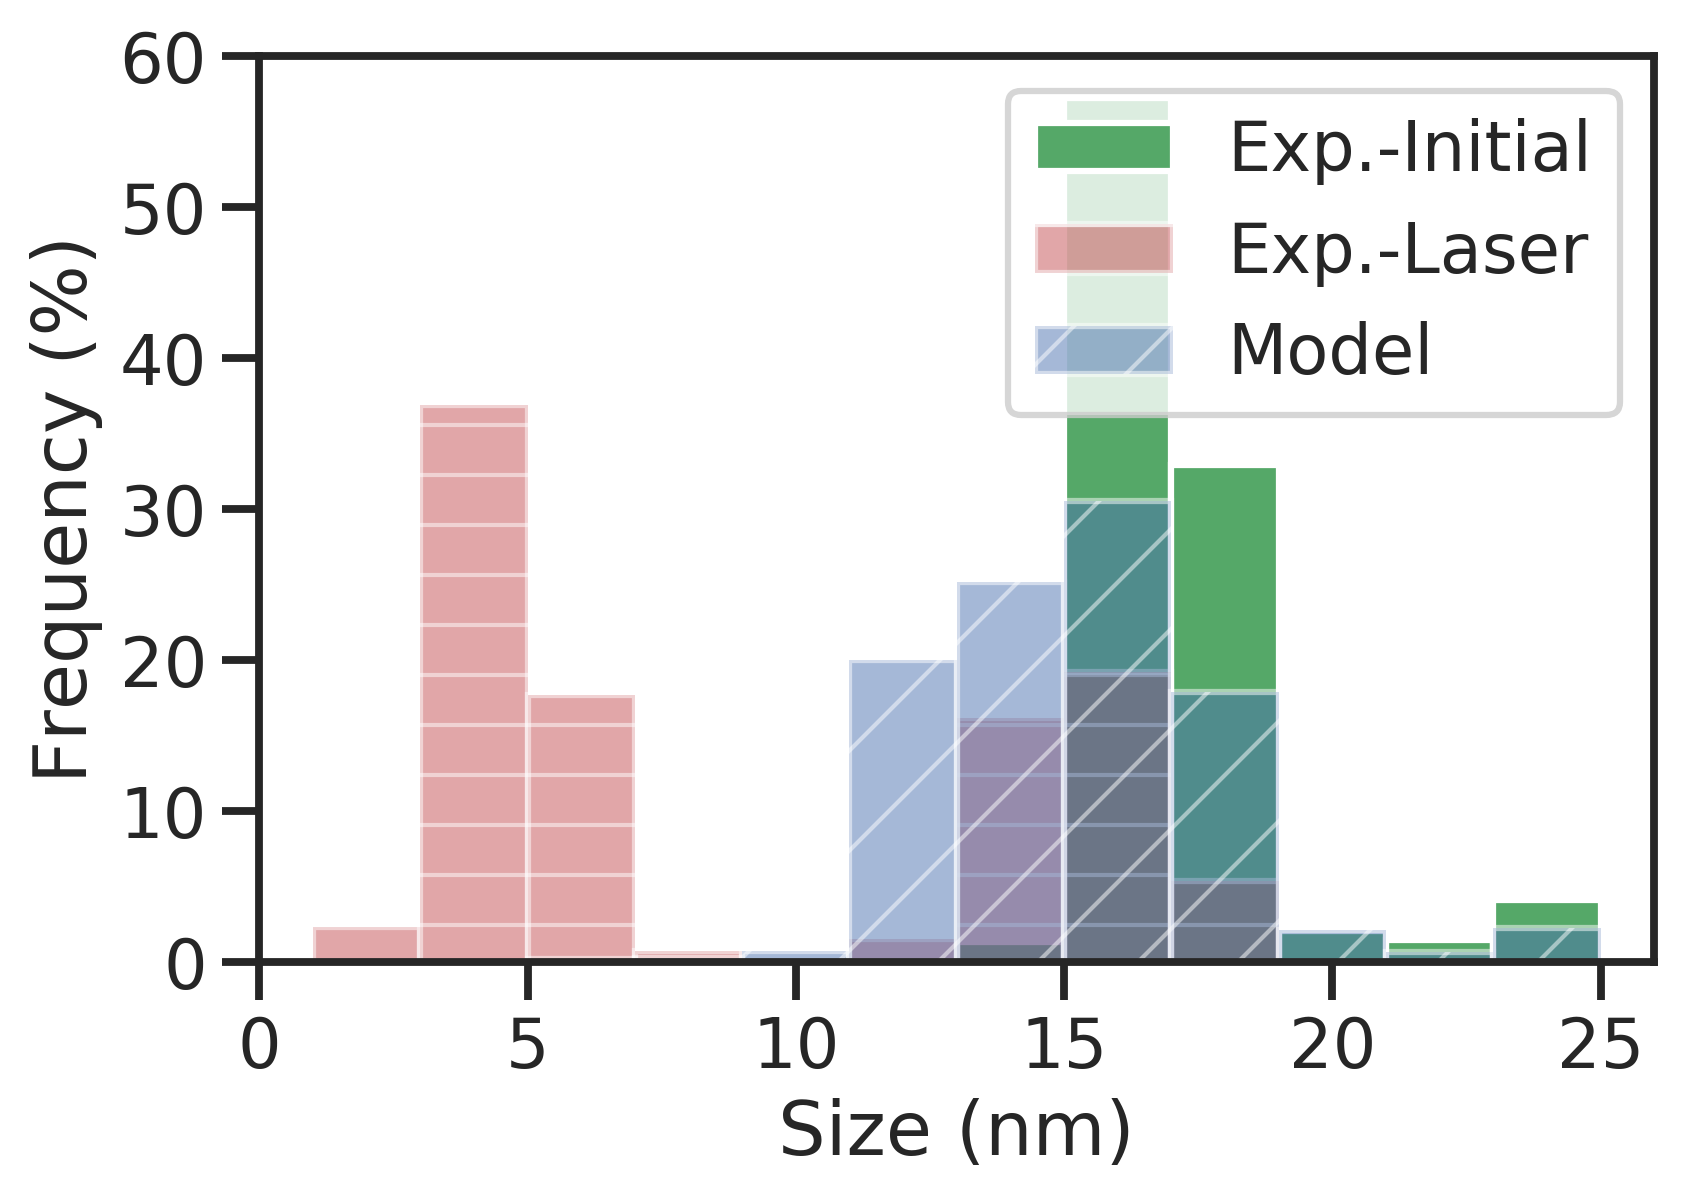

In [75]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,60))

## Particle Split - Four Particles

Here, we apply a model for 1/5 of particles splitting into four particles of equal volume particles, so that the ratio of fragments to unfragmented particles is 1:1.

In [76]:
Vo = (4/3)*np.pi*rads**3
Vfrag = Vo[:int(0.2*len(Vo))]/4
rfrag = ((3/4)*Vfrag/np.pi)**(1/3) 
Dfrag = rfrag*2

In [77]:
frag_sizes = np.concatenate((Dfrag, Dfrag, Dfrag, Dfrag, sample_sizes[int(0.2*len(Vo)):]))

In [78]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[   0   24   50  107 5210]
[ 0.       0.15     0.3125   0.66875 32.5625 ]


(0, 60)

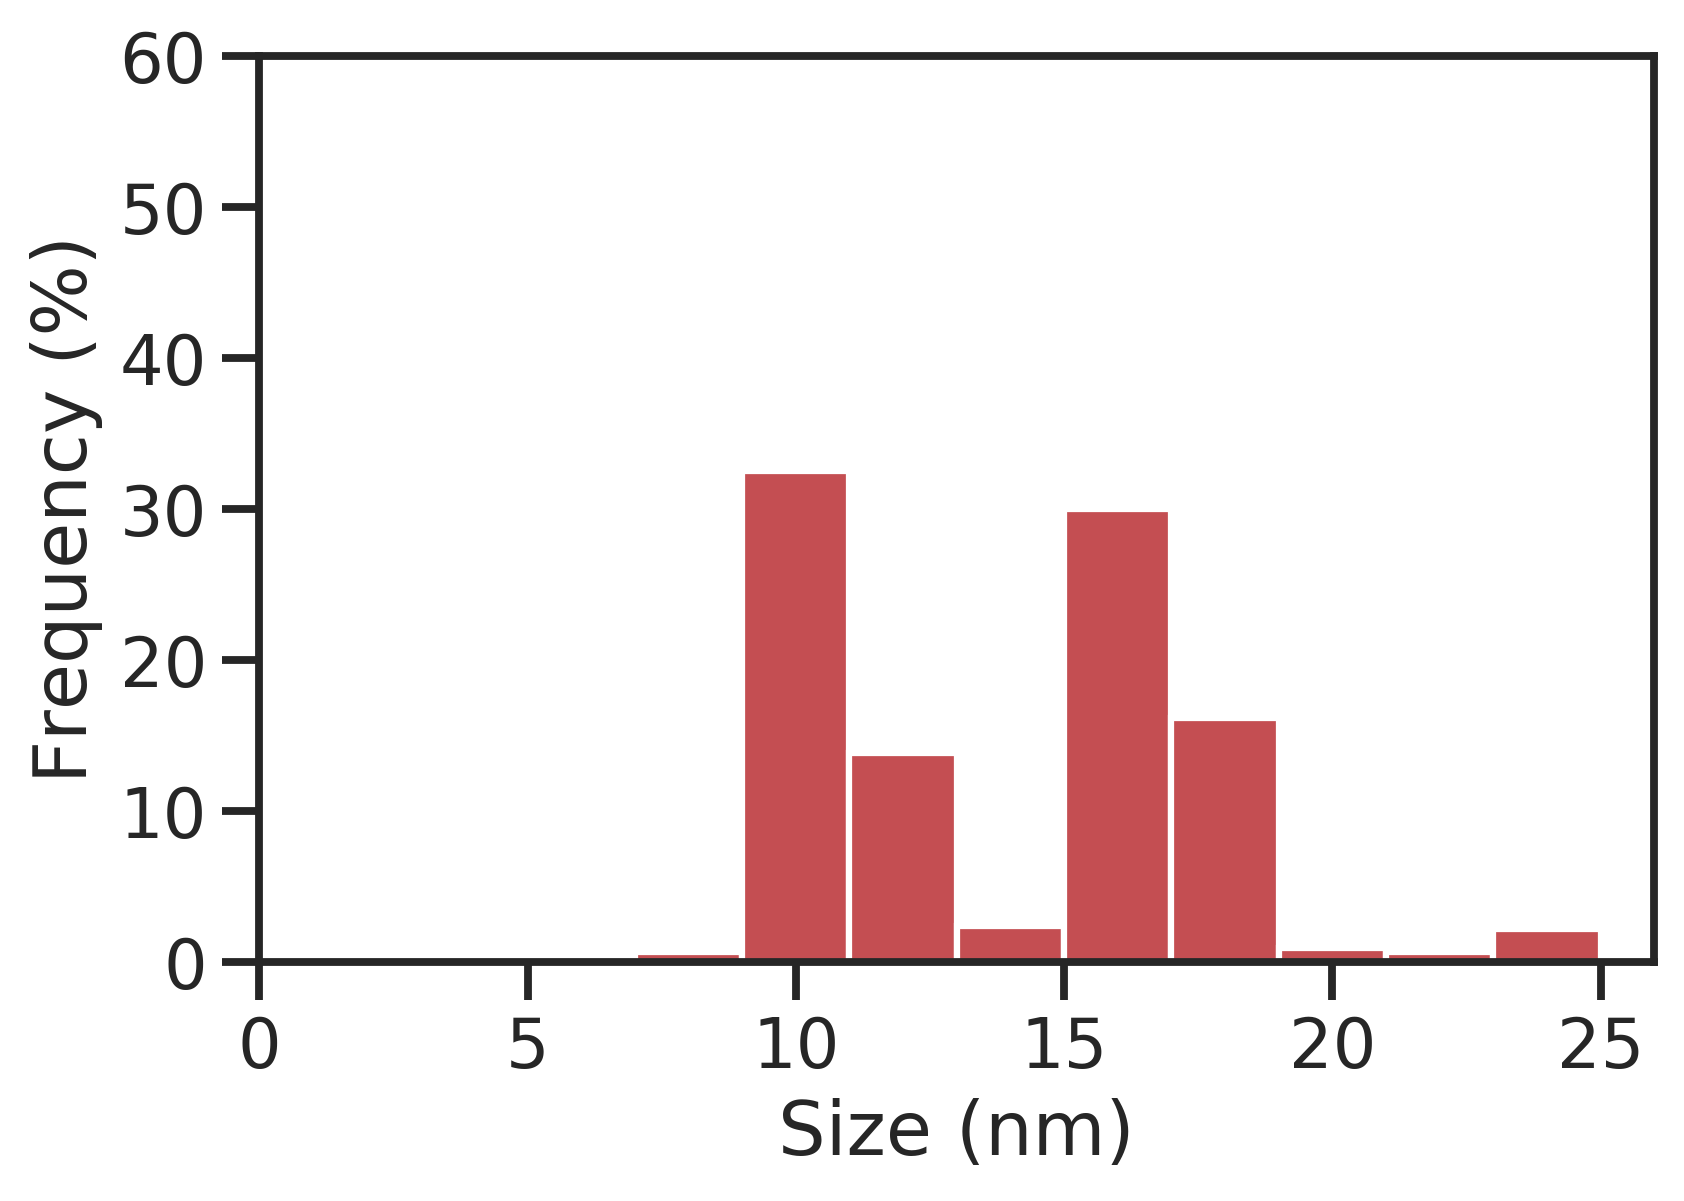

In [79]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

(0, 60)

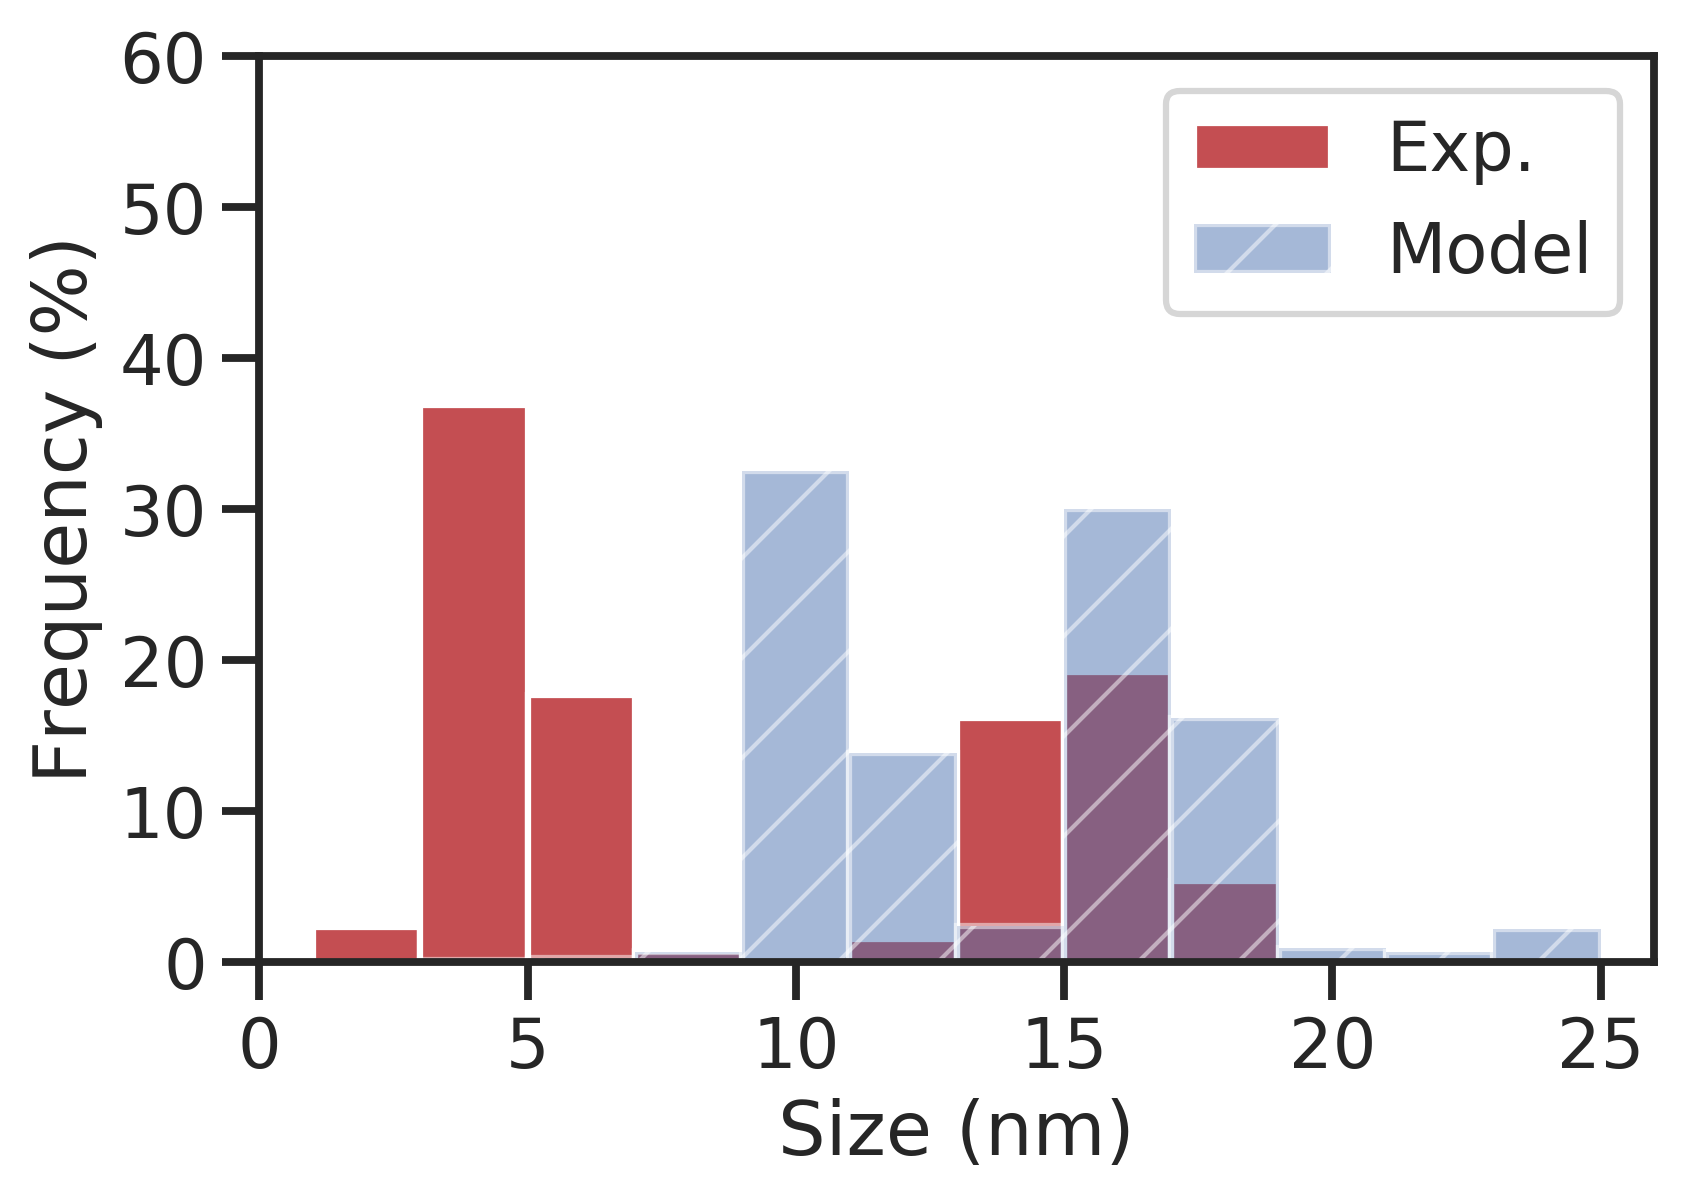

In [80]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,60))

(0, 60)

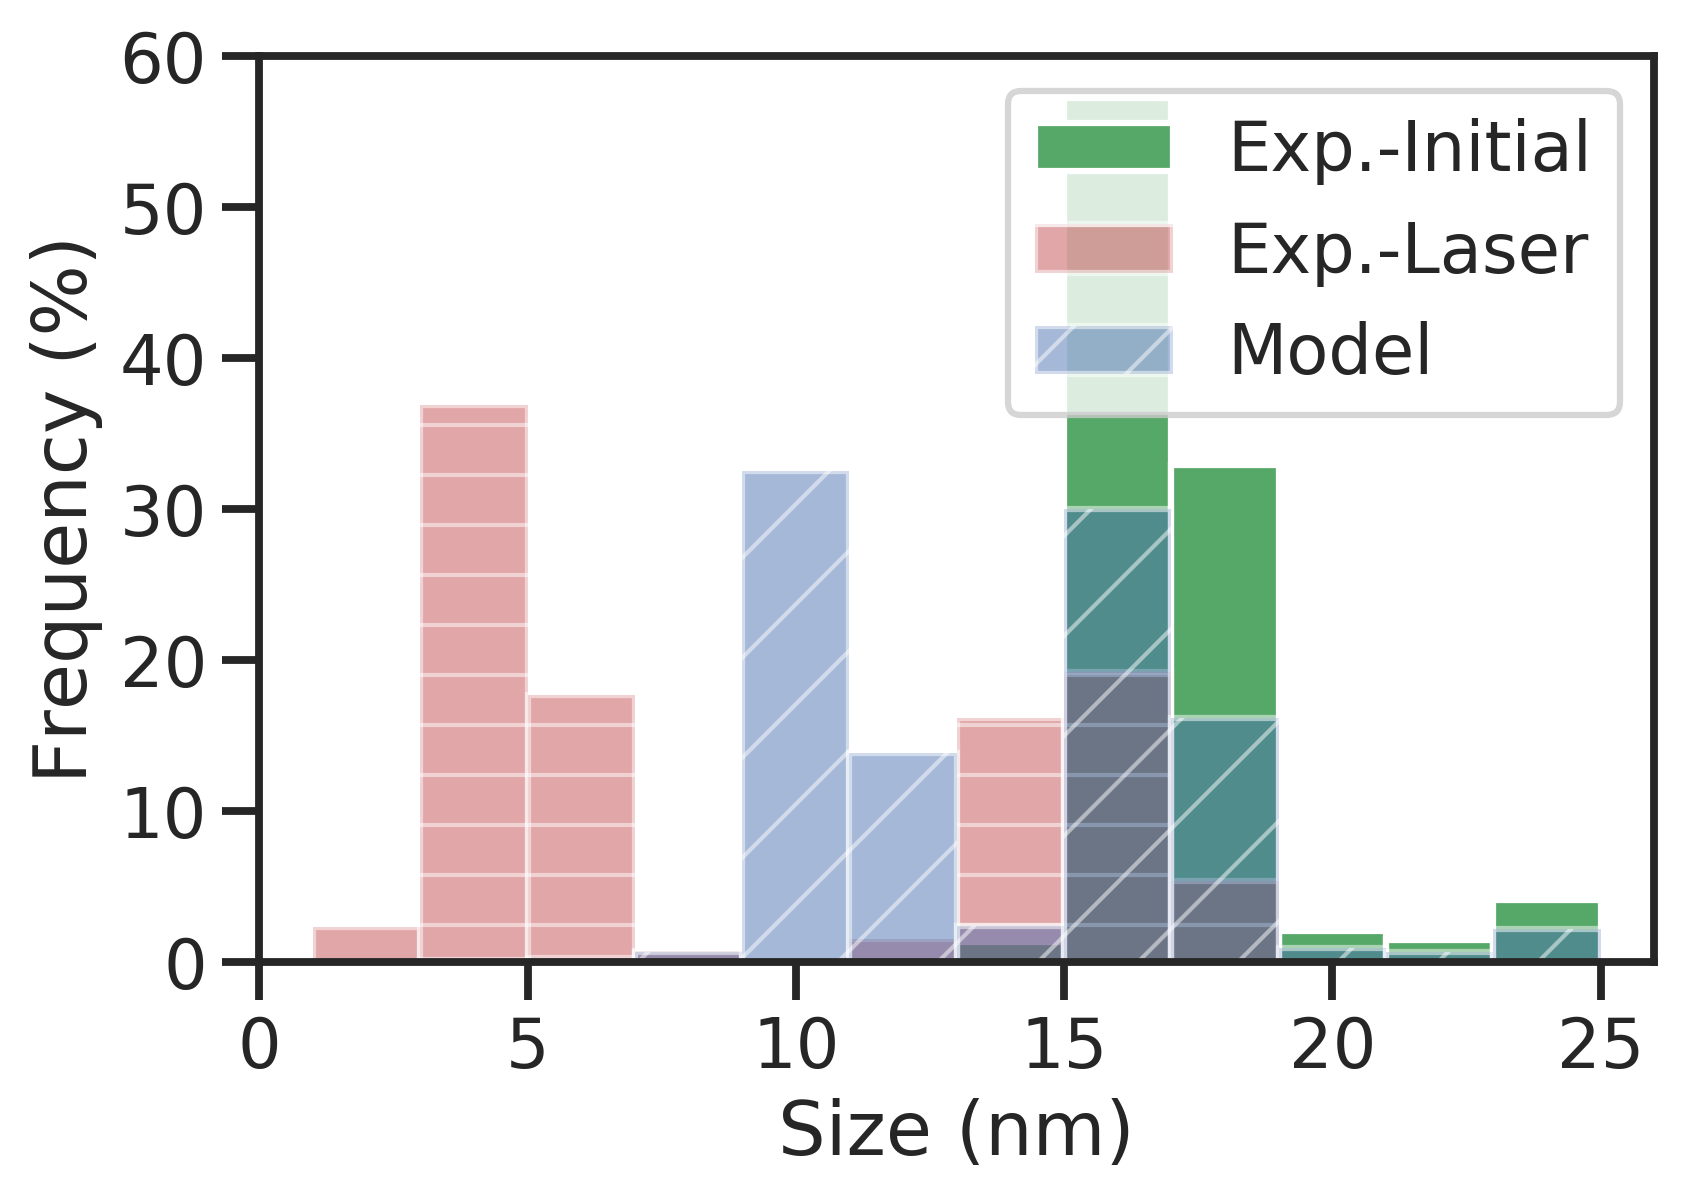

In [81]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,60))

## Particle Split - Eight Particles

Here, we apply a model for 1/5 of particles splitting into four particles of equal volume particles, so that the ratio of fragments to unfragmented particles is 1:1.

In [72]:
Vo = (4/3)*np.pi*rads**3
Vfrag = Vo[:int(0.111*len(Vo))]/8
rfrag = ((3/4)*Vfrag/np.pi)**(1/3) 
Dfrag = rfrag*2

In [73]:
frag_sizes = np.concatenate((Dfrag, Dfrag, Dfrag, Dfrag, Dfrag, Dfrag, Dfrag, Dfrag, sample_sizes[int(0.111*len(Vo)):]))

In [74]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[   8   24   77 6601 1753]
[ 0.0450197   0.13505909  0.43331458 37.14687676  9.86494091]


(0, 60)

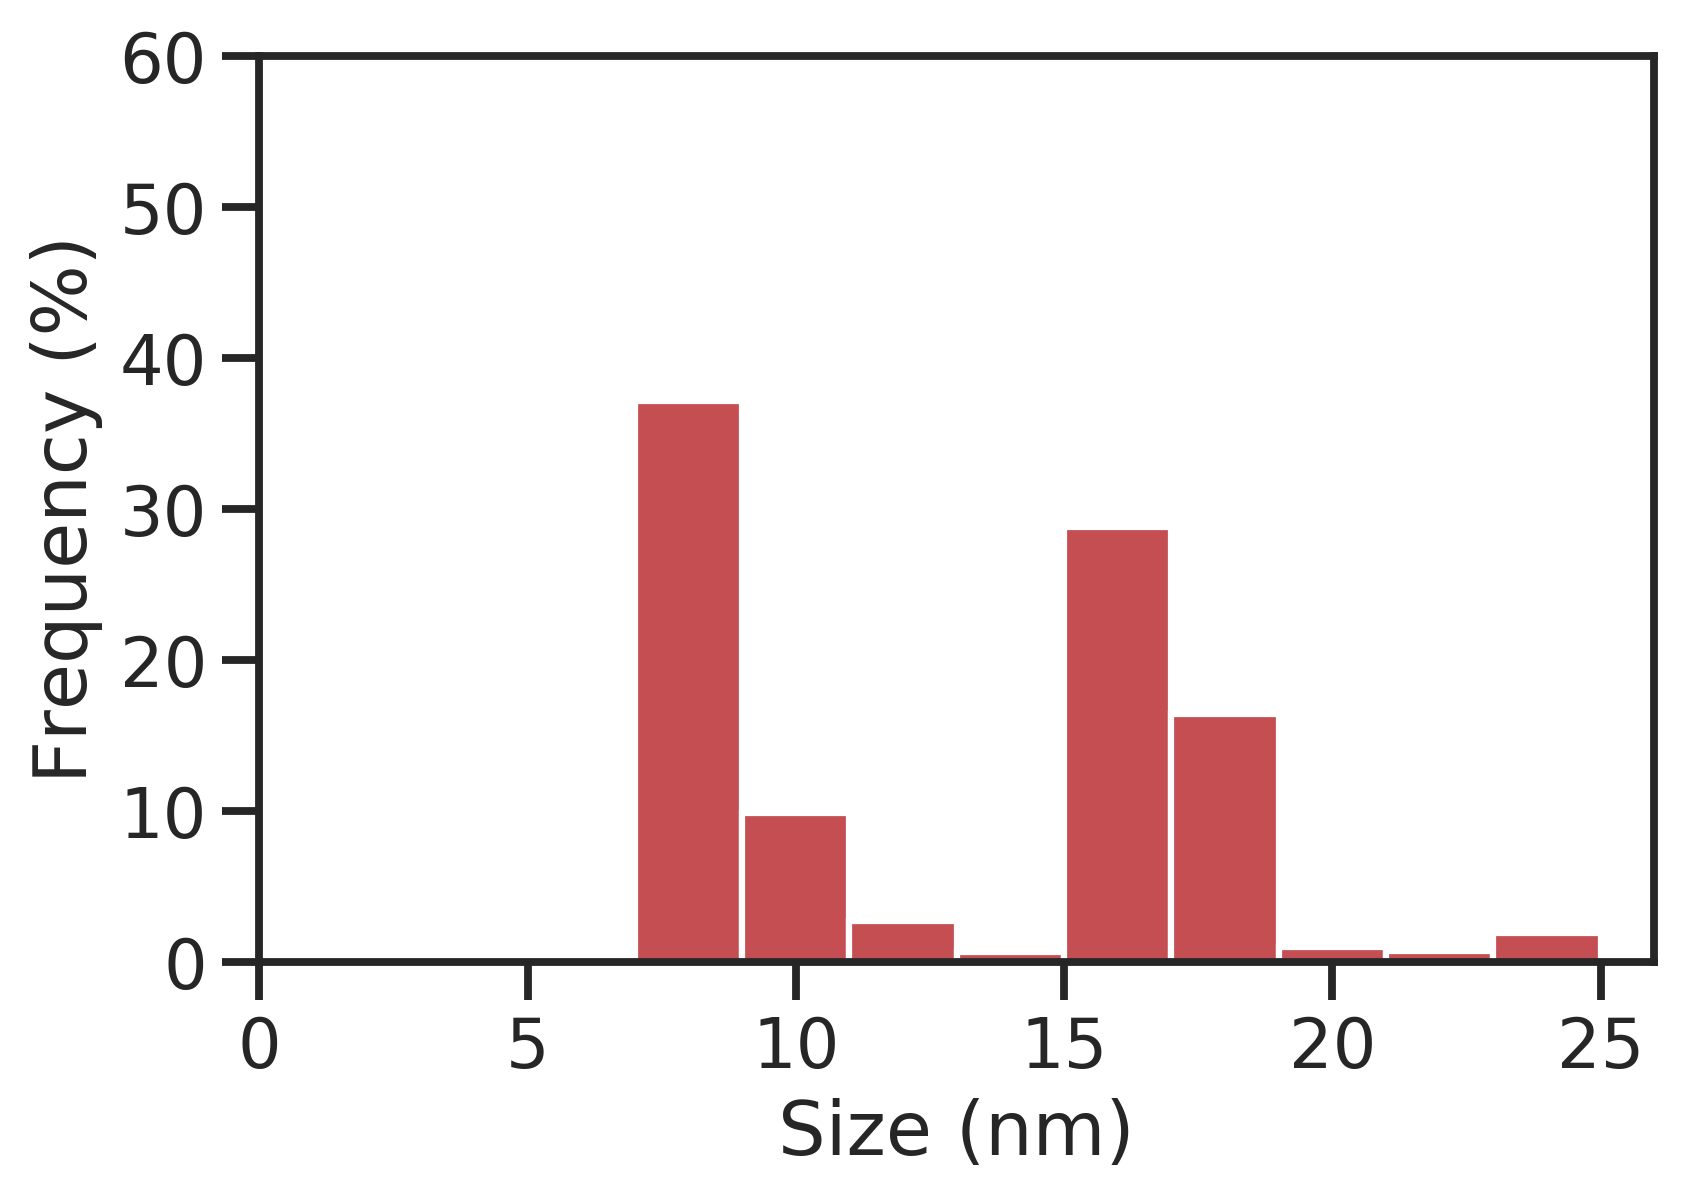

In [75]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,60))

In [76]:
np.savetxt('15nm_explore_frequency_ps_8part.txt', frag_freq)

(0, 60)

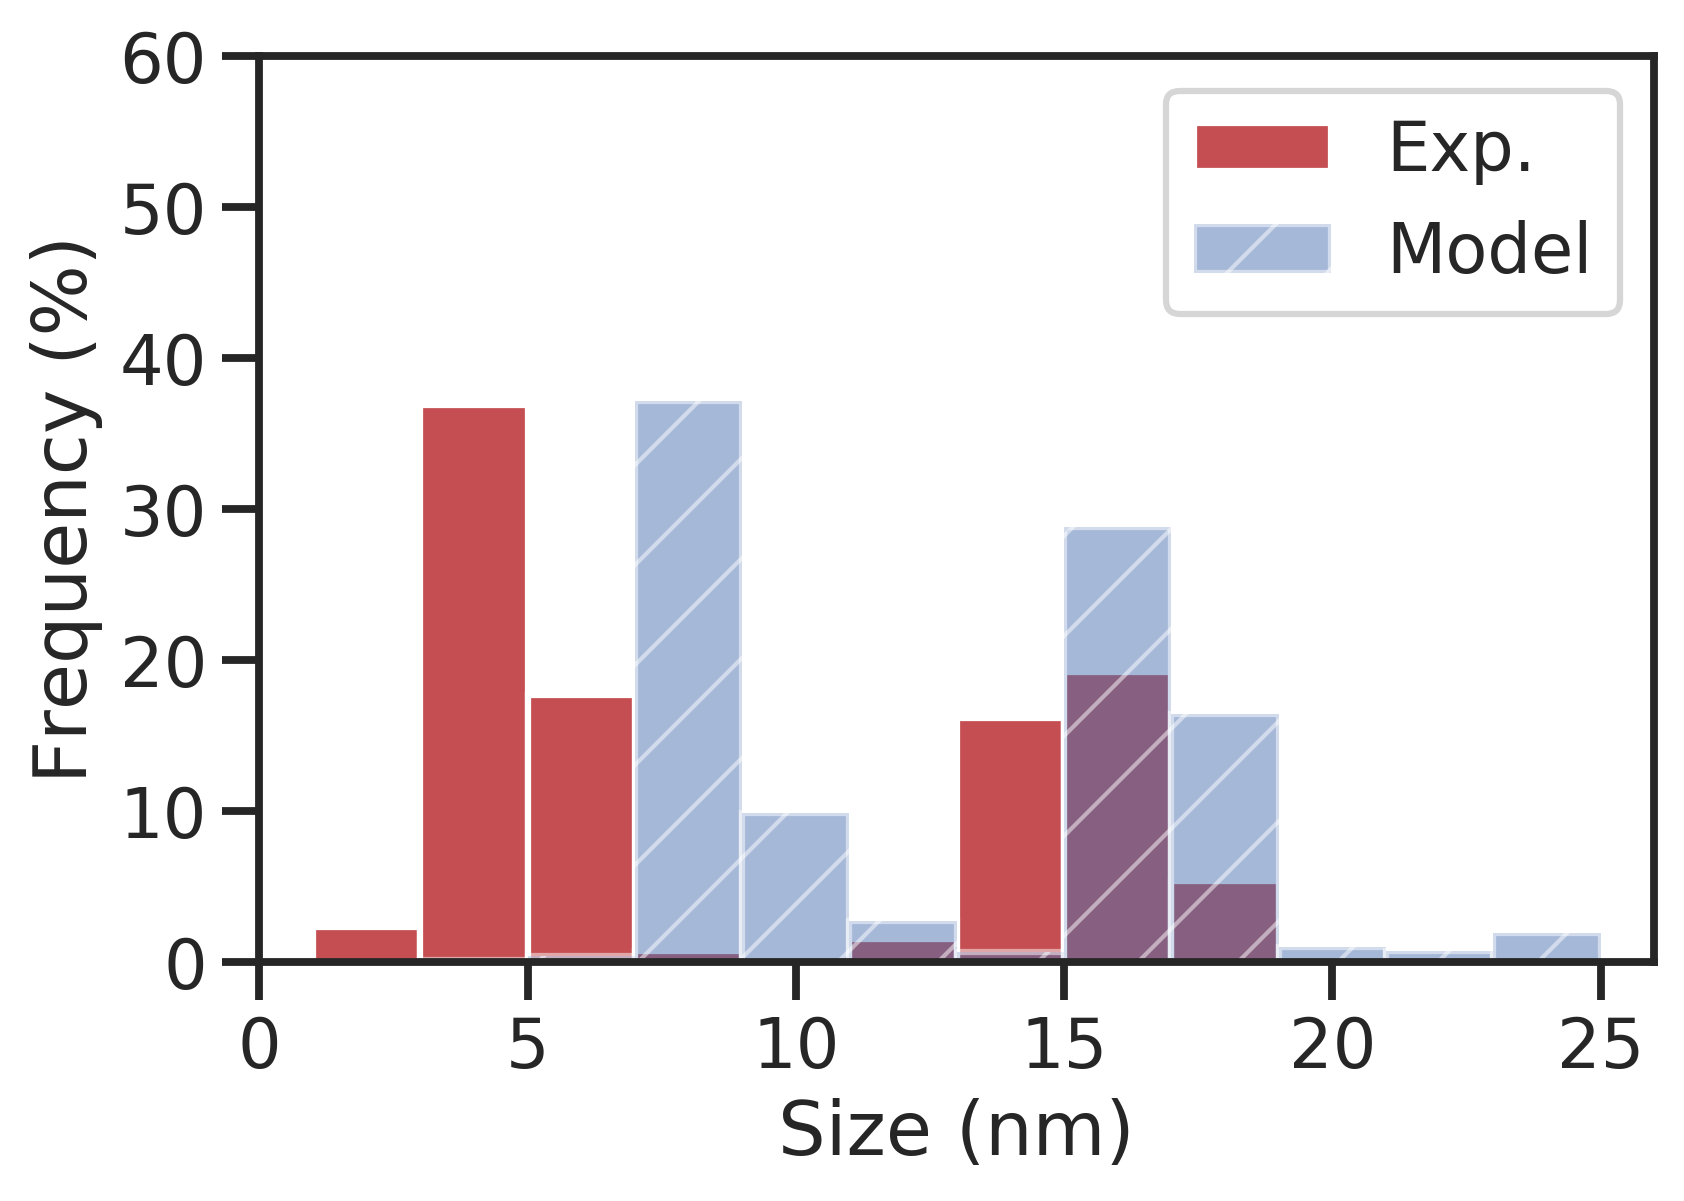

In [77]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,60))

(0, 60)

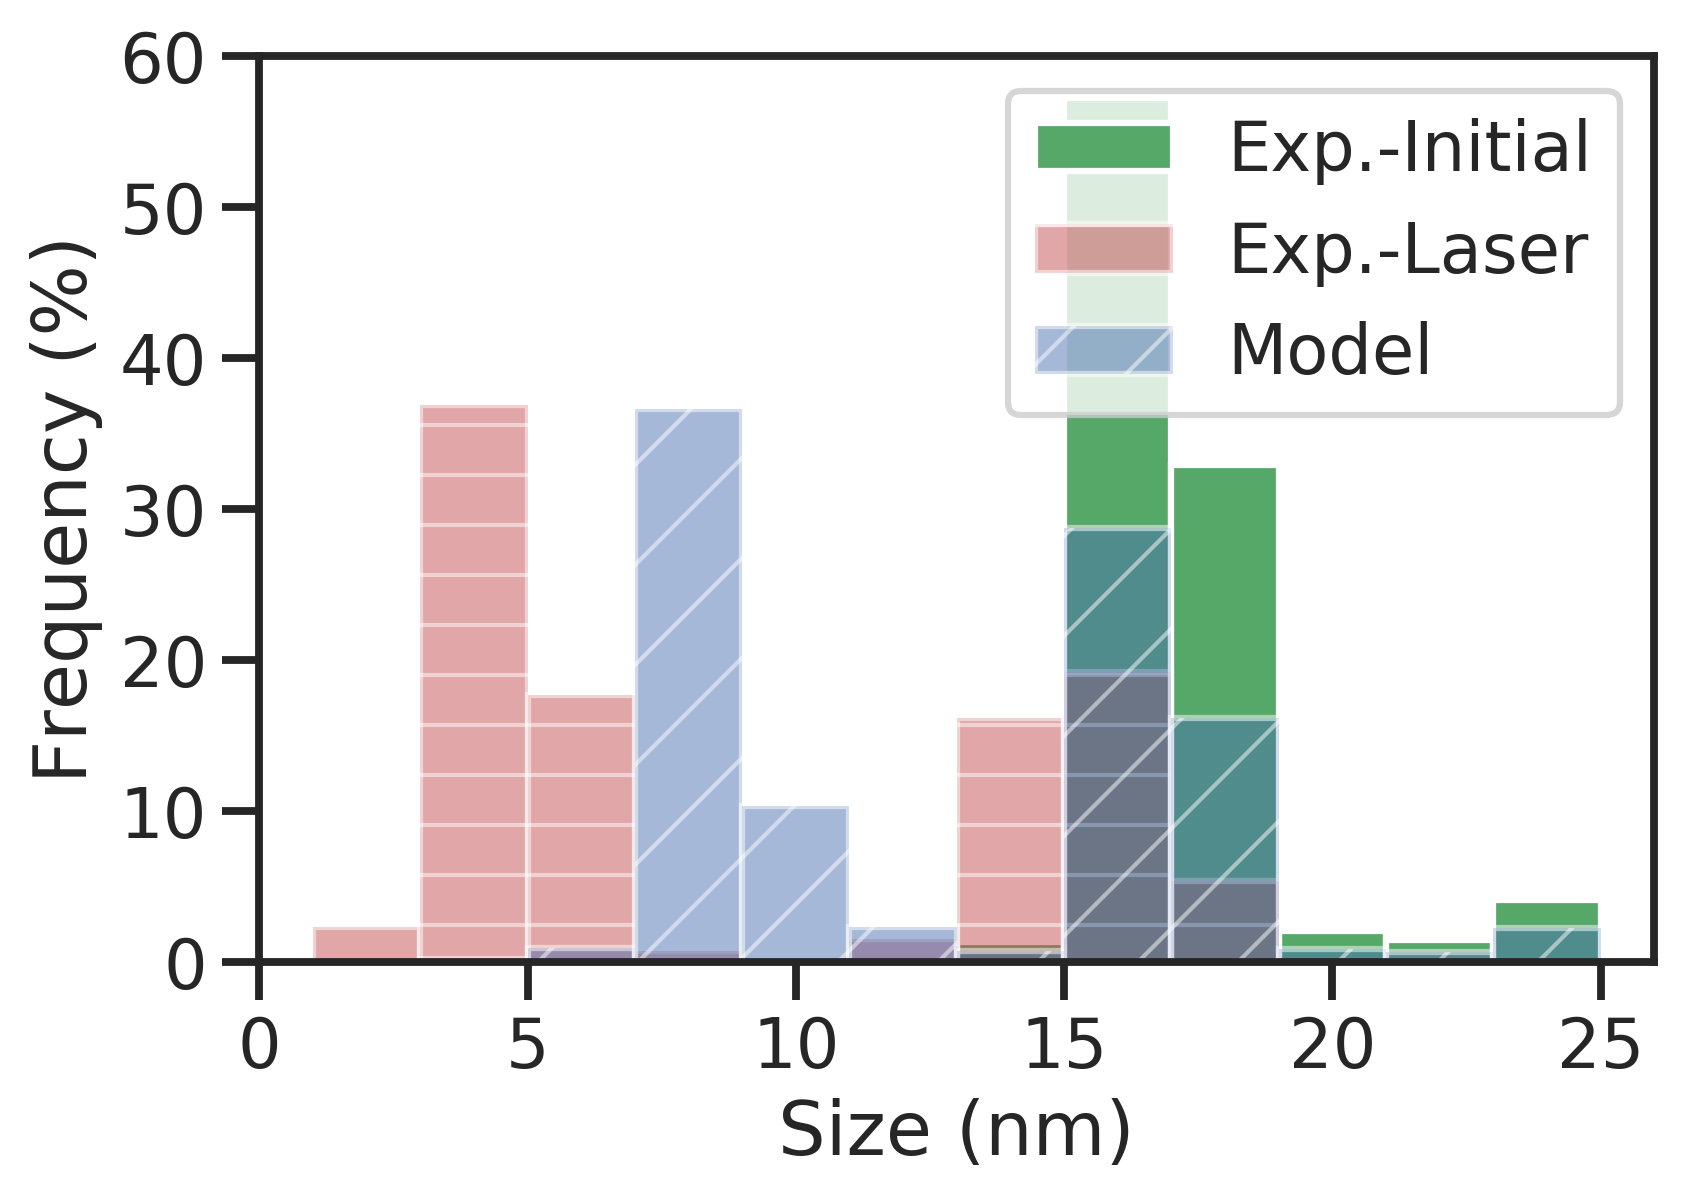

In [87]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,26))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,60))

# 100 nm

In [84]:
# Load the data
dist = pd.read_csv('100nm_distribution.csv')
dist.head()

size  initial     laser
0     5      0.0   0.00000
1    10      0.0  33.96226
2    15      0.0  22.64151
3    20      0.0   7.54717
4    25      0.0   6.60377

In [85]:
# Get the histogram bin centers
centers = dist['size'].to_numpy()
centers

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130])

In [86]:
# Histogram bin width
bw = centers[1] - centers[0]
bw

5

In [87]:
# Create the corresponding edges for the histogram
edges = np.linspace(centers[0] - 0.5*bw, centers[-1] + 0.5*bw, len(centers)+1, endpoint=True)
edges

array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5])

In [88]:
# Create a distribution object from the histogrammed frequencies.
rv_initial = rv_histogram((dist['initial'].to_numpy(), edges))
rv_initial

In [89]:
sample_sizes = rv_initial.rvs(size=10000)
sample_sizes[:10]

array([ 92.49487686,  85.61911634,  88.67795626, 100.99960089,
        99.64139427,  98.52891185,  77.6406719 ,  95.96785424,
       116.43384739,  98.98346256])

[0. 0. 0. 0. 0.]


(0, 30)

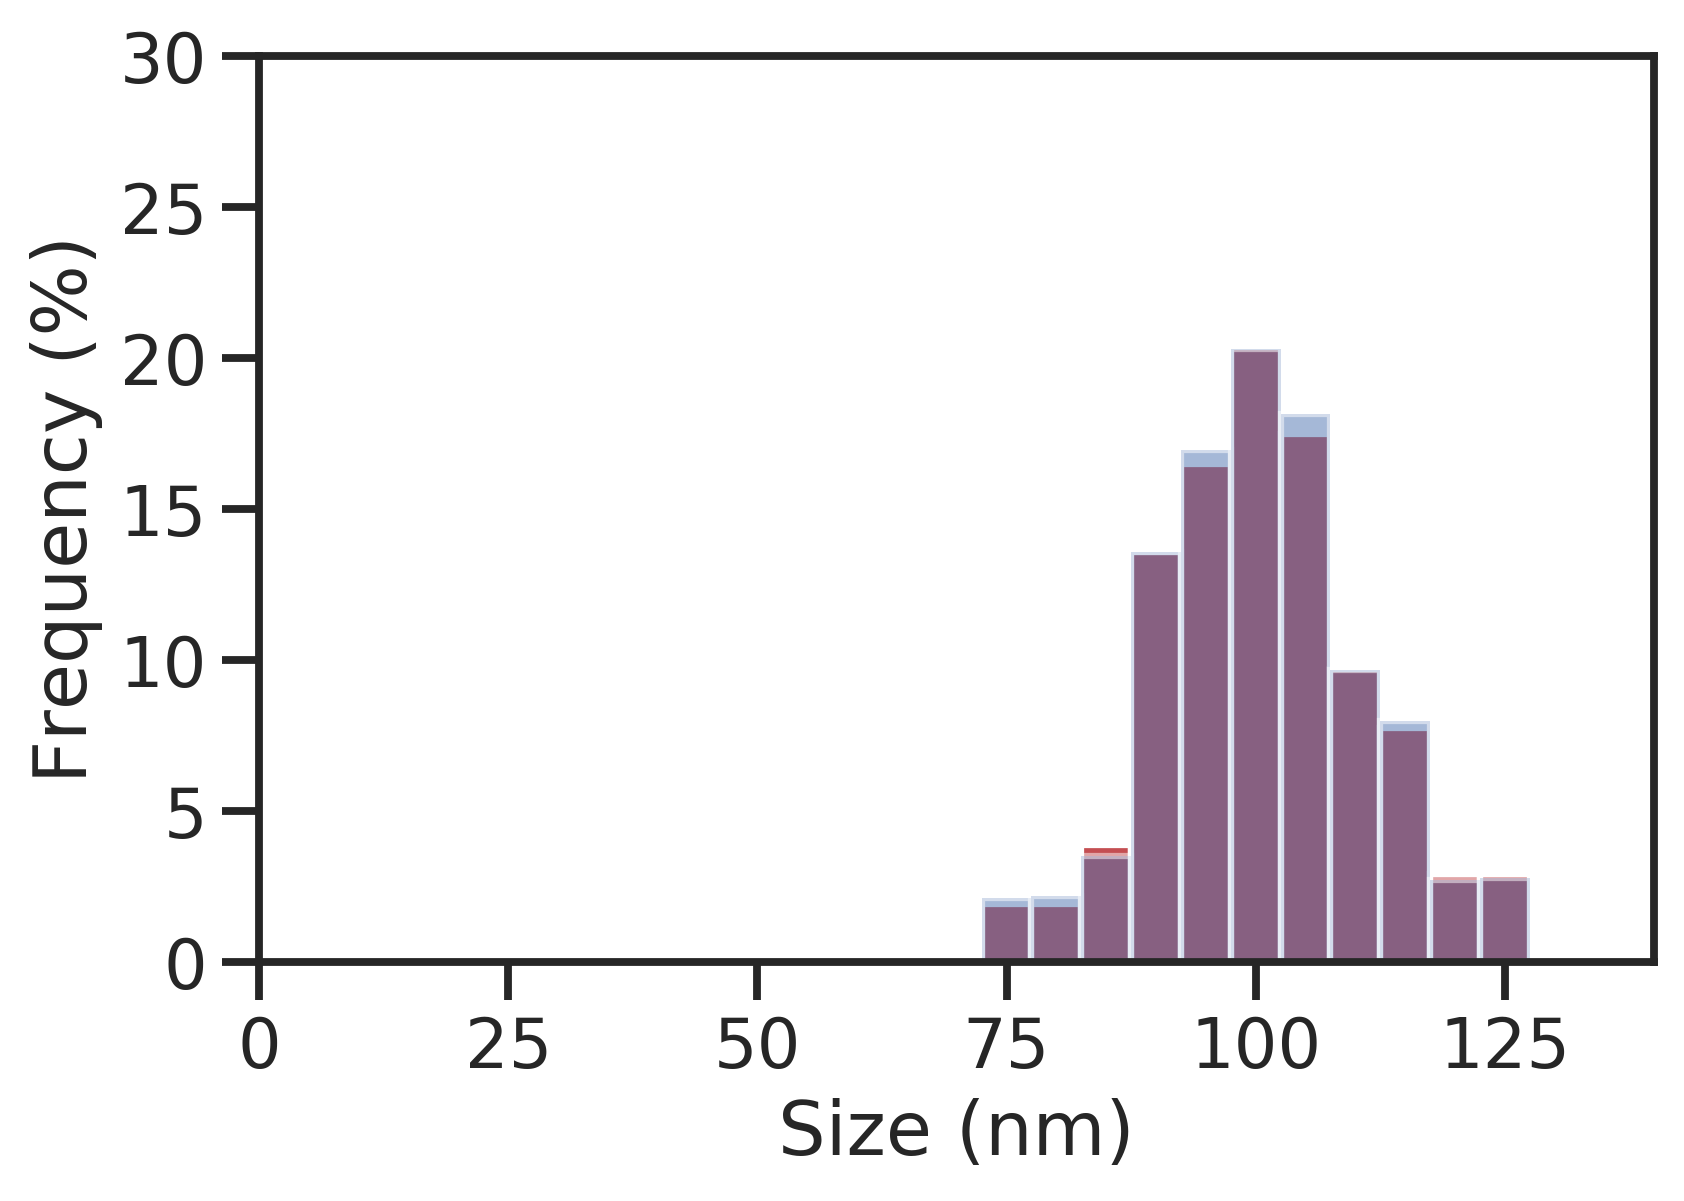

In [90]:
counts, _edges = np.histogram(sample_sizes, bins=edges)

freq = 100 * counts / len(sample_sizes)
print(freq[:5])
plt.hist(centers, bins=edges, weights=dist['initial'], color='r')
plt.hist(centers, bins=edges, weights=freq, color='b', alpha=0.5)
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,30))

## Surface Layer Ablation - Single Particle

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms a single particle so that there are two daugter particles: one corresponding to the surface layer and one for the remaining particle core.

In [91]:
rads = sample_sizes / 2
shell_width = 0.06 * rads
print(shell_width[:5])
rcore = rads - shell_width
Dcore = 2 * rcore
rsl = ( rads**3 - rcore**3)**(1/3)
print(rsl[:5])
Dsl = 2 * rsl
print(Dsl[:5])

[2.77484631 2.56857349 2.66033869 3.02998803 2.98924183]
[25.59012992 23.68784505 24.53412014 27.94309259 27.56732385]
[51.18025983 47.37569009 49.06824029 55.88618518 55.13464769]


In [92]:
frag_sizes = np.concatenate((Dsl, Dcore))

In [93]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[0 0 0 0 0]
[0. 0. 0. 0. 0.]


(0, 40)

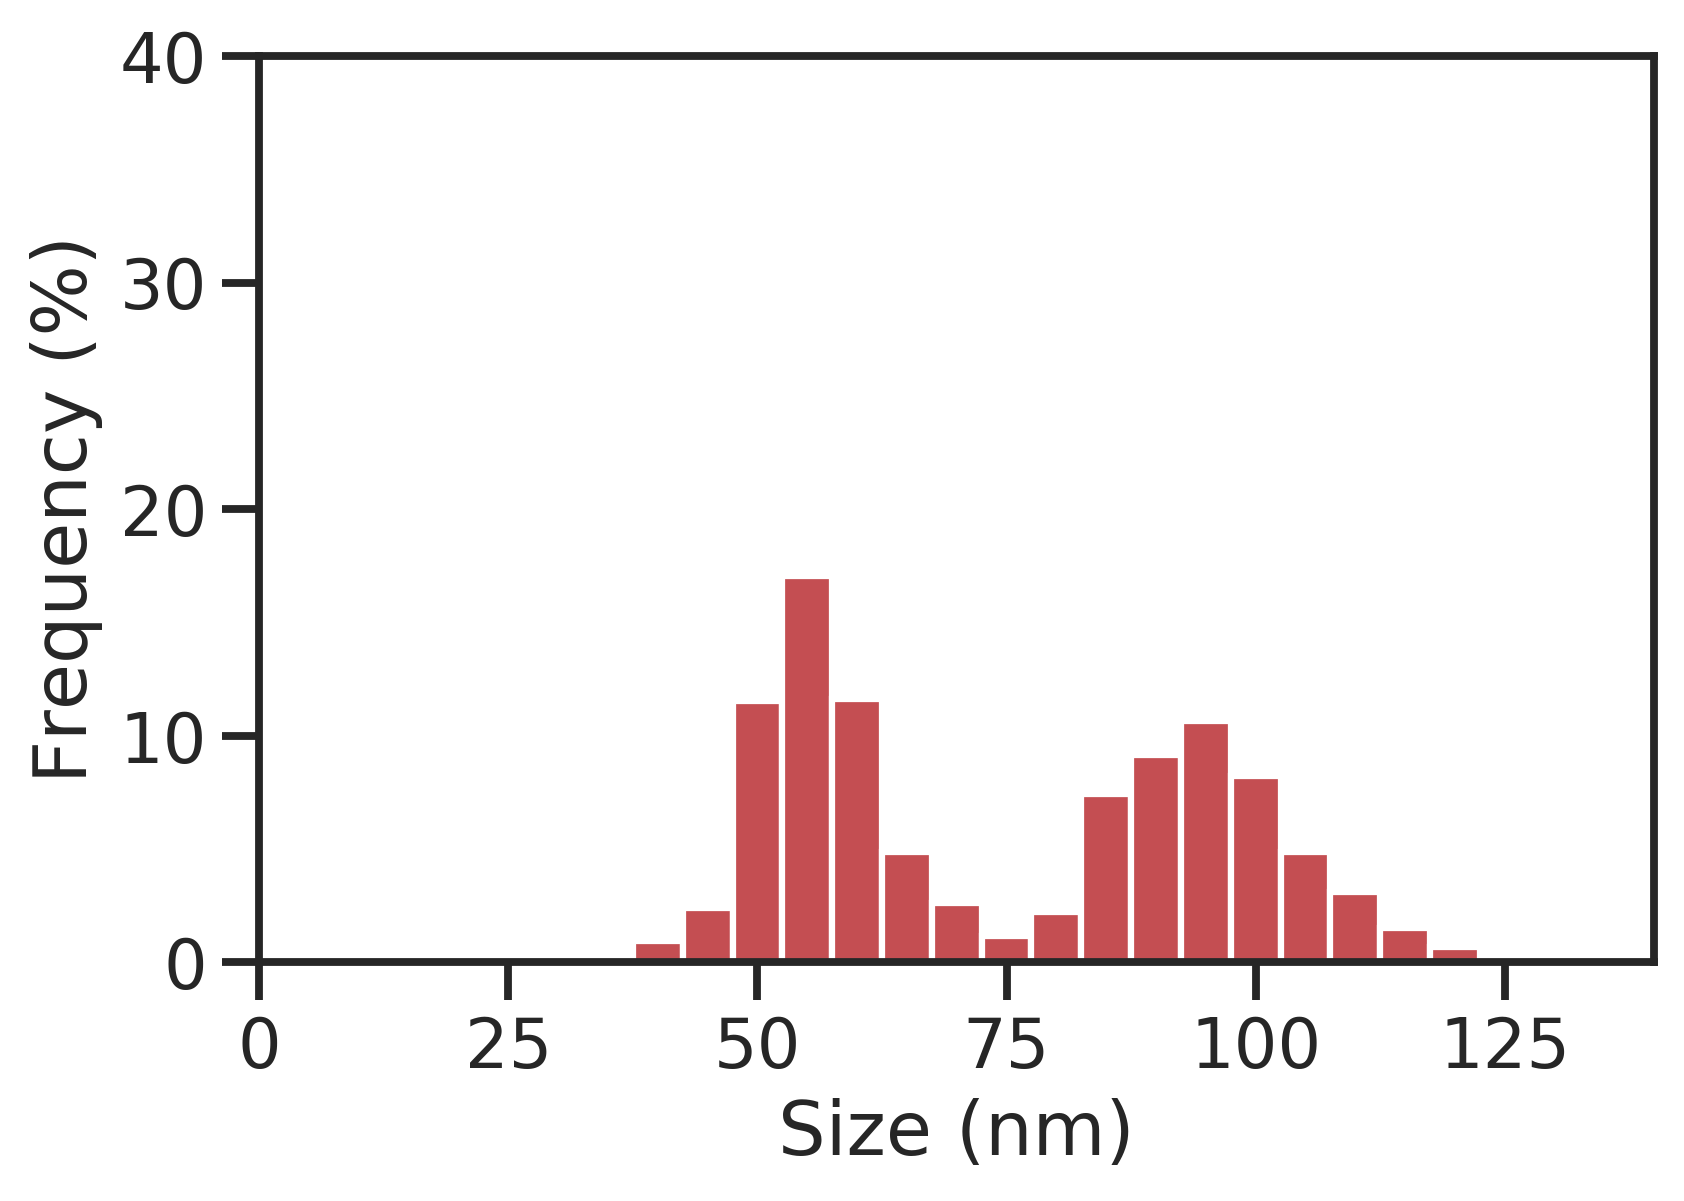

In [94]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

In [95]:
np.savetxt('100nm_explore_centers.txt', centers)
np.savetxt('100nm_explore_edges.txt', edges)
np.savetxt('100nm_explore_frequency_sa_1part.txt', frag_freq)

(0, 40)

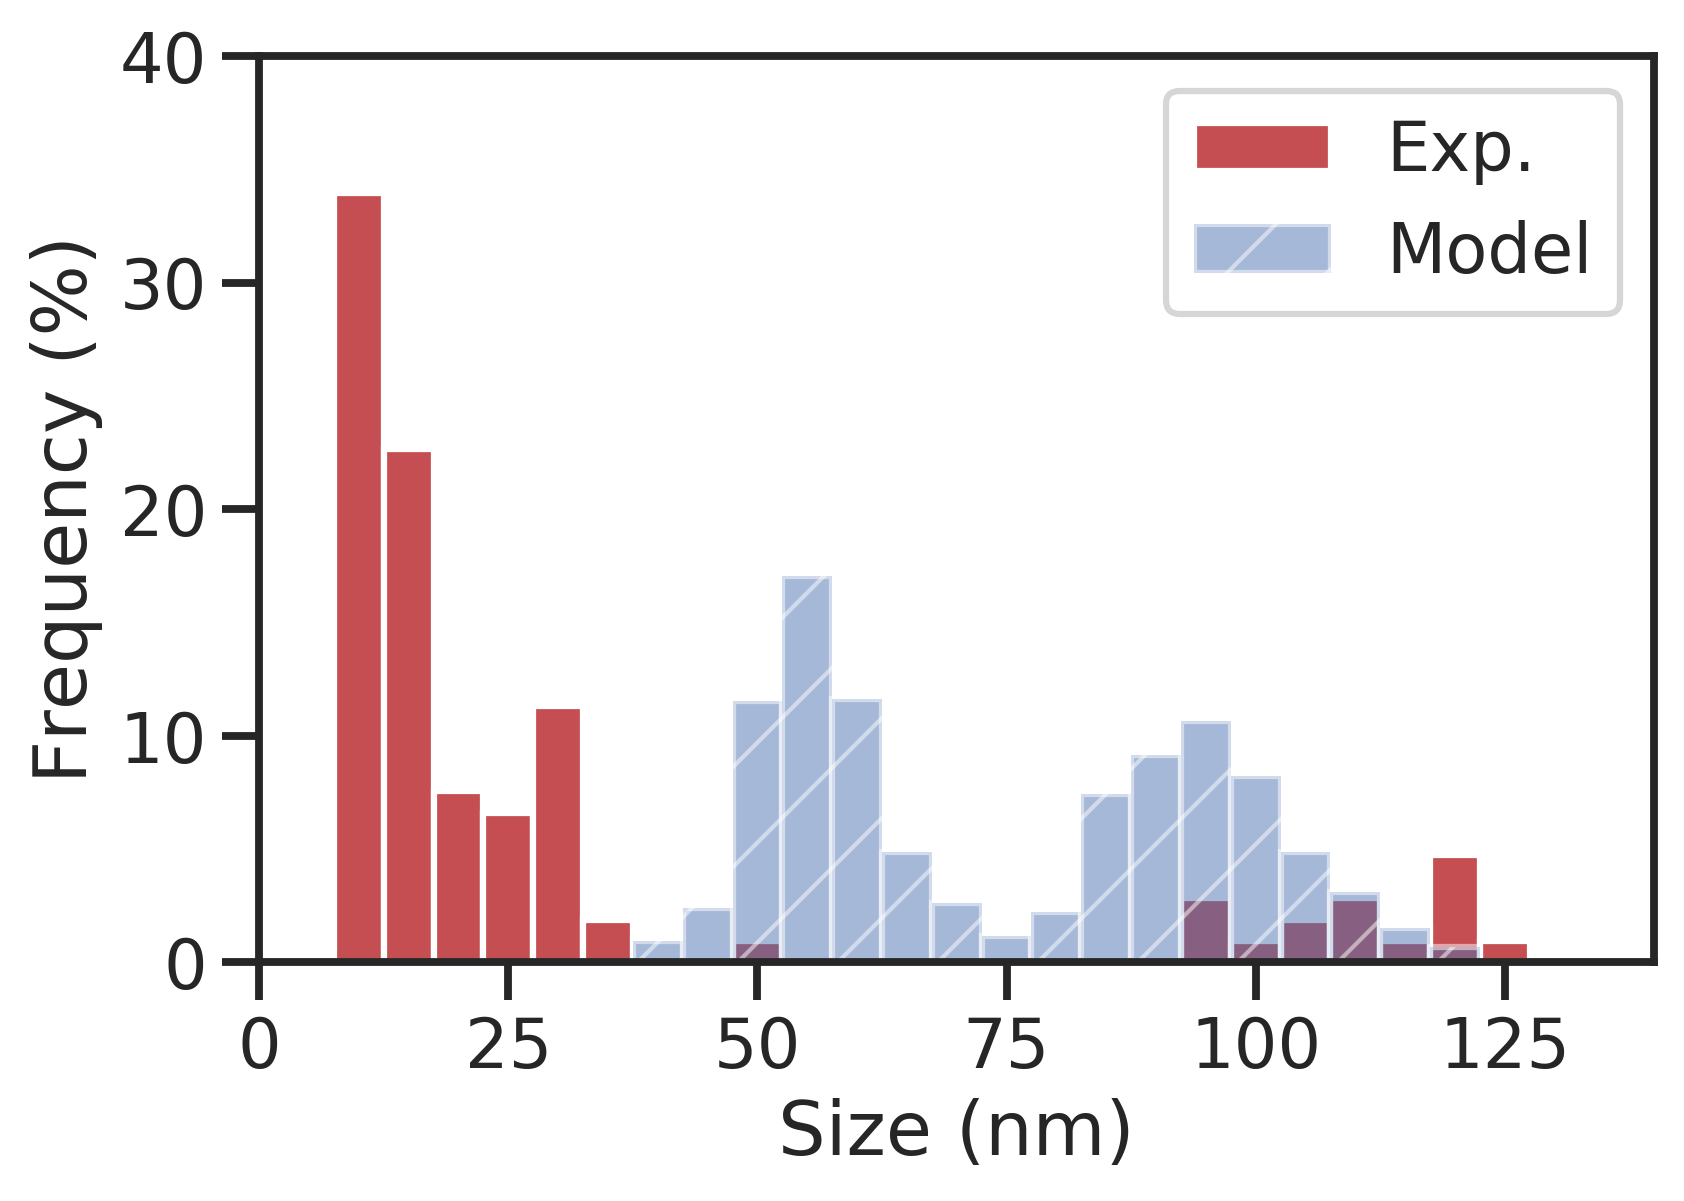

In [96]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,40))

## Surface Layer Ablation - Two Particles

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms two equal volume particles so that there are three daughter particles: two corresponding to the surface layer and one for the remaining particle core.

In [97]:
shell_width = 0.06 * rads
print(shell_width[:5])
rcore = rads - shell_width
Dcore = 2 * rcore
rsl = ( rads**3 - rcore**3)**(1/3)
rfrag = rsl/(2)**(1/3)
print(rsl[:5])
Dfrag = 2 * rfrag
print(Dsl[:5])

[2.77484631 2.56857349 2.66033869 3.02998803 2.98924183]
[25.59012992 23.68784505 24.53412014 27.94309259 27.56732385]
[51.18025983 47.37569009 49.06824029 55.88618518 55.13464769]


In [98]:
frag_sizes = np.concatenate((Dfrag, Dfrag, Dcore))

In [99]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[0 0 0 0 0]
[0. 0. 0. 0. 0.]


(0, 40)

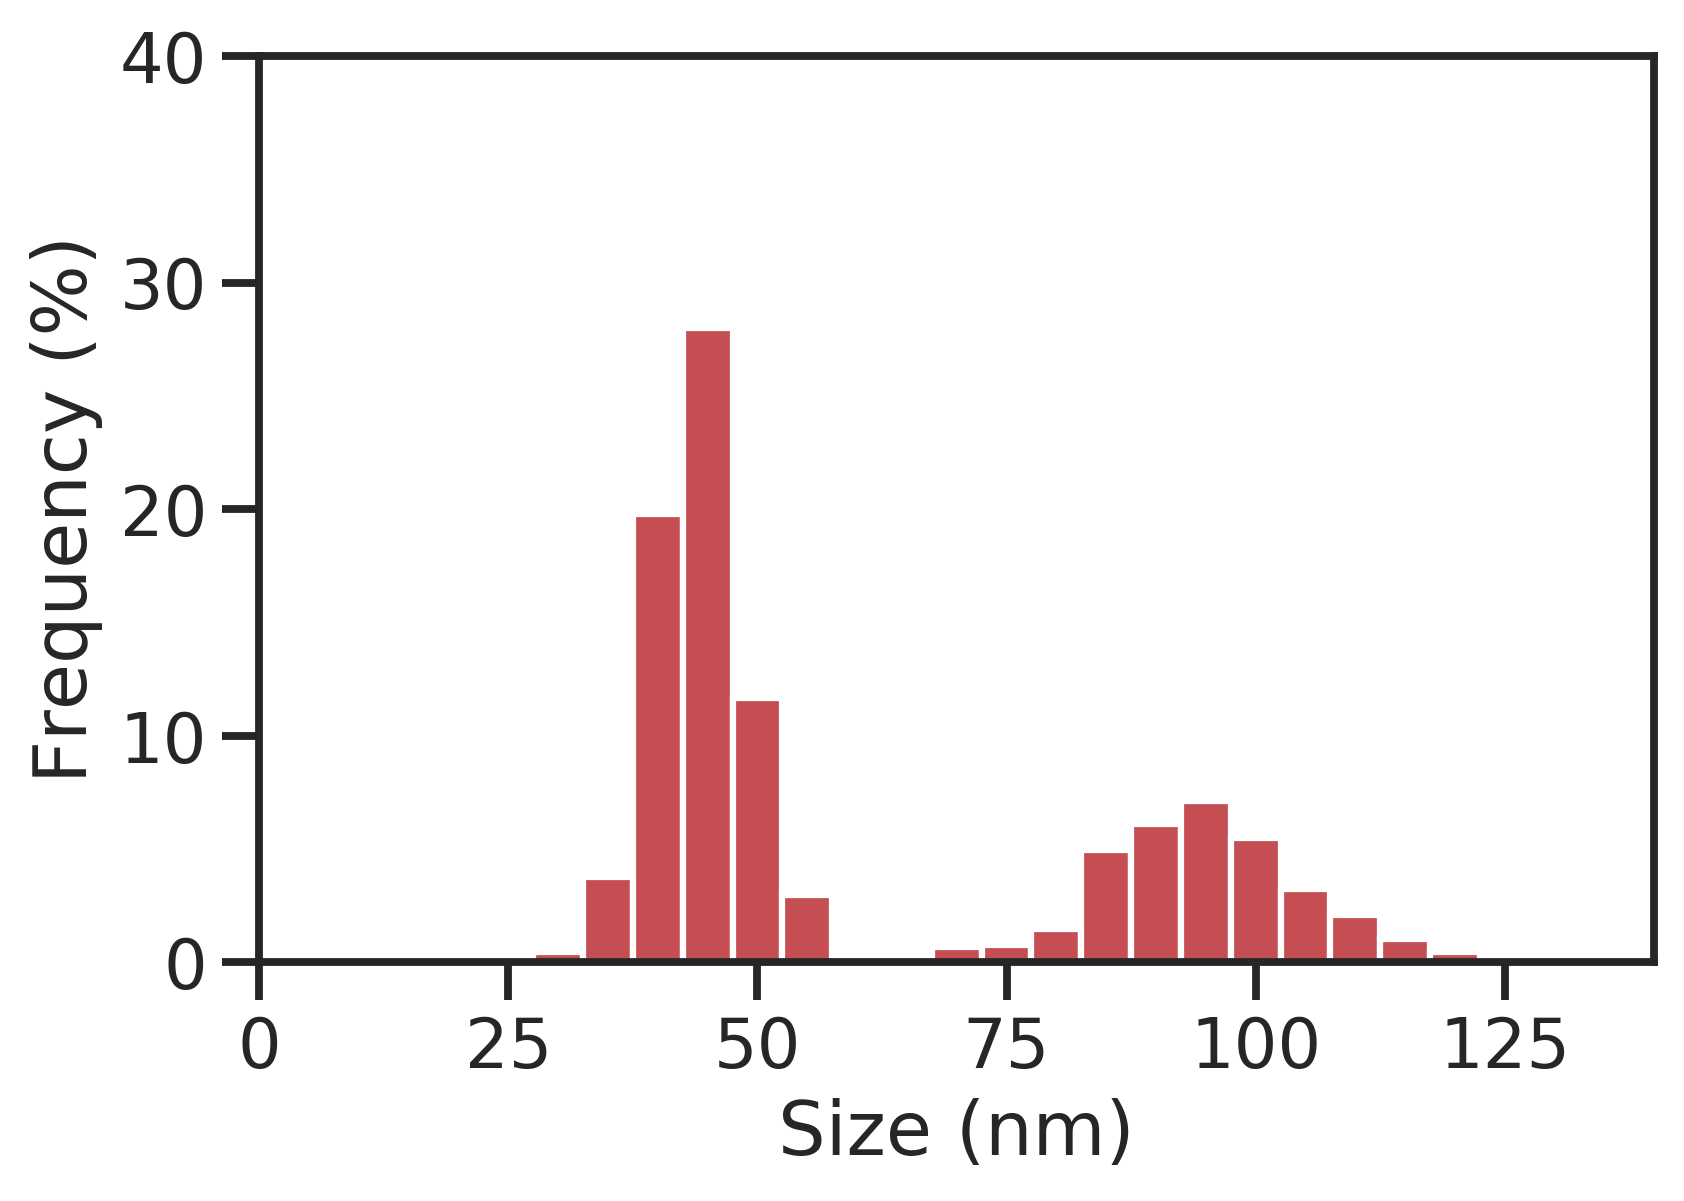

In [100]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

In [101]:
np.savetxt('100nm_explore_frequency_sa_2part.txt', frag_freq)

(0, 40)

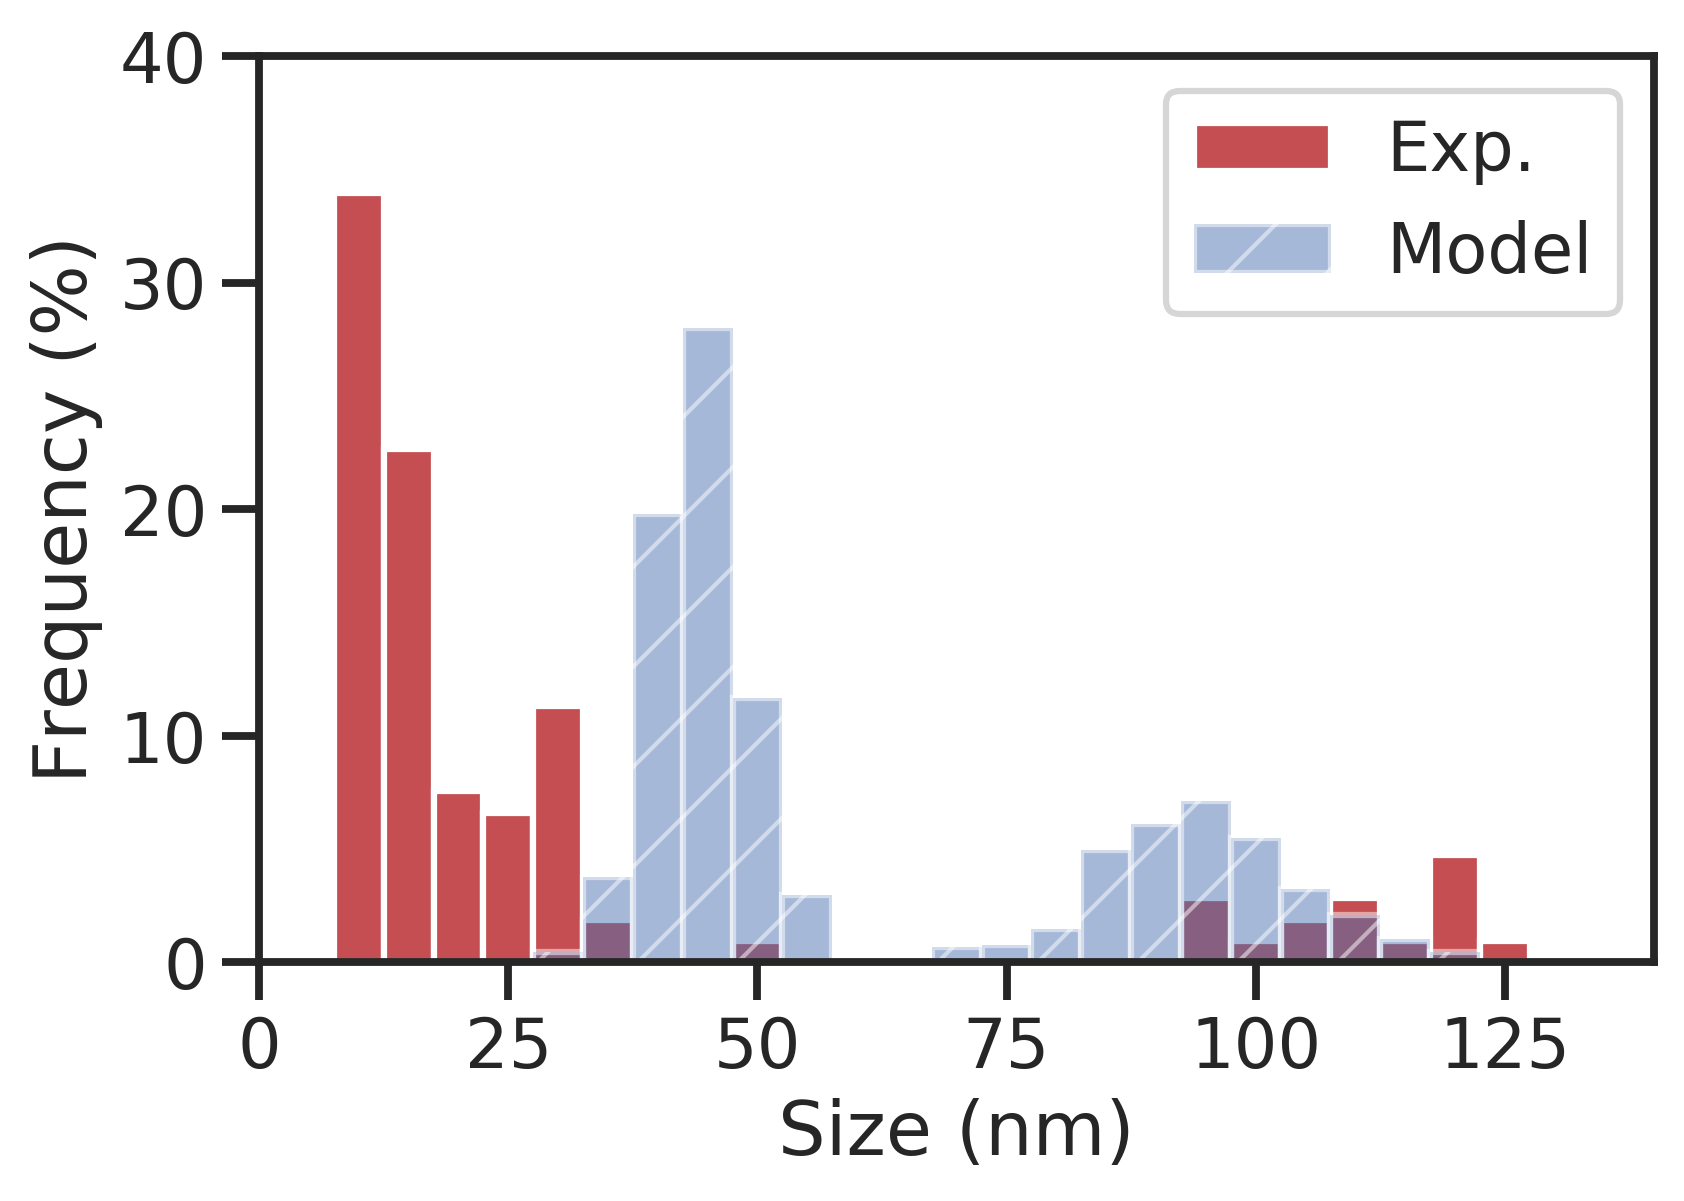

In [102]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,40))

(0, 40)

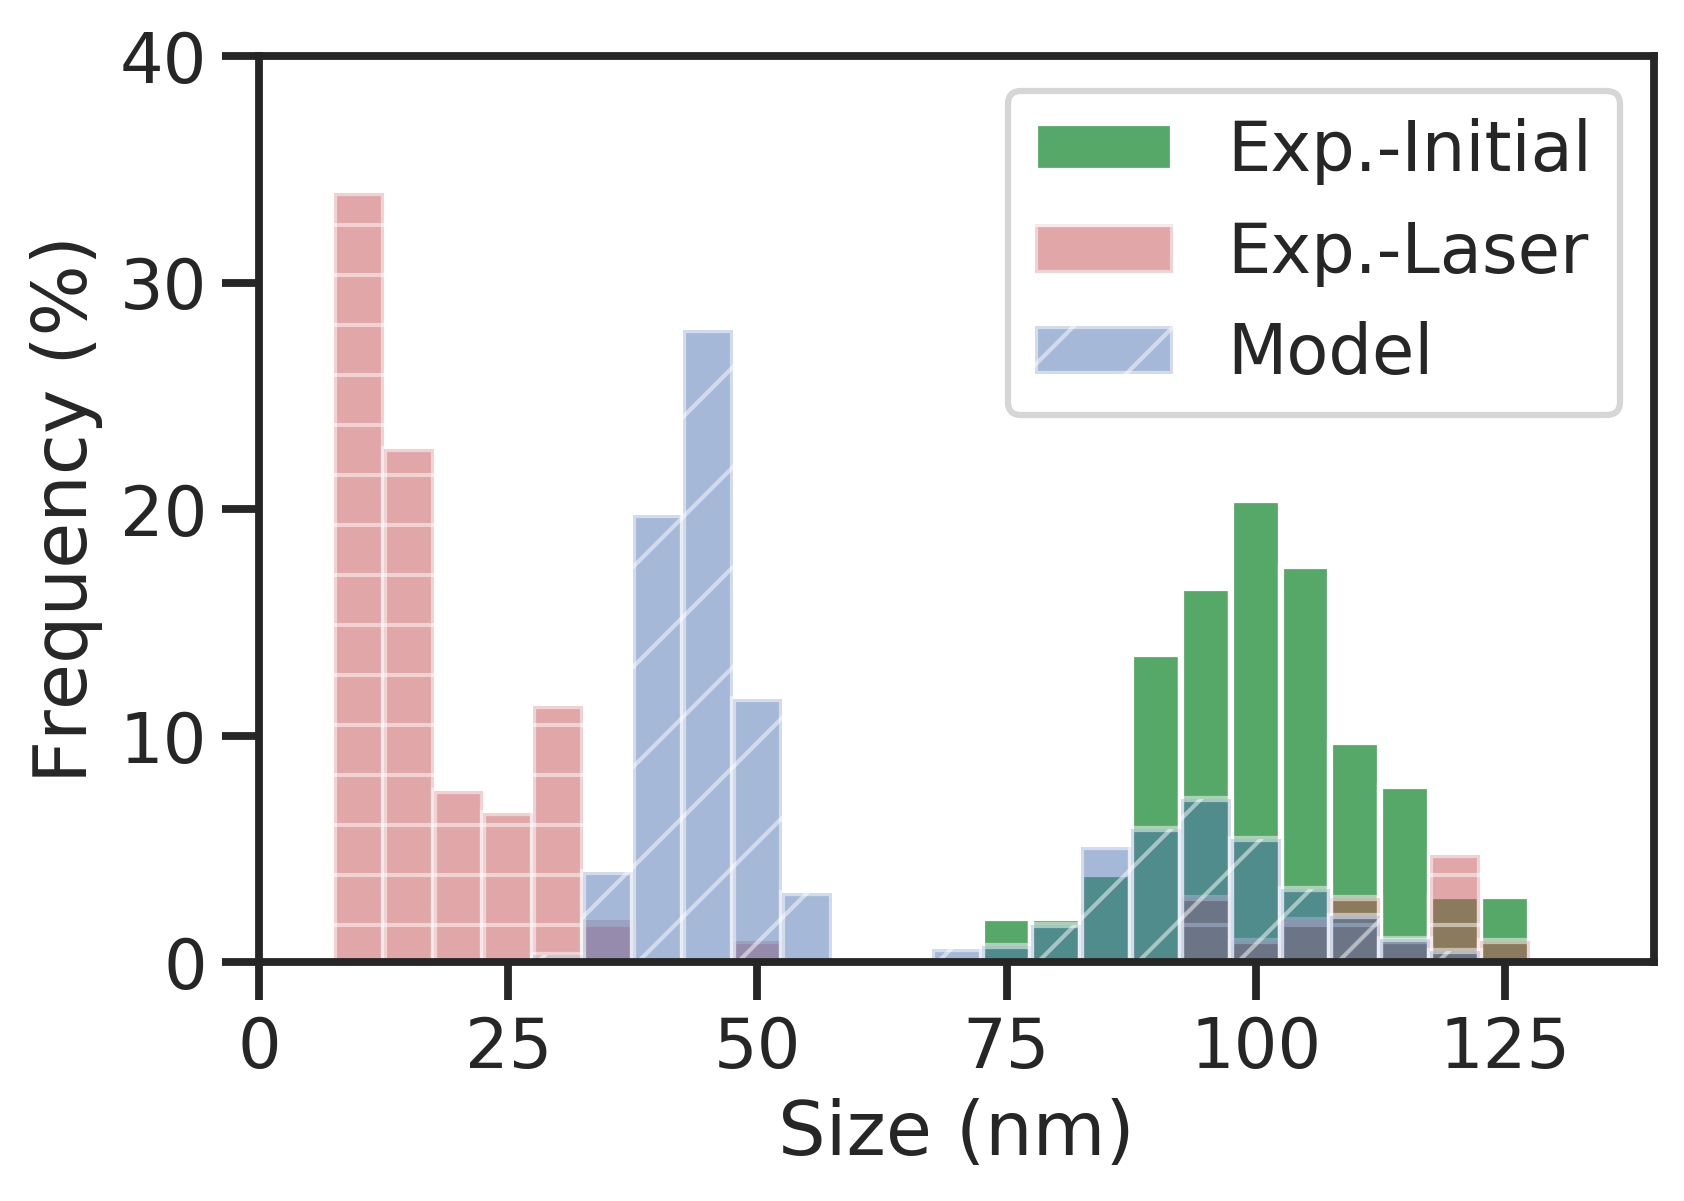

In [105]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,40))

## Surface Layer Ablation - Two Particles - Partial ablation

Here, we apply a model for surface layer ablation assuming that the surface layer corresponding to 6% thickness is ablated from the particle and forms two equal volume particles so that there are three daughter particles: two corresponding to the surface layer and one for the remaining particle core.

In [106]:
shell_width = 0.06 * rads[:int(0.5*len(rads))]
print(shell_width[:5])
rcore = rads[:int(0.5*len(rads))] - shell_width
Dcore = 2 * rcore
rsl = ( rads[:int(0.5*len(rads))]**3 - rcore**3)**(1/3)
rfrag = rsl/(2)**(1/3)
print(rsl[:5])
Dfrag = 2 * rfrag
# pick out half the surface layer fragments -- these will merge onto unfragmented particles
Vfrag = (4/3)*np.pi* rfrag[:int(0.5*len(rfrag))]**3
print(Dsl[:5])
Vo = (4/3)*np.pi * rads[int(0.5*len(rads)):]
Vp = Vo[:len(Vfrag)] + Vfrag
rp = ( (3/(4*np.pi)) * Vp )**(1/3)
Dp = 2*rp

[2.50898225 3.6403858  3.14925579 3.81565326 3.09404662]
[23.13828397 33.57229022 29.04300126 35.1886382  28.53385242]
[46.27656795 67.14458044 58.08600252 70.37727639 57.06770484]


In [107]:
frag_sizes = np.concatenate((Dfrag[int(0.5*len(Dfrag)):], Dcore, Dp))

In [108]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[0 0 0 0 0]
[0. 0. 0. 0. 0.]


(0, 40)

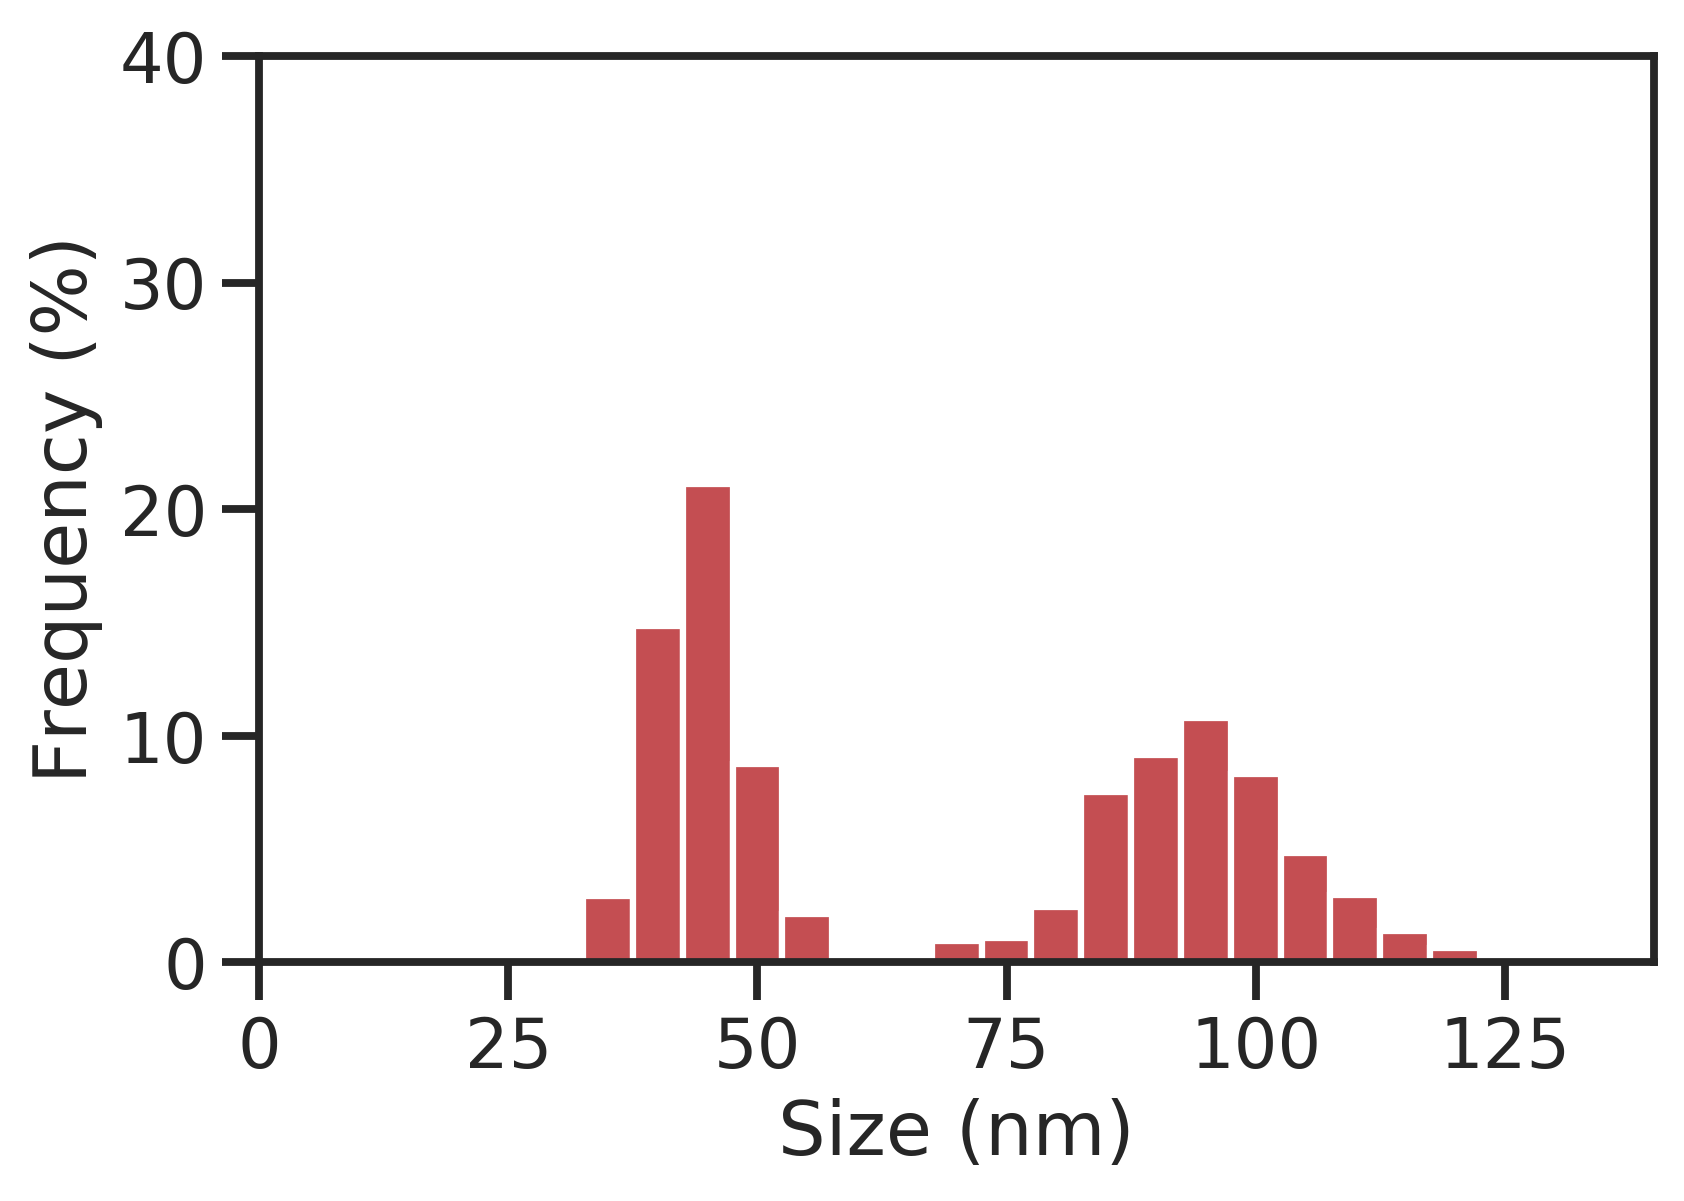

In [109]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

(0, 40)

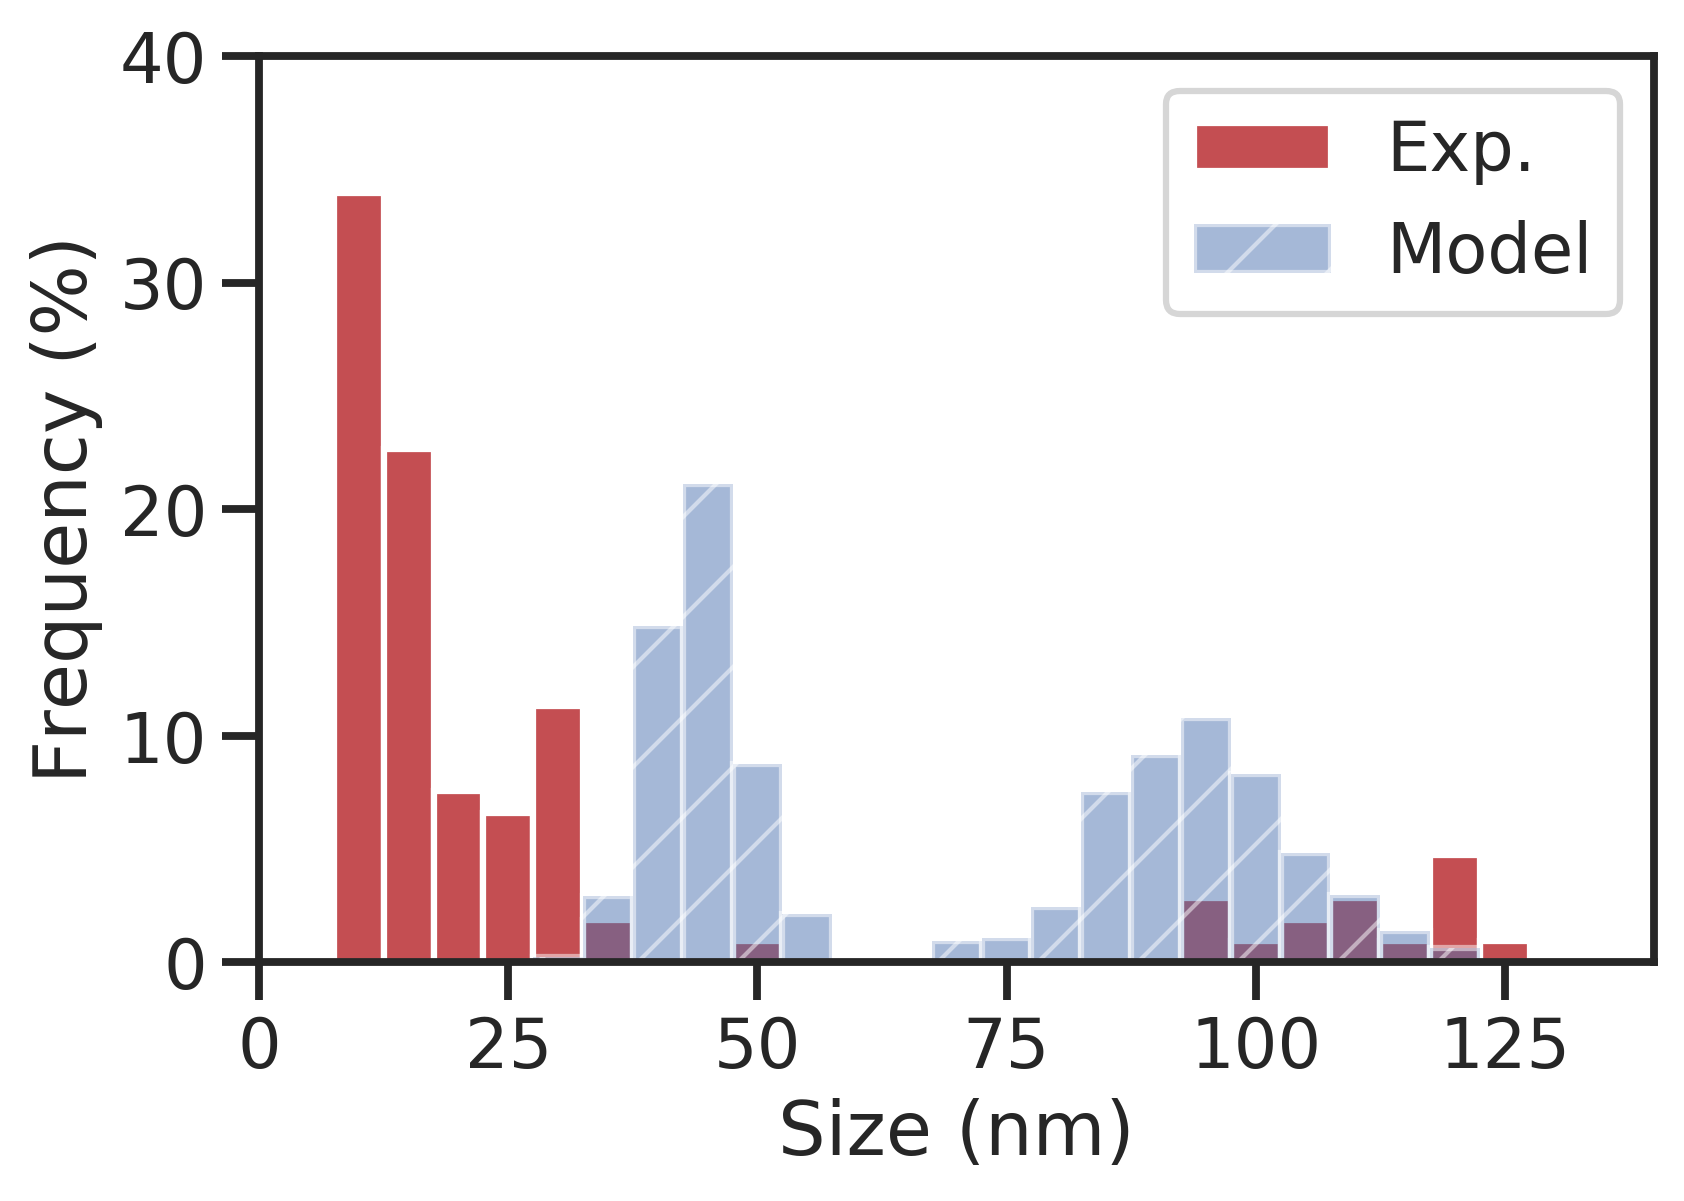

In [110]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,40))

(0, 40)

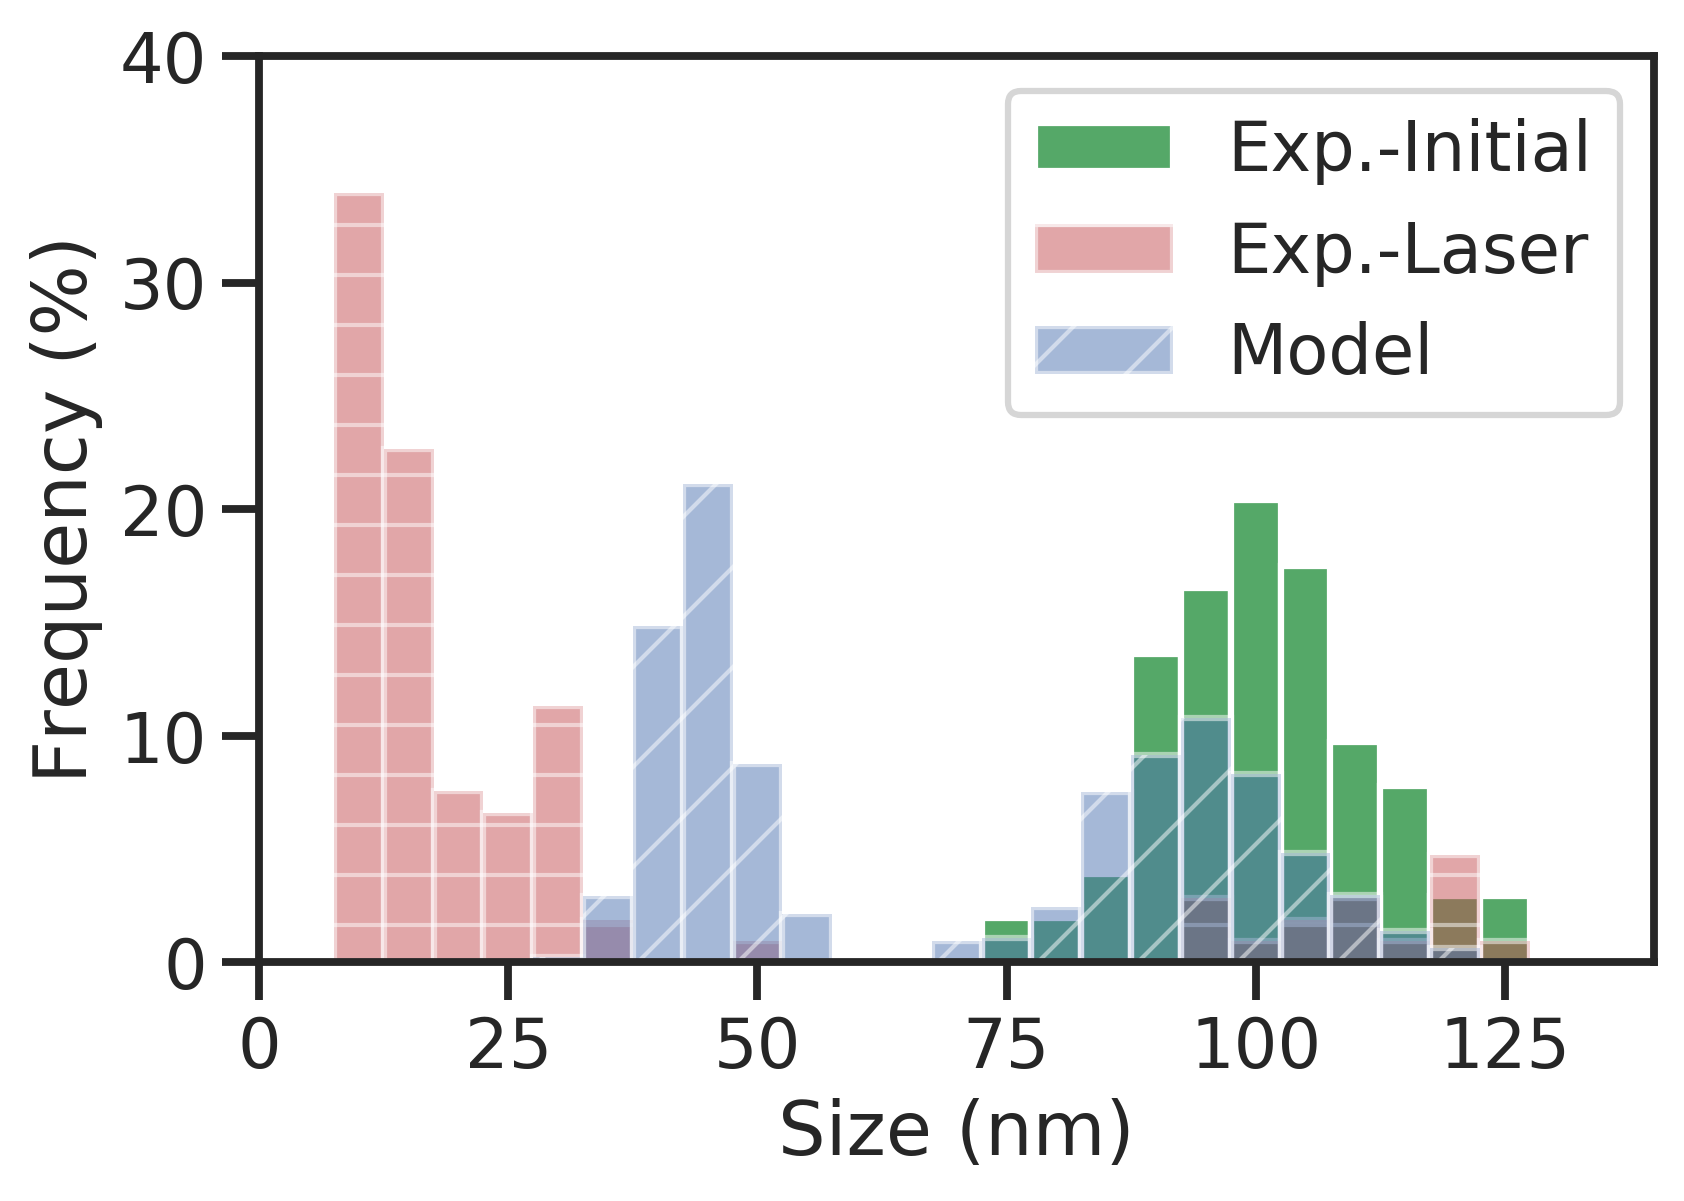

In [111]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,40))

## Particle Split - Two Particles

Here, we apply a model for 1/3 of particles splitting into two particles of equal volume particles, so that the ratio of fragments to unfragmented particles is 1:1.

In [103]:
Vo = (4/3)*np.pi*rads**3
Vfrag = Vo[:int(0.33*len(Vo))]/2
rfrag = ((3/4)*Vfrag/np.pi)**(1/3) 
Dfrag = rfrag*2

In [104]:
frag_sizes = np.concatenate((Dfrag, Dfrag, sample_sizes[int(0.33*len(Vo)):]))

In [105]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[0 0 0 0 0]
[0. 0. 0. 0. 0.]


(0, 40)

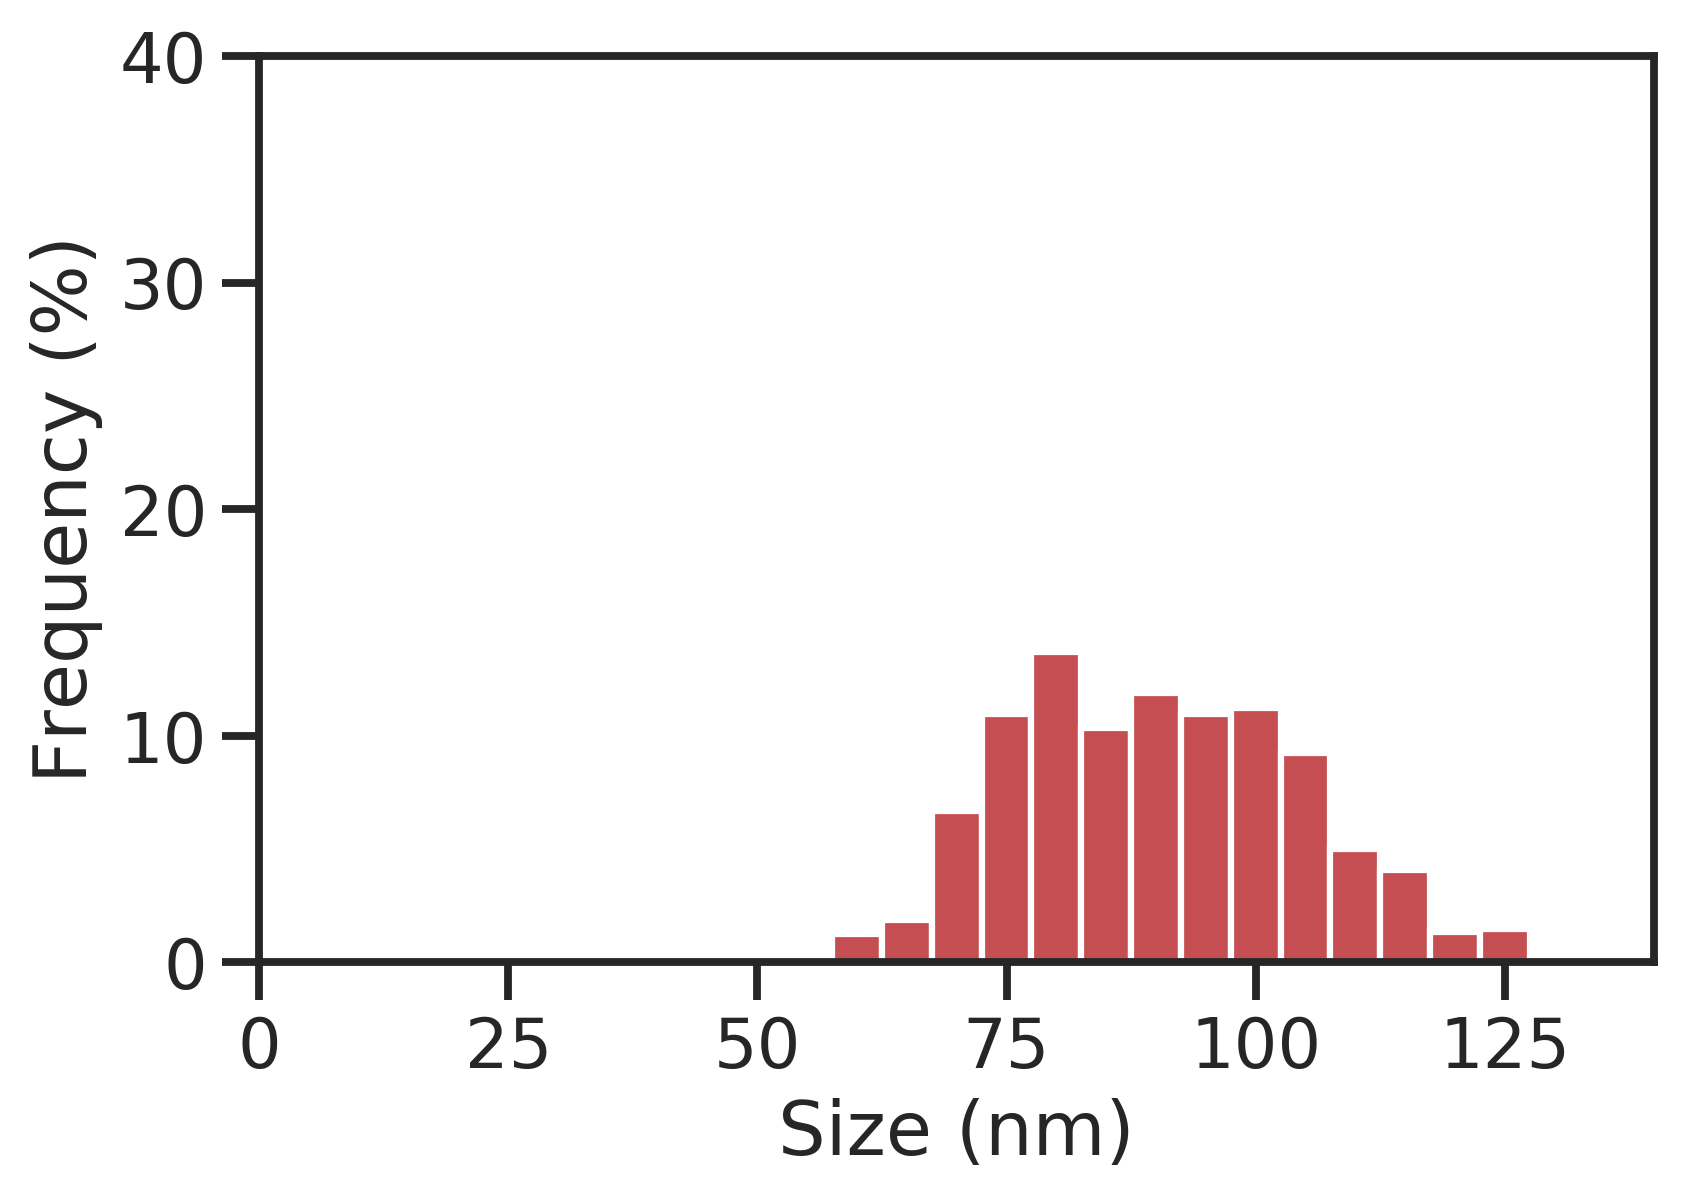

In [106]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

In [107]:
np.savetxt('100nm_explore_frequency_ps_2part.txt', frag_freq)

(0, 40)

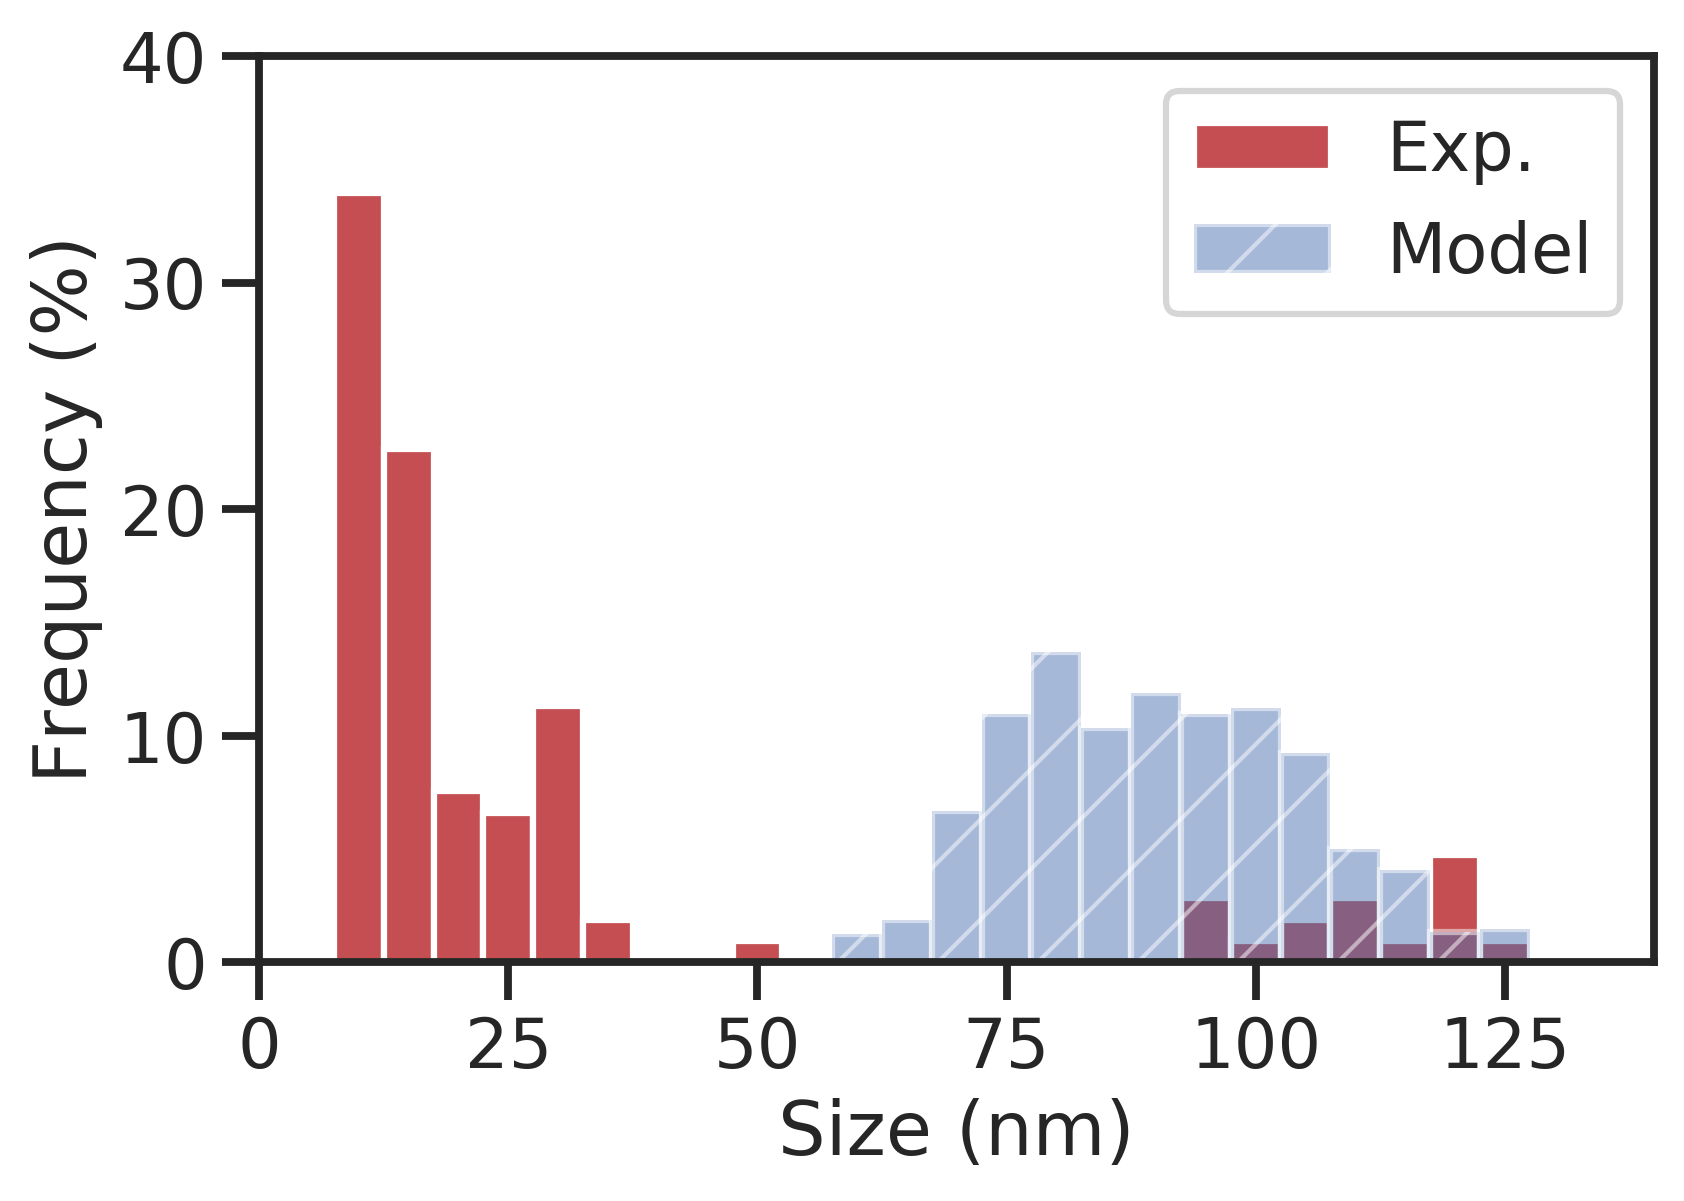

In [108]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,40))

(0, 40)

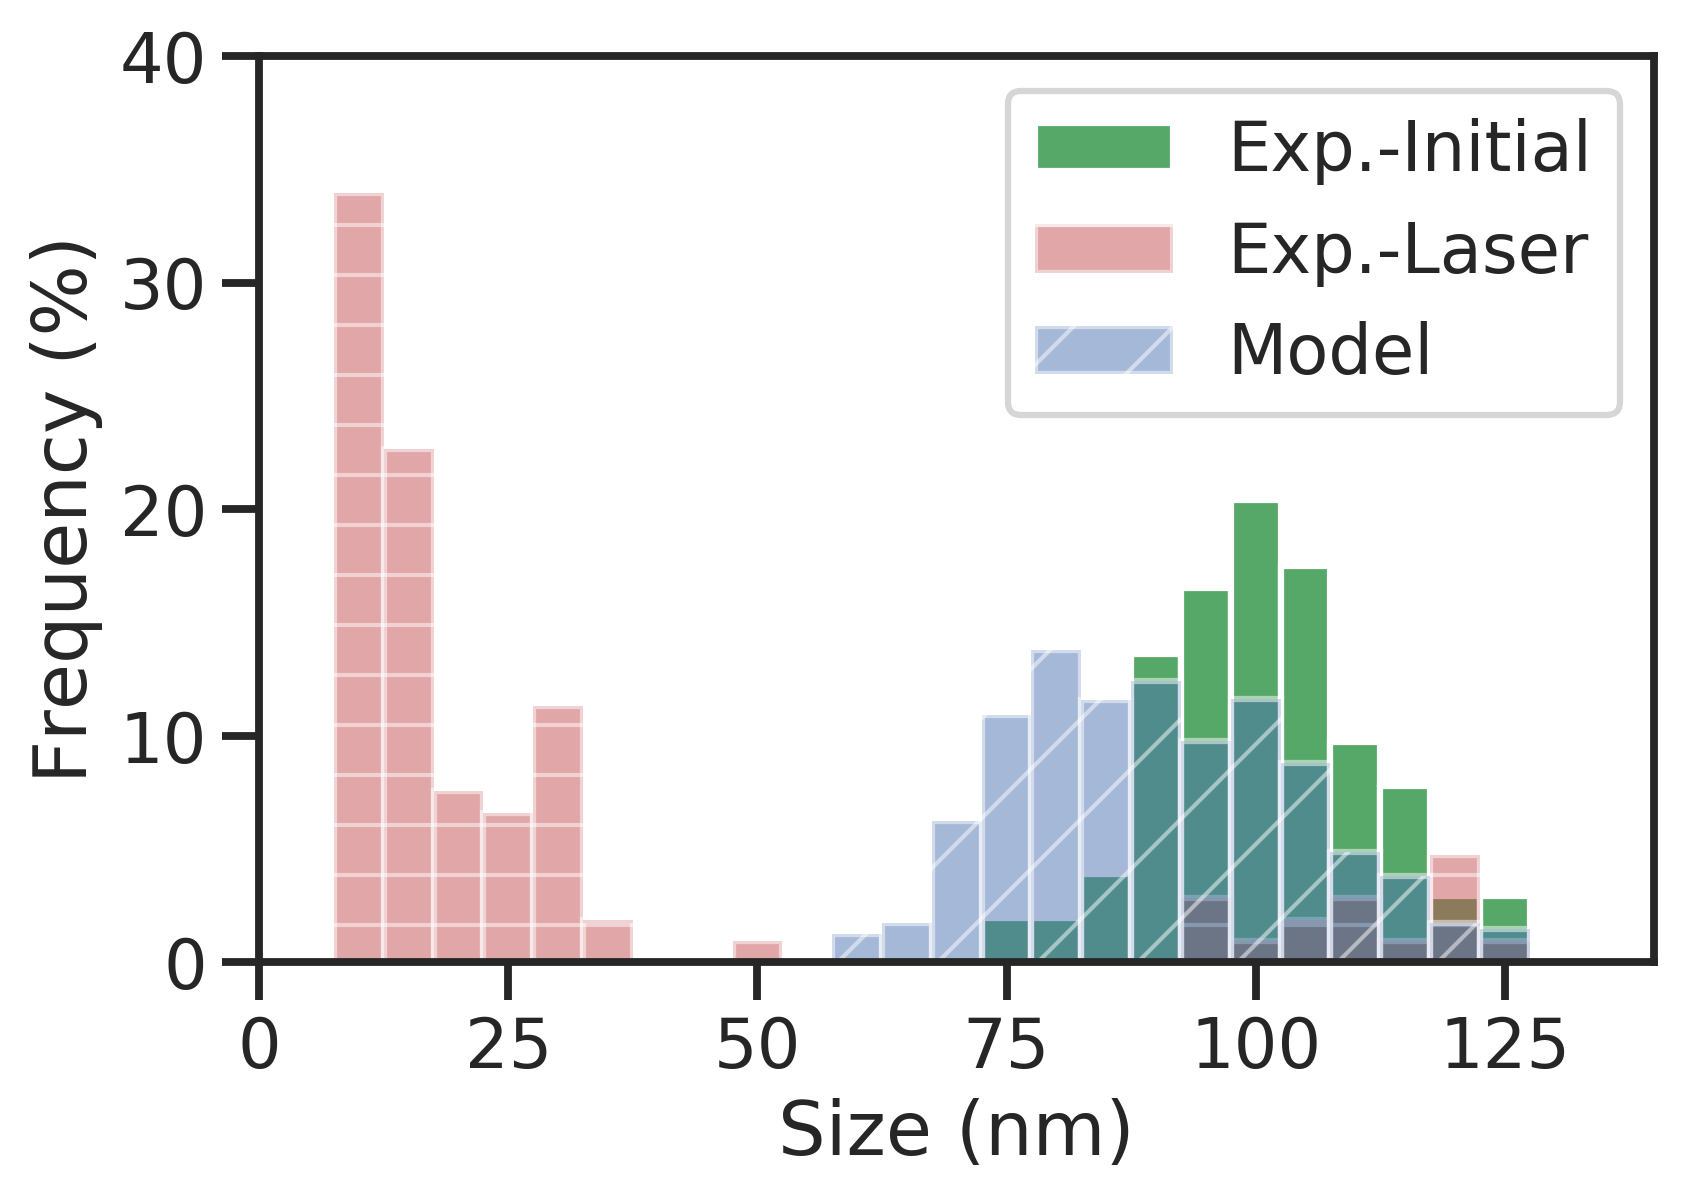

In [117]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,40))

## Particle Split - Four Particles

Here, we apply a model for 1/5 of particles splitting into four particles of equal volume particles, so that the ratio of fragments to unfragmented particles is 1:1.

In [118]:
Vo = (4/3)*np.pi*rads**3
Vfrag = Vo[:int(0.2*len(Vo))]/4
rfrag = ((3/4)*Vfrag/np.pi)**(1/3) 
Dfrag = rfrag*2

In [119]:
frag_sizes = np.concatenate((Dfrag, Dfrag, Dfrag, Dfrag, sample_sizes[int(0.2*len(Vo)):]))

In [120]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[0 0 0 0 0]
[0. 0. 0. 0. 0.]


(0, 40)

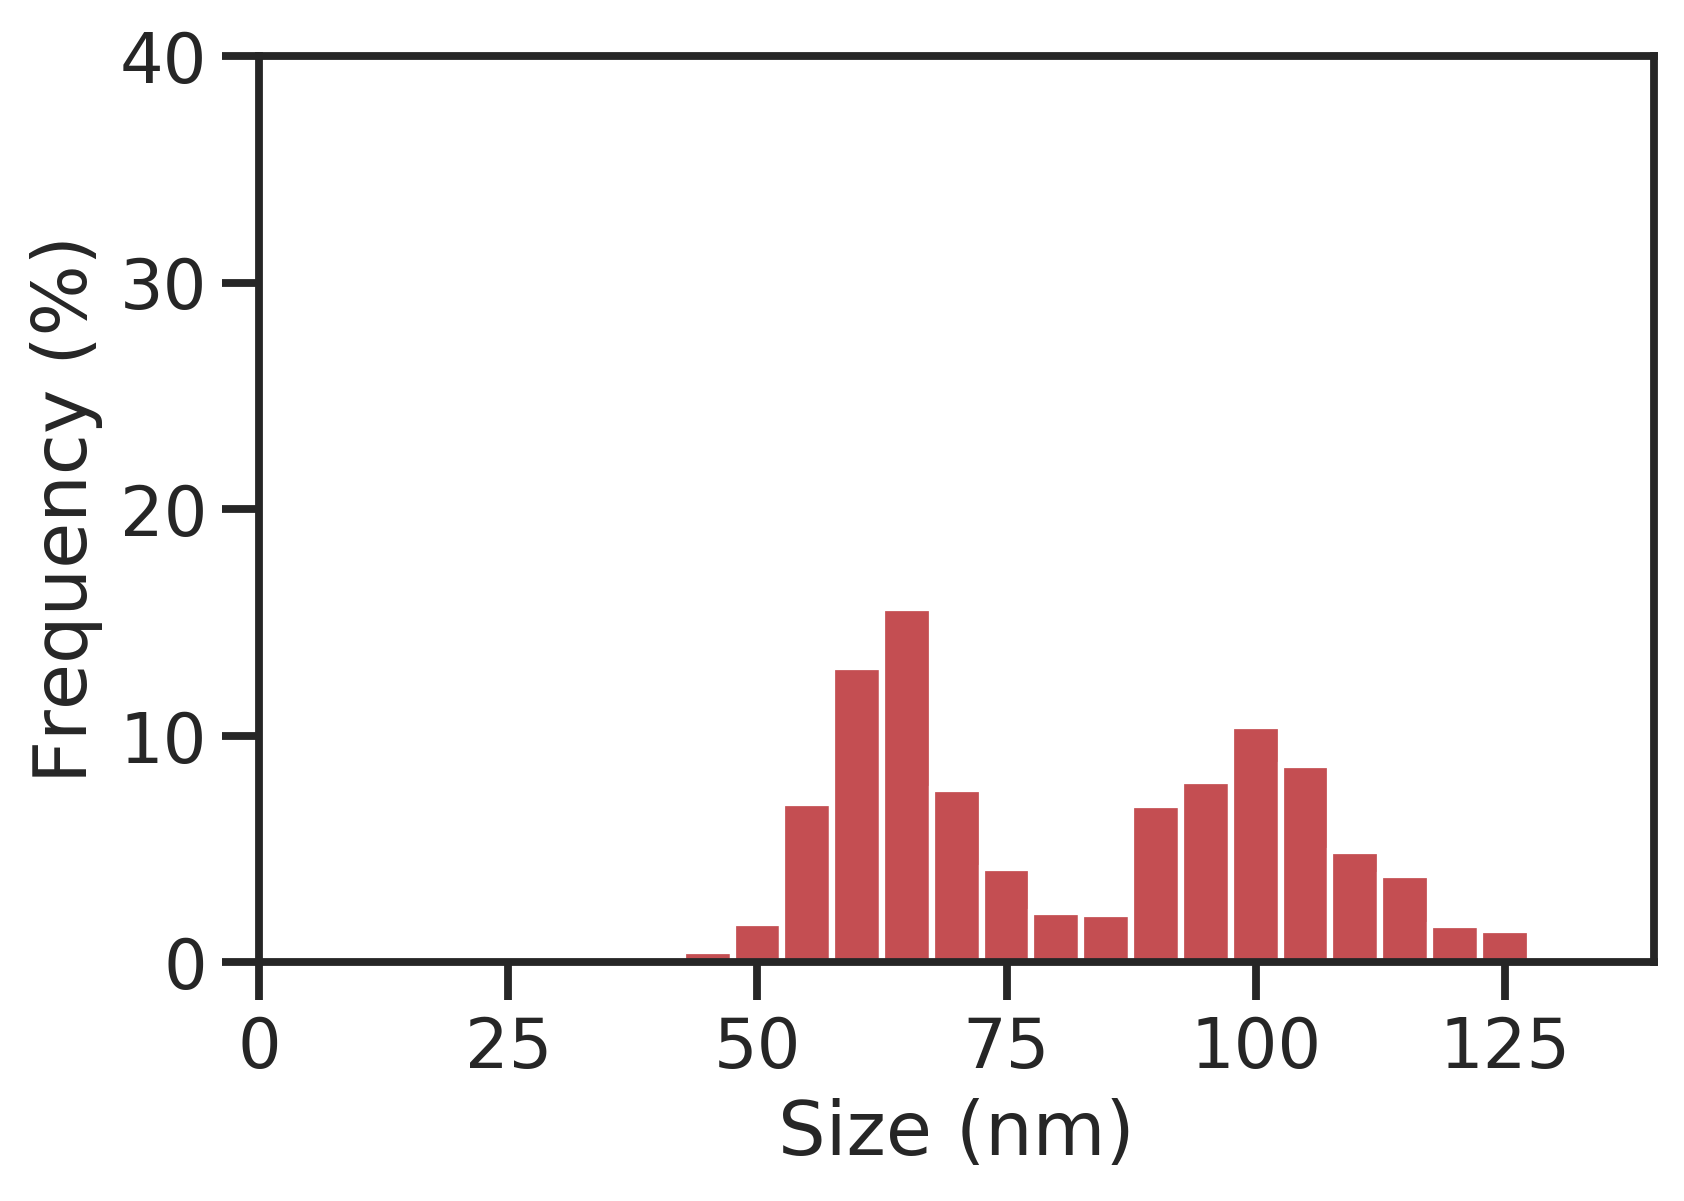

In [121]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

(0, 40)

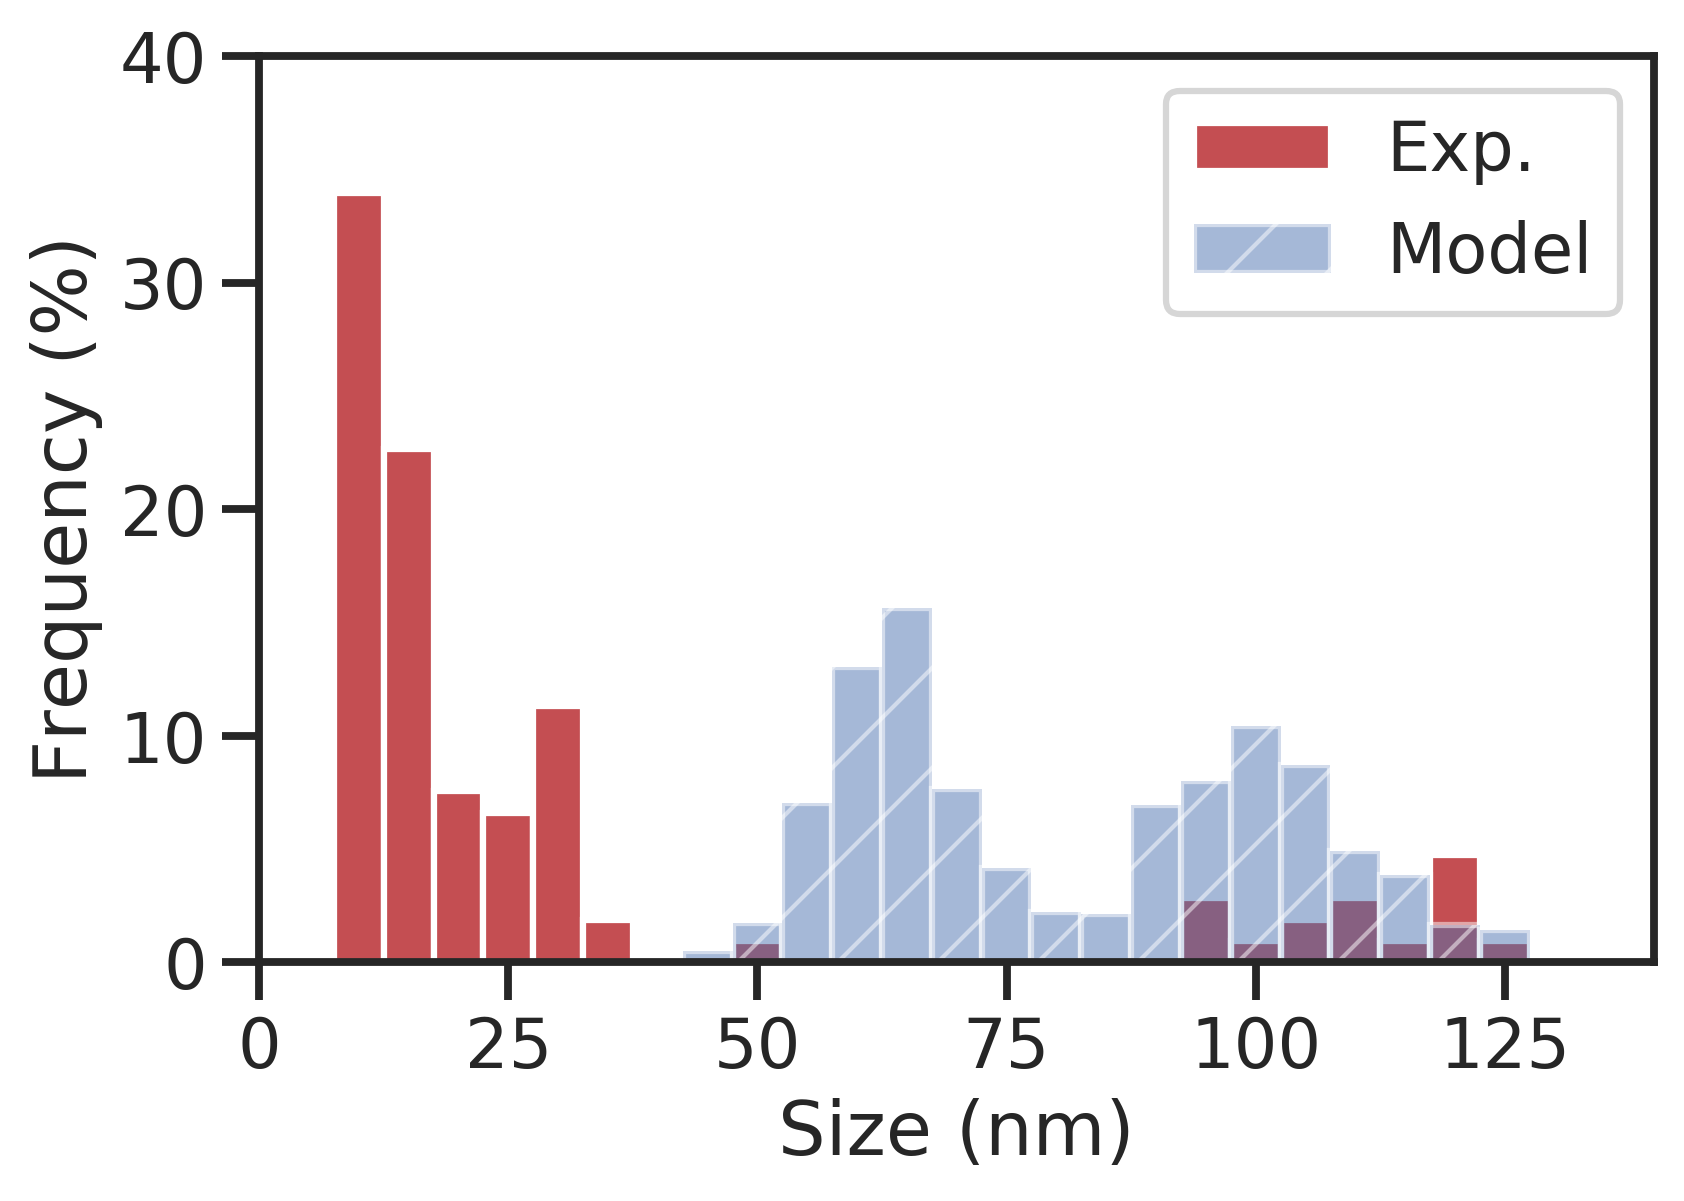

In [122]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,40))

(0, 40)

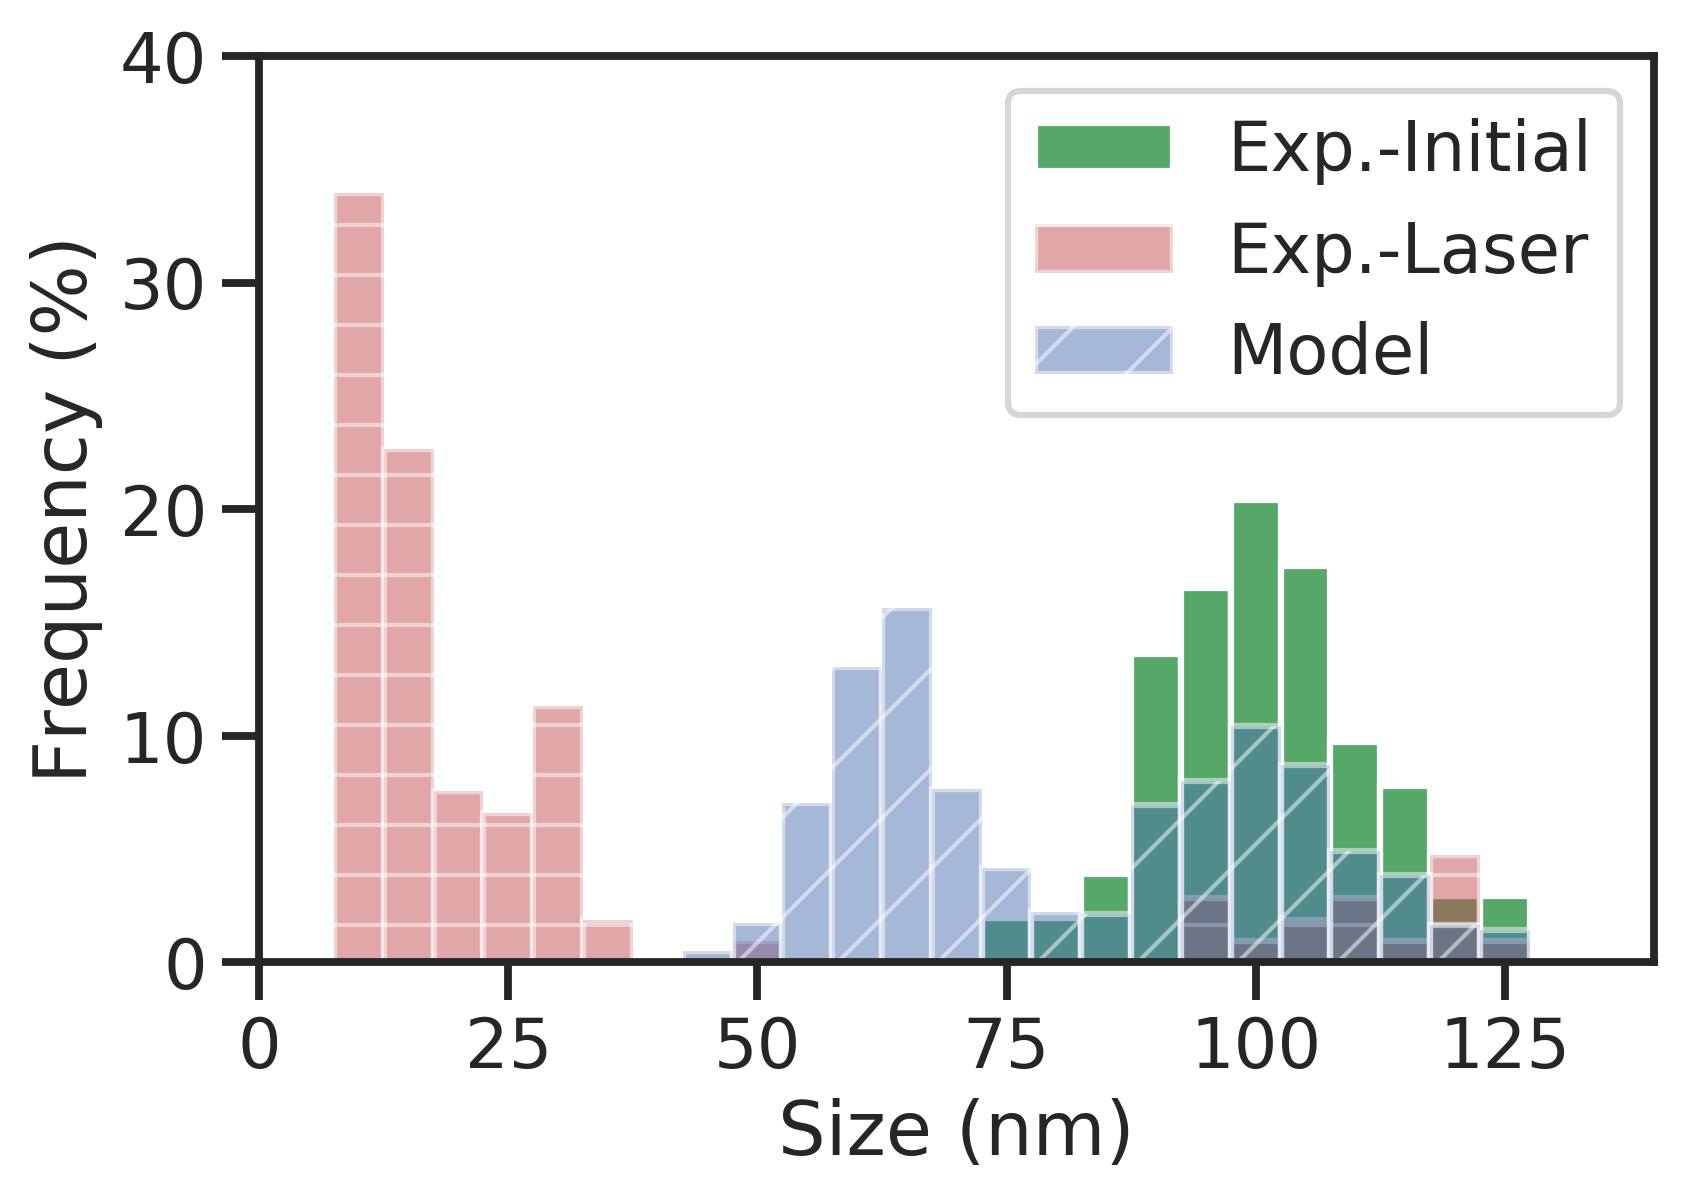

In [123]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,40))

## Particle Split - Eight Particles

Here, we apply a model for 1/5 of particles splitting into four particles of equal volume particles, so that the ratio of fragments to unfragmented particles is 1:1.

In [109]:
Vo = (4/3)*np.pi*rads**3
frac = 0.111
Vfrag = Vo[:int(frac*len(Vo))]/8
rfrag = ((3/4)*Vfrag/np.pi)**(1/3) 
Dfrag = rfrag*2

In [110]:
frag_sizes = np.concatenate((Dfrag, Dfrag, Dfrag, Dfrag, Dfrag, Dfrag, Dfrag, Dfrag, sample_sizes[int(frac*len(Vo)):]))

In [111]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[0 0 0 0 0]
[0. 0. 0. 0. 0.]


(0, 40)

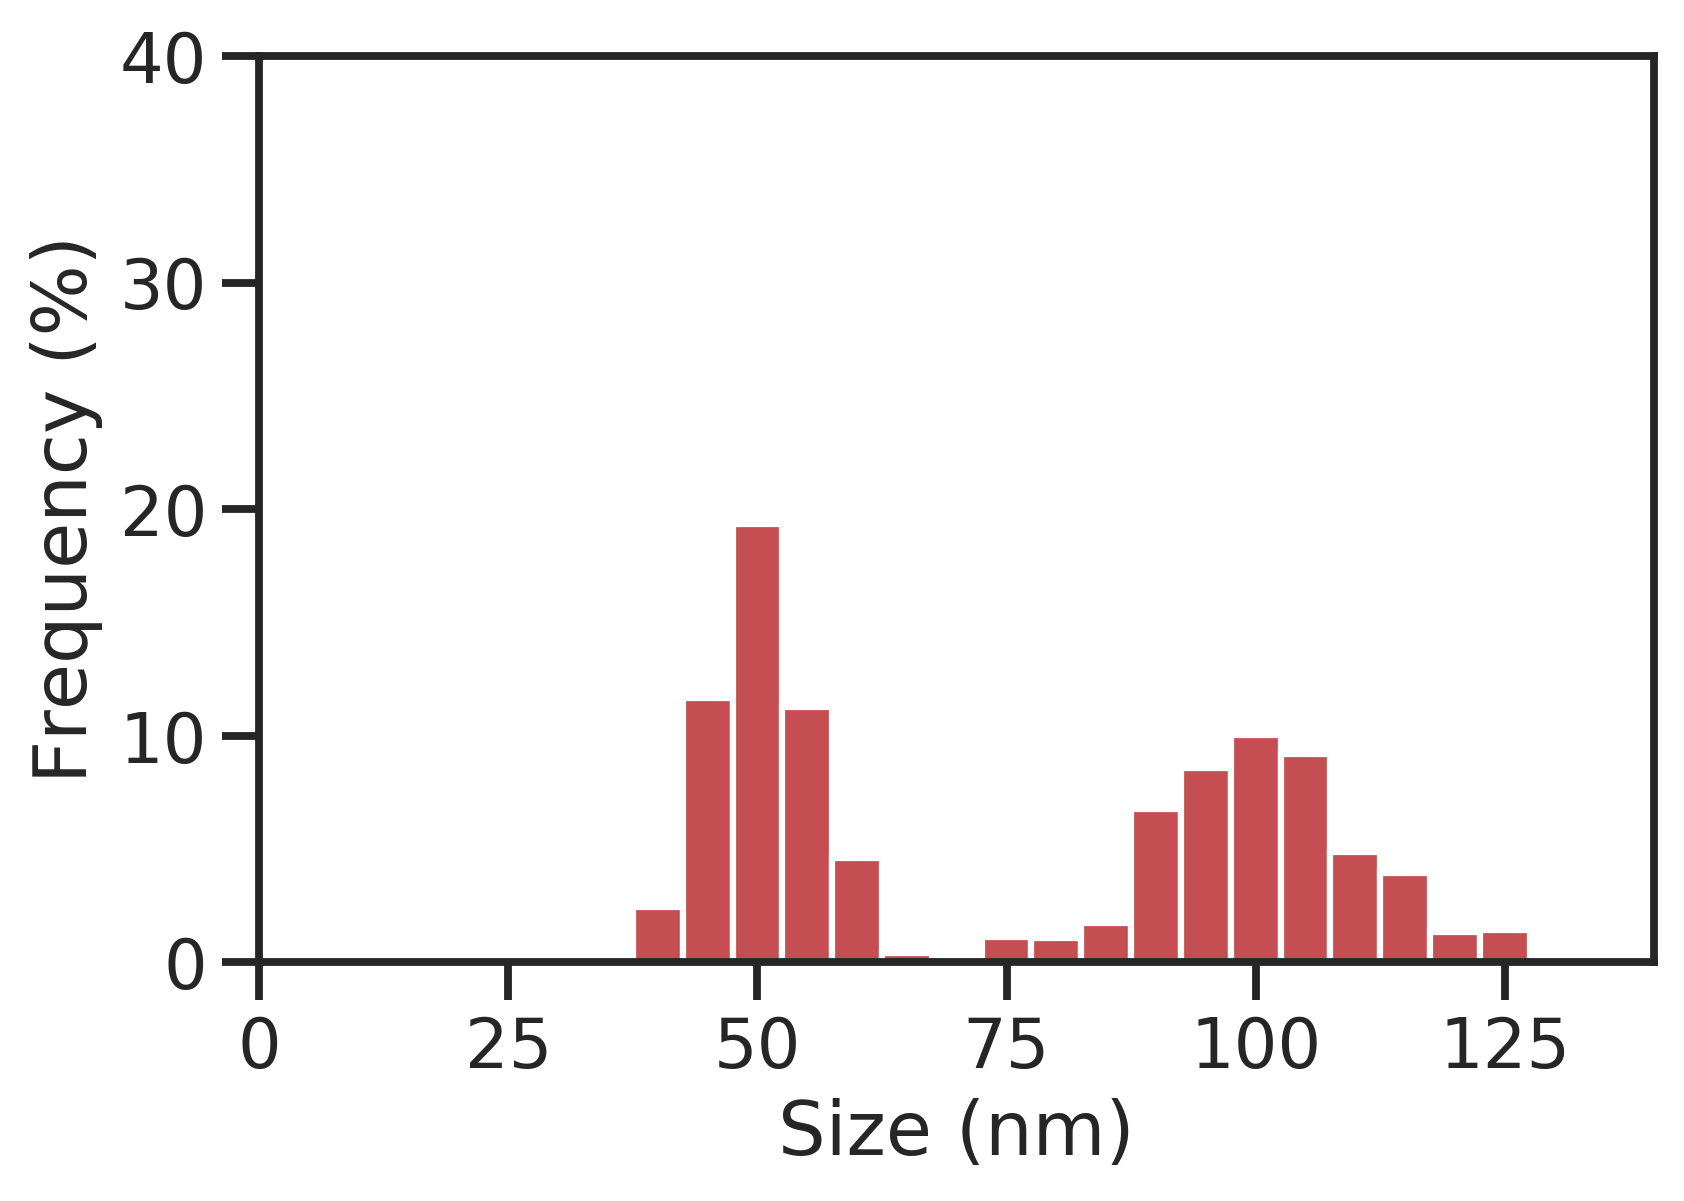

In [112]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

In [113]:
np.savetxt('100nm_explore_frequency_ps_8part.txt', frag_freq)

(0, 40)

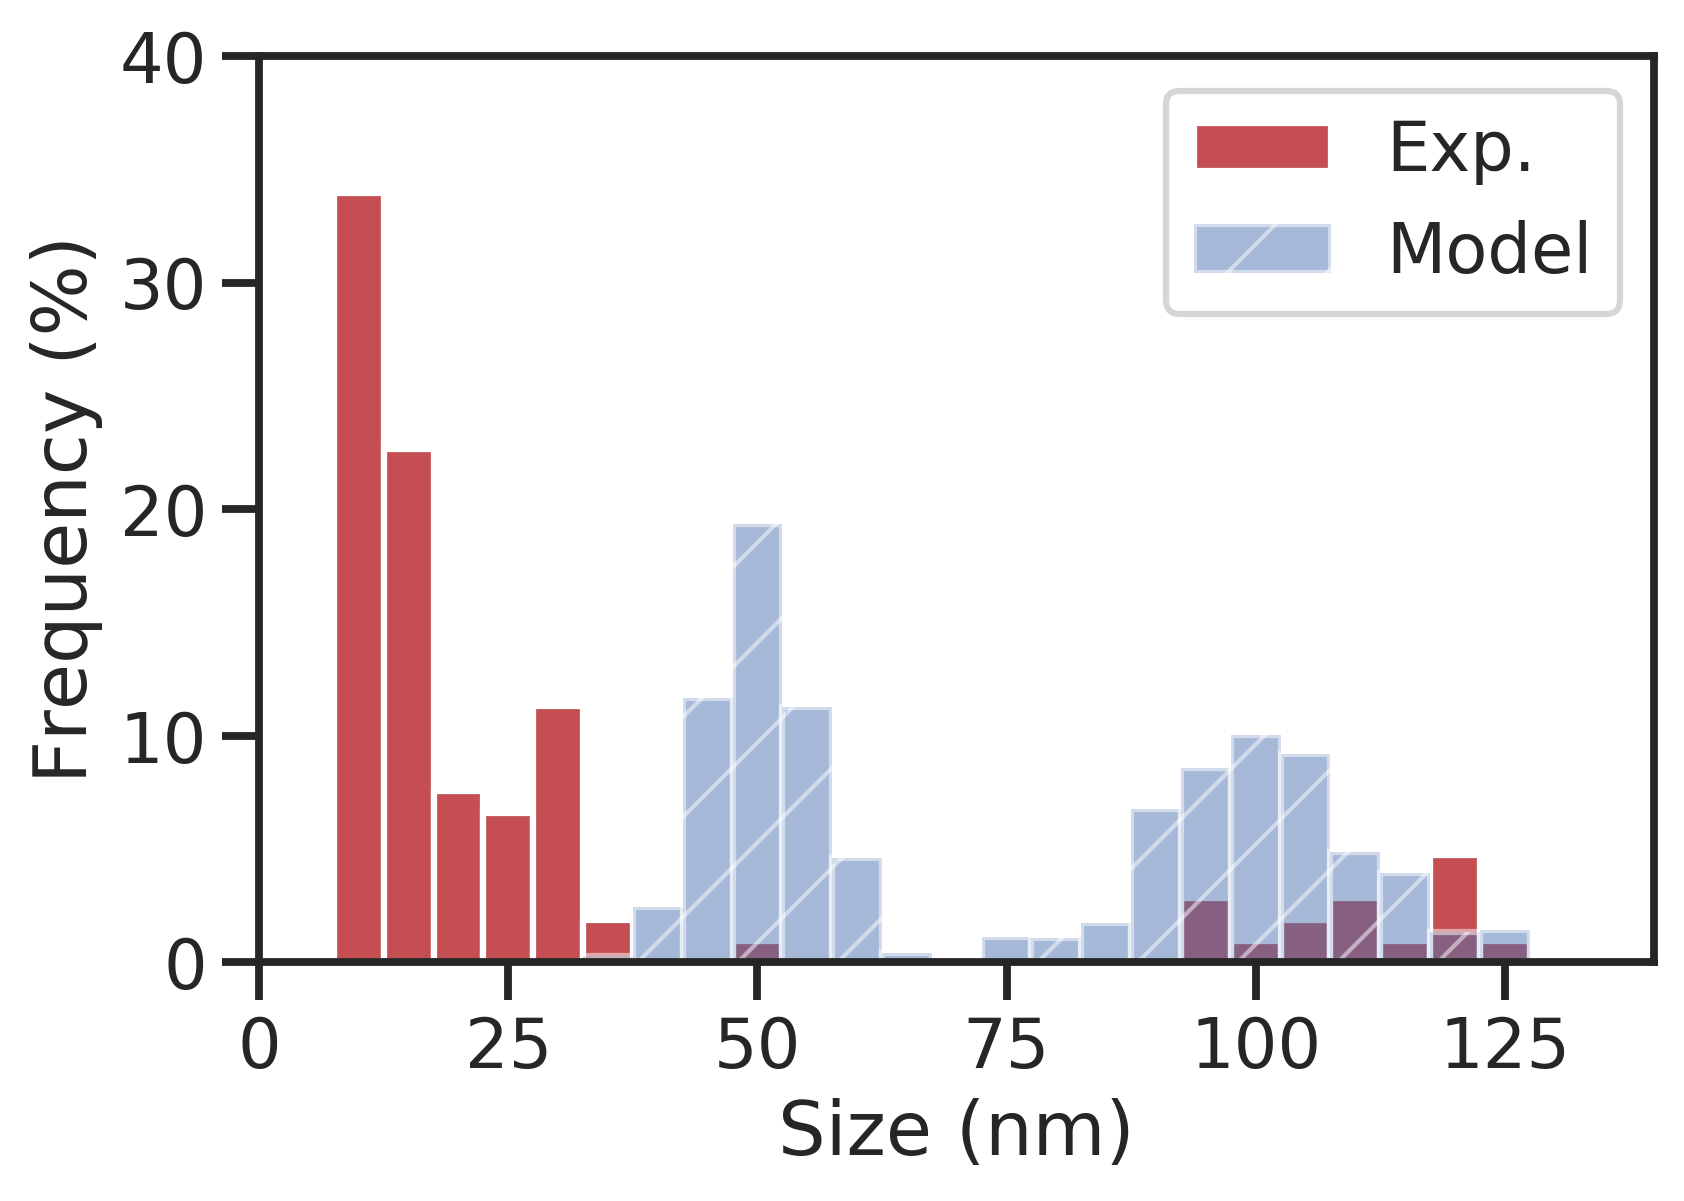

In [114]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,40))

(0, 40)

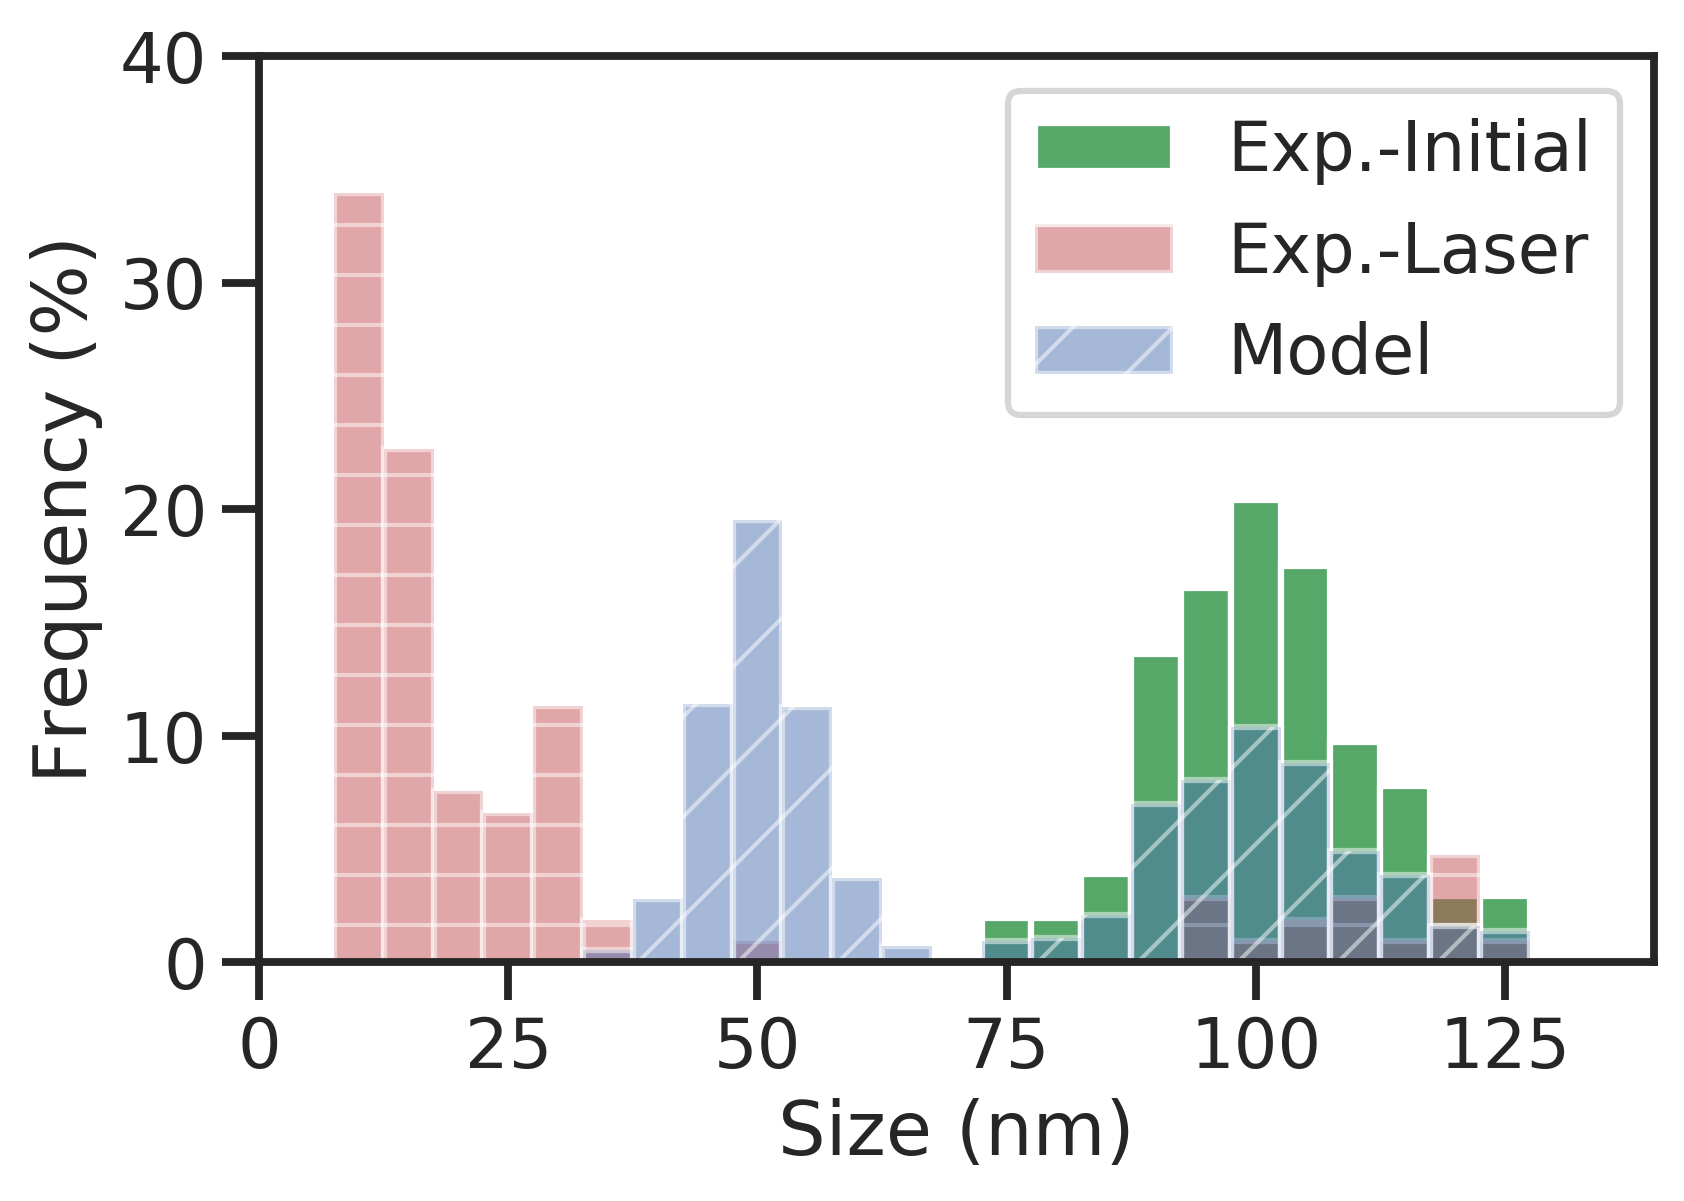

In [129]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,40))

## Particle Split - 16 Particles

Here, we apply a model for 1/5 of particles splitting into four particles of equal volume particles, so that the ratio of fragments to unfragmented particles is 1:1.

In [130]:
nfrag = 128
Vo = (4/3)*np.pi*rads**3
frac = 0.01
Vfrag = Vo[:int(frac*len(Vo))]/nfrag
rfrag = ((3/4)*Vfrag/np.pi)**(1/3) 
Dfrag = rfrag*2

In [131]:
frag_tuple = list()
for i in range(nfrag):
    frag_tuple.append(Dfrag)
frag_tuple.append(sample_sizes[int(frac*len(Vo)):])    
frag_sizes = np.concatenate(frag_tuple)

In [132]:
frag_counts, _edges = np.histogram(frag_sizes, bins=edges)
print(frag_counts[:5])
frag_freq = 100 * frag_counts / len(frag_sizes)
print(frag_freq[:5])

[   0    0 1792 9344 1664]
[ 0.          0.          7.89427313 41.16299559  7.33039648]


(0, 40)

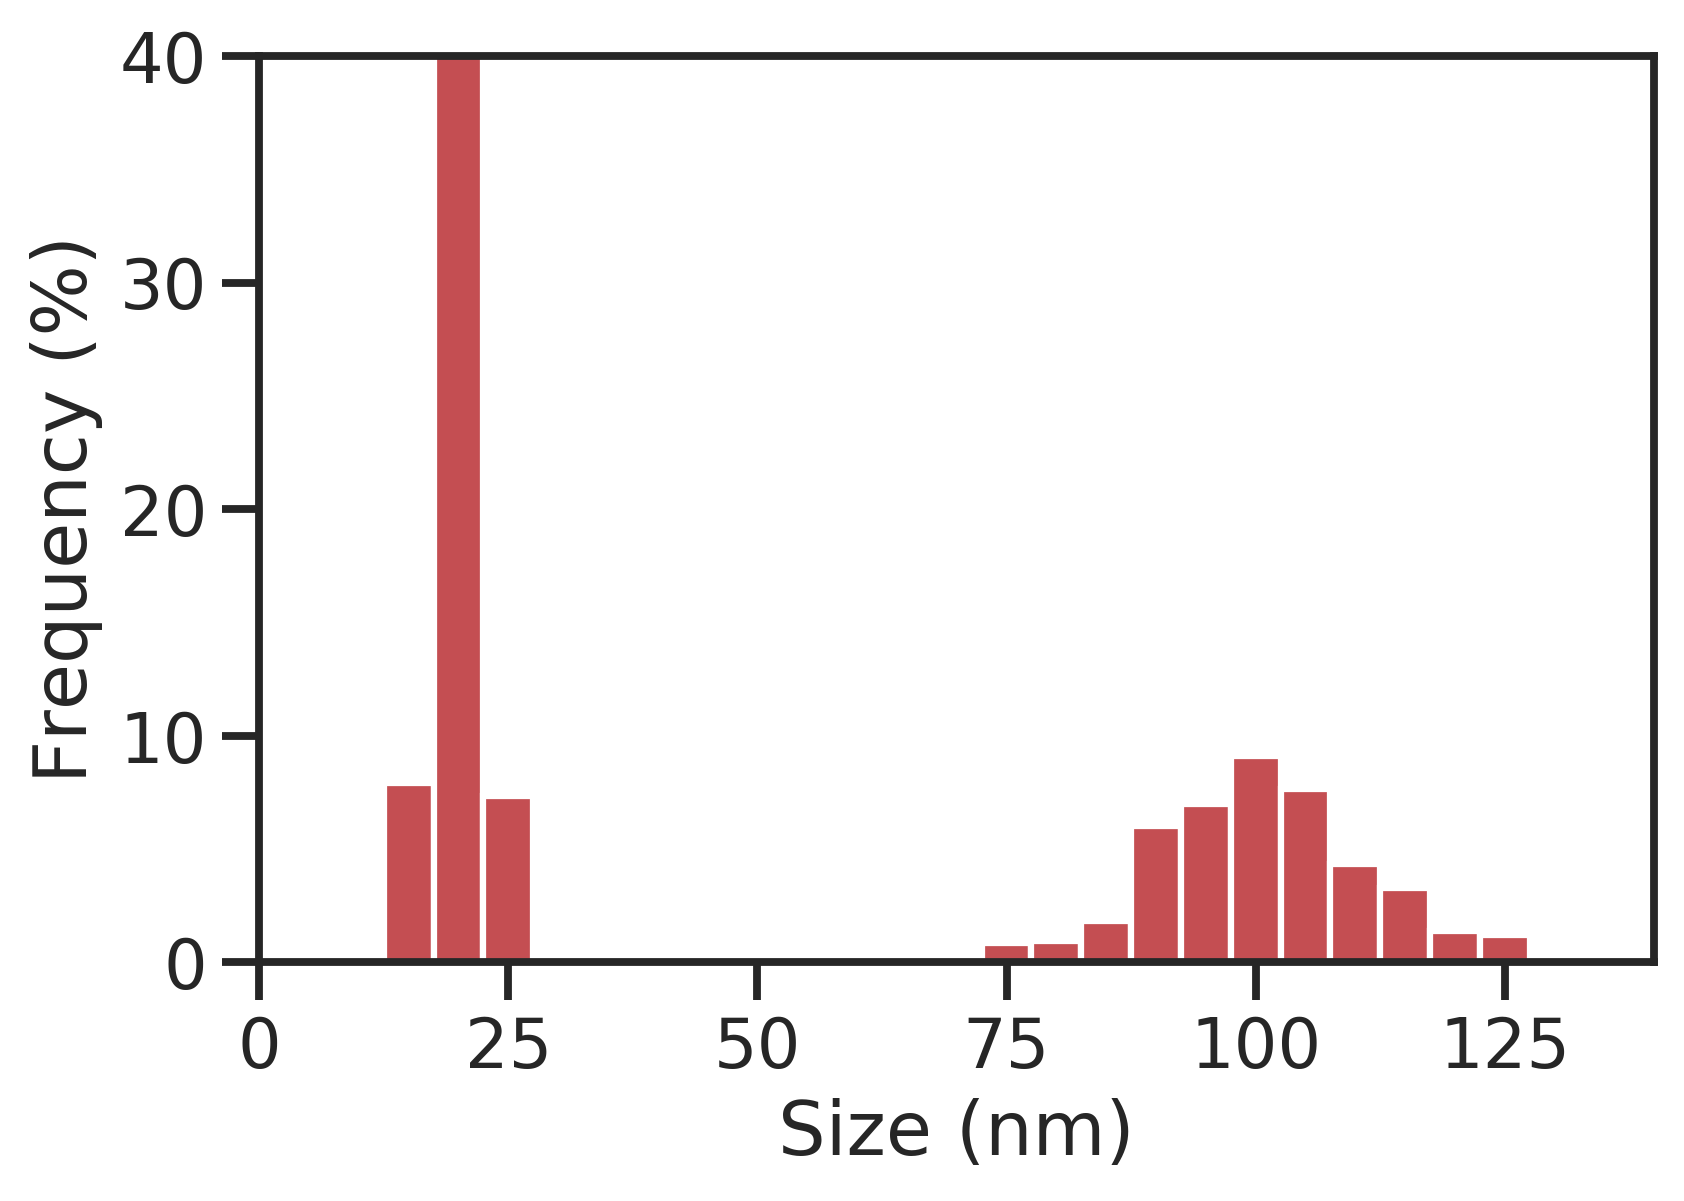

In [133]:
plt.hist(centers, bins=edges, weights=frag_freq, color='r')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.ylim((0,40))

(0, 80)

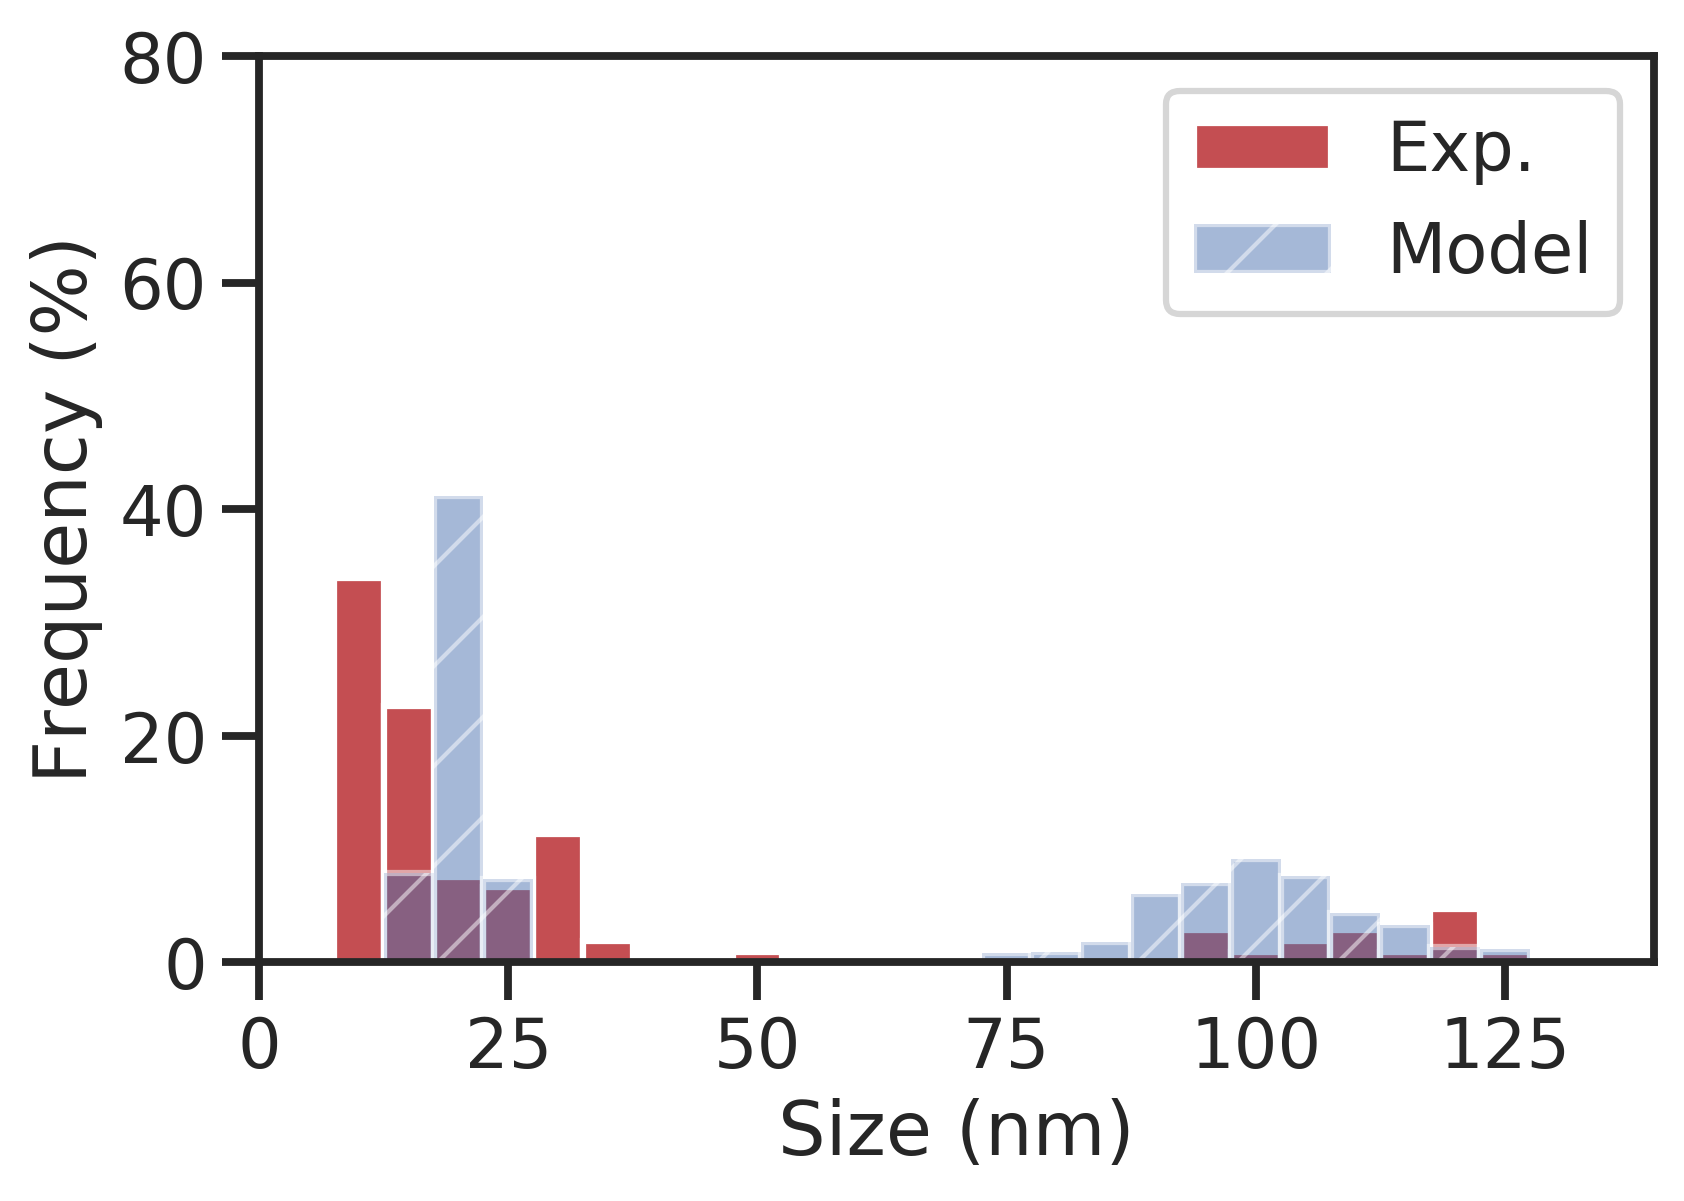

In [134]:
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=1, label='Exp.')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend()
plt.ylim((0,80))

(0, 40)

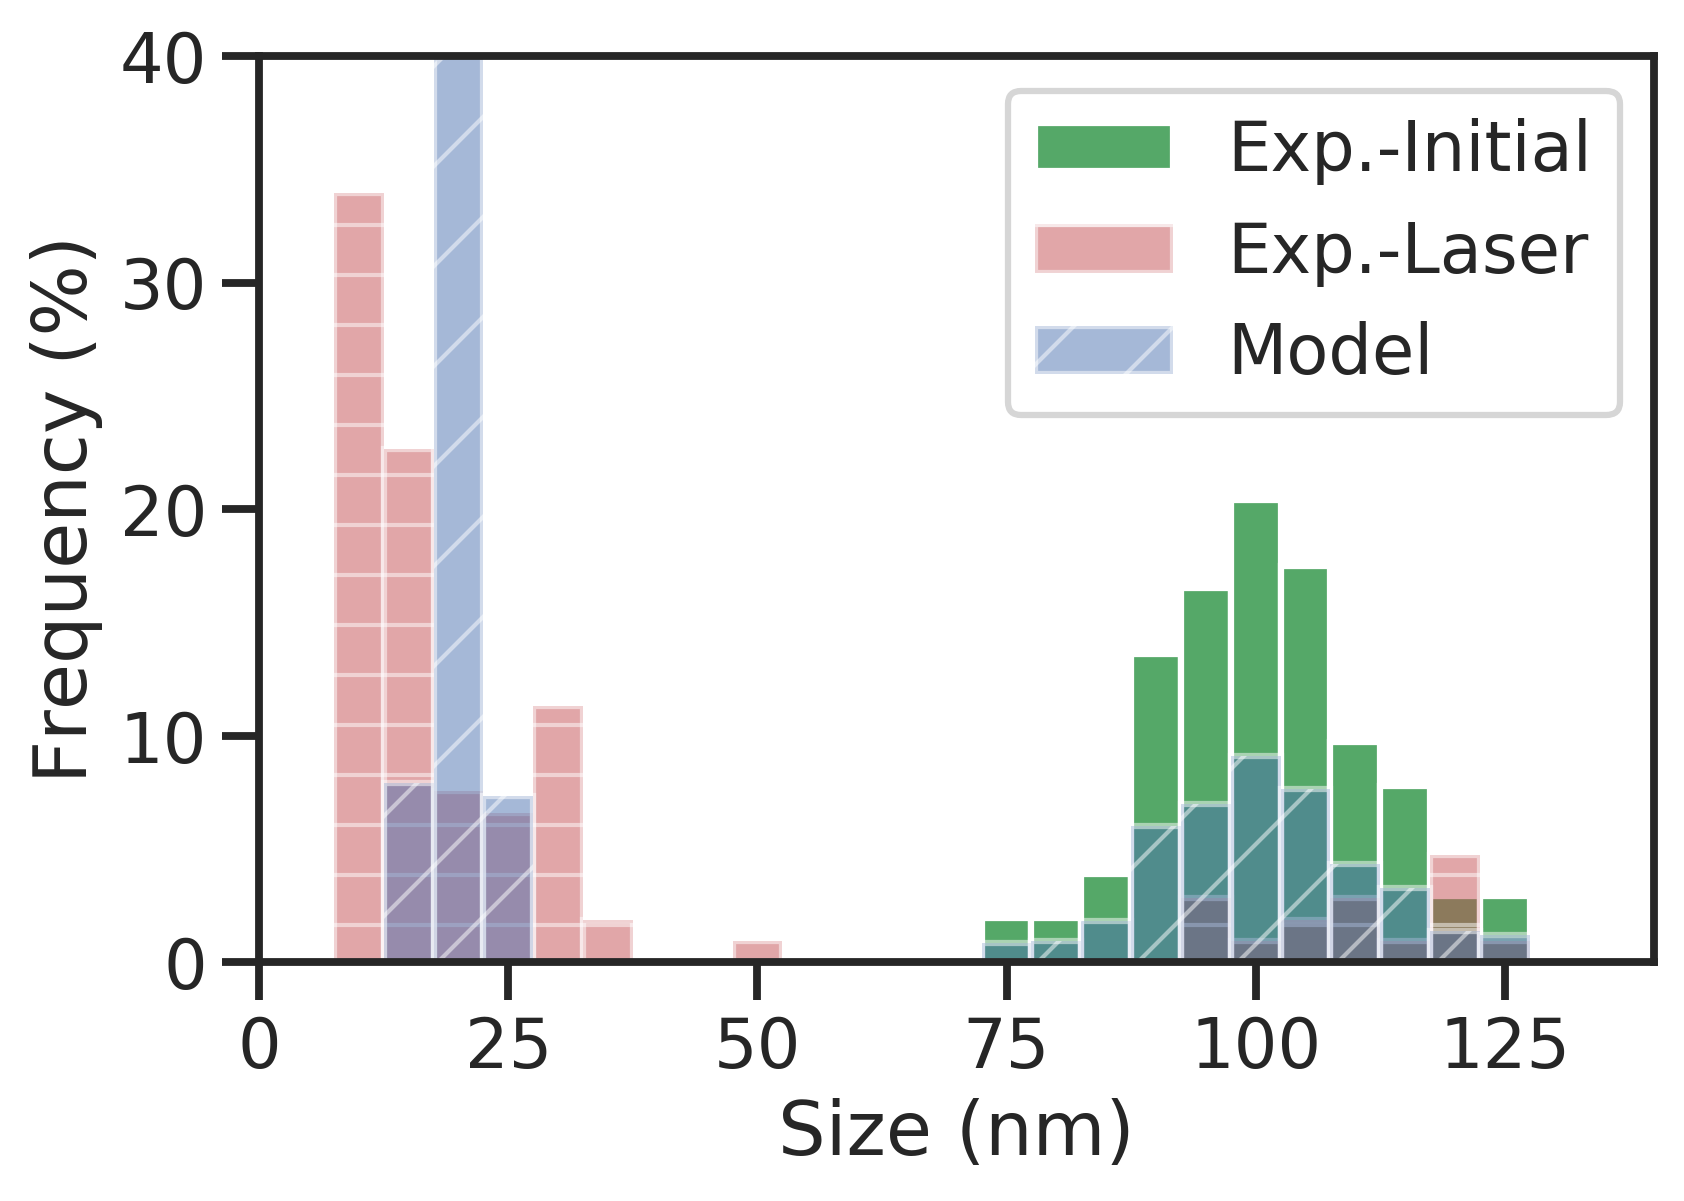

In [135]:
plt.hist(centers, bins=edges, weights=dist['initial'], color='g', alpha=1, label='Exp.-Initial')
plt.hist(centers, bins=edges, weights=dist['laser'], color='r', alpha=0.5, label='Exp.-Laser', hatch='-')
plt.hist(centers, bins=edges, weights=frag_freq, color='b', alpha=0.5, label='Model', hatch='/')
plt.xlim((0,140))
plt.ylabel("Frequency (%)")
plt.xlabel("Size (nm)")
plt.legend(loc=0)
plt.ylim((0,40))